In [1]:
%load_ext autoreload
%autoreload 2

import lib.fd_imputer as fd_imputer
import pandas as pd
import numpy as np
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt

### Set up all paths and labels needed in this notebook

In [32]:
DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/adult.csv'
SPLITS_PATH = 'MLFD_fd_detection/data/'
METANOME_DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/'
FD_PATH = 'MLFD_fd_detection/results/HyFD-1.2-SNAPSHOT.jar2019-06-20T230458_fds'
DATA_TITLE = 'adult'

## Splitting

**Vorsichtig** mit der Split-Funktion. In DATA_PATH liegt das df_train, dessen FDs von Hand bestimmt wurden.
Jedes Mal, wenn split_df mit SPLITS_PATH als Argument ausgefuehrt wird, muss haendisch mit Metanome die FDs bestimmt werden und der FD_PATH angepasst werden.

In [6]:
# df_ad = pd.read_csv(DATA_PATH, sep=';', header=None)
# fd_imputer.split_df('adult', df_ad, [0.8, 0.1, 0.1], SPLITS_PATH)
# print('original data duplicates: ' + str(sum(df_ad.duplicated())))
# print('split and joined data duplicates: ' + str(sum(pd.concat([df_test, df_validate, df_train]).duplicated())))

kein doppelter index
Dataset successfully written to MLFD_fd_detection/data/adult.csv
train set successfully written to MLFD_fd_detection/data/train/adult_train.csv
validate set successfully written to MLFD_fd_detection/data/validate/adult_validate.csv
test set successfully written to MLFD_fd_detection/data/test/adult_test.csv


Das hier ist blöd: Eigentlich sollte die Vereinigung von Train, Test und Validate ebensoviele Duplikate beinhalten wie das ursprüngliche DataFrame. Die (auch relative) `split_ratio` in `split_df()` habe ich schon gecheckt, die stimmt für `[0.8, 0.1, 0.1]` auf jeden Fall.
Gleiches Ergebnis, wenn ich statt `datawig.utils.random_split()` auf `sklearn.model_selection.train_test_split` zurückgreife.

## Load data, make definitions

In [33]:
df_train, df_validate, df_test = fd_imputer.load_dataframes(SPLITS_PATH, 'adult', 'np.nan')
fds = fd_imputer.read_fds(FD_PATH)
continuous = [0, 1, 3, 11, 12, 13] # cols containing continuous numbers

## FD_Imputer on adult.csv

In [10]:
fd_imputer_results = fd_imputer.run_fd_imputer_on_fd_set(df_train, 
                                                         df_validate, 
                                                         fds, 
                                                         continuous)

{3: [0]}
{11: [0]}
{13: [0]}
{12: [0]}
{12: [13, 1, 2, 3, 4, 7]}
{12: [13, 1, 3, 4, 6, 7]}
{12: [13, 1, 3, 4, 7, 8]}
{12: [13, 1, 2, 3, 5, 7]}
{12: [13, 1, 3, 5, 6, 7]}
{12: [13, 1, 3, 5, 7, 8]}
{1: [0]}
{14: [0]}
{4: [0]}


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{4: [5]}
{5: [0]}
{5: [4]}
{7: [0]}
{2: [0]}
{6: [0]}
{6: [11, 13, 1, 3, 7, 8]}
{6: [13, 1, 3, 4, 7, 8]}
{6: [13, 1, 3, 5, 7, 8]}
{8: [0]}
{9: [0]}
{9: [11, 12, 13, 3, 7, 8]}
{9: [12, 13, 15, 3, 4, 6, 8]}
{9: [12, 13, 15, 3, 5, 6, 8]}
{9: [13, 1, 3, 4]}
{9: [13, 1, 3, 5]}
{9: [13, 1, 2, 3, 7]}
{9: [13, 14, 3, 4, 7]}
{9: [13, 14, 3, 4, 6, 8]}
{9: [13, 14, 3, 5, 7]}
{9: [13, 14, 3, 5, 6, 8]}
{9: [13, 14, 2, 3, 7]}
{9: [13, 14, 3, 6, 7]}
{9: [13, 14, 3, 7, 8]}
{9: [10, 13, 14, 15, 3, 7]}
{9: [13, 15, 2, 3, 4, 6, 8]}
{9: [13, 15, 2, 3, 5, 6, 8]}
{9: [12, 14, 2, 3, 4, 6, 8]}
{9: [12, 14, 2, 3, 5, 6, 8]}
{9: [12, 15, 2, 3, 4, 6, 8]}
{9: [12, 15, 2, 3, 5, 6, 8]}
{9: [14, 1, 3, 4]}
{9: [14, 1, 3, 5]}
{9: [14, 1, 2, 3, 7]}
{9: [14, 1, 2, 3, 6]}
{9: [1, 3, 4, 6]}
{9: [1, 3, 4, 8]}
{9: [15, 1, 3, 4]}
{9: [1, 3, 5, 6]}
{9: [1, 3, 5, 8]}
{9: [15, 1, 3, 5]}
{9: [1, 3, 6, 7]}
{9: [1, 3, 7, 8]}
{9: [15, 1, 3, 7]}
{9: [10, 14, 3, 4, 7]}
{9: [14, 15, 2, 3, 4, 6, 8]}
{9: [10, 14, 3, 5, 7]}
{9: [14, 15, 2

In [11]:
fd_imputer_results

{3: [{'nans': 3256, 'lhs': [0], 'mse': ''}],
 11: [{'nans': 3256, 'lhs': [0], 'mse': ''}],
 13: [{'nans': 3256, 'lhs': [0], 'mse': ''}],
 12: [{'nans': 3256, 'lhs': [0], 'mse': ''},
  {'nans': 3246, 'lhs': [13, 1, 2, 3, 4, 7], 'mse': 0.0},
  {'nans': 3246, 'lhs': [13, 1, 3, 4, 6, 7], 'mse': 390852.9},
  {'nans': 3246, 'lhs': [13, 1, 3, 4, 7, 8], 'mse': 390852.9},
  {'nans': 3246, 'lhs': [13, 1, 2, 3, 5, 7], 'mse': 0.0},
  {'nans': 3246, 'lhs': [13, 1, 3, 5, 6, 7], 'mse': 390852.9},
  {'nans': 3246, 'lhs': [13, 1, 3, 5, 7, 8], 'mse': 390852.9}],
 1: [{'nans': 3256, 'lhs': [0], 'mse': ''}],
 14: [{'lhs': [0], 'f1': 0.0, 'recall': 0.0, 'precision': 0.0}],
 4: [{'lhs': [0], 'f1': 0.0, 'recall': 0.0, 'precision': 0.0},
  {'lhs': [5], 'f1': 1.0, 'recall': 1.0, 'precision': 1.0}],
 5: [{'lhs': [0], 'f1': 0, 'recall': 0, 'precision': 0},
  {'lhs': [4], 'f1': 1.0, 'recall': 1.0, 'precision': 1.0}],
 7: [{'lhs': [0], 'f1': 0.0, 'recall': 0.0, 'precision': 0.0}],
 2: [{'lhs': [0], 'f1': 0.0, 'rec

## ML imputation on fd's

In [34]:
ml_imputer_results = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_validate,
                                                        df_test,
                                                        fds,
                                                        continuous)

[0] 3


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:38:21,361 [INFO]  
========== start: fit model
2019-06-22 10:38:21,370 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:38:22,386 [INFO]  Epoch[0] Batch [0-814]	Speed: 12909.08 samples/sec	cross-entropy=0.086189	3-accuracy=0.000000
2019-06-22 10:38:23,295 [INFO]  Epoch[0] Train-cross-entropy=0.044155
2019-06-22 10:38:23,299 [INFO]  Epoch[0] Train-3-accuracy=0.000000
2019-06-22 10:38:23,303 [INFO]  Epoch[0] Time cost=1.928
2019-06-22 10:38:23,311 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:38:23,432 [INFO]  Epoch[0] Validation-cross-entropy=0.000430
2019-06

[0] 11


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:38:45,758 [INFO]  
========== start: fit model
2019-06-22 10:38:45,763 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:38:46,945 [INFO]  Epoch[0] Batch [0-814]	Speed: 11099.02 samples/sec	cross-entropy=0.313748	11-accuracy=0.000000
2019-06-22 10:38:47,941 [INFO]  Epoch[0] Train-cross-entropy=0.226679
2019-06-22 10:38:47,946 [INFO]  Epoch[0] Train-11-accuracy=0.000000
2019-06-22 10:38:47,950 [INFO]  Epoch[0] Time cost=2.181
2019-06-22 10:38:47,957 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:38:48,078 [INFO]  Epoch[0] Validation-cross-entropy=0.051114
2019-

[0] 13


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:38:57,915 [INFO]  
========== start: fit model
2019-06-22 10:38:57,922 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:38:58,881 [INFO]  Epoch[0] Batch [0-814]	Speed: 13690.60 samples/sec	cross-entropy=0.161687	13-accuracy=0.000000
2019-06-22 10:38:59,766 [INFO]  Epoch[0] Train-cross-entropy=0.081102
2019-06-22 10:38:59,771 [INFO]  Epoch[0] Train-13-accuracy=0.000000
2019-06-22 10:38:59,775 [INFO]  Epoch[0] Time cost=1.847
2019-06-22 10:38:59,781 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:38:59,855 [INFO]  Epoch[0] Validation-cross-entropy=0.000216
2019-

[0] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:39:11,196 [INFO]  
========== start: fit model
2019-06-22 10:39:11,202 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:39:12,190 [INFO]  Epoch[0] Batch [0-814]	Speed: 13328.40 samples/sec	cross-entropy=0.088465	12-accuracy=0.000000
2019-06-22 10:39:13,143 [INFO]  Epoch[0] Train-cross-entropy=0.048096
2019-06-22 10:39:13,147 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:39:13,151 [INFO]  Epoch[0] Time cost=1.941
2019-06-22 10:39:13,159 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:39:13,262 [INFO]  Epoch[0] Validation-cross-entropy=0.001066
2019-

[13, 1, 2, 3, 4, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:39:31,683 [INFO]  
========== start: fit model
2019-06-22 10:39:31,687 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:39:39,281 [INFO]  Epoch[0] Batch [0-814]	Speed: 1718.64 samples/sec	cross-entropy=0.133190	12-accuracy=0.000000
2019-06-22 10:39:47,224 [INFO]  Epoch[0] Train-cross-entropy=0.080974
2019-06-22 10:39:47,229 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:39:47,233 [INFO]  Epoch[0] Time cost=15.539
2019-06-22 10:39:47,240 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:39:48,982 [INFO]  Epoch[0] Validation-cross-entropy=0.002753
2019-

[13, 1, 3, 4, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:40:50,194 [INFO]  
========== start: fit model
2019-06-22 10:40:50,198 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:40:57,380 [INFO]  Epoch[0] Batch [0-814]	Speed: 1817.36 samples/sec	cross-entropy=0.126811	12-accuracy=0.000000
2019-06-22 10:41:04,866 [INFO]  Epoch[0] Train-cross-entropy=0.077666
2019-06-22 10:41:04,871 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:41:04,875 [INFO]  Epoch[0] Time cost=14.671
2019-06-22 10:41:04,881 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:41:06,421 [INFO]  Epoch[0] Validation-cross-entropy=0.003770
2019-

[13, 1, 3, 4, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:43:49,405 [INFO]  
========== start: fit model
2019-06-22 10:43:49,409 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:43:57,084 [INFO]  Epoch[0] Batch [0-814]	Speed: 1700.66 samples/sec	cross-entropy=0.142904	12-accuracy=0.000000
2019-06-22 10:44:05,071 [INFO]  Epoch[0] Train-cross-entropy=0.084936
2019-06-22 10:44:05,075 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:44:05,079 [INFO]  Epoch[0] Time cost=15.667
2019-06-22 10:44:05,086 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:44:06,704 [INFO]  Epoch[0] Validation-cross-entropy=0.021062
2019-

[13, 1, 2, 3, 5, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:46:57,055 [INFO]  
========== start: fit model
2019-06-22 10:46:57,059 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:47:06,055 [INFO]  Epoch[0] Batch [0-814]	Speed: 1450.21 samples/sec	cross-entropy=0.151126	12-accuracy=0.000000
2019-06-22 10:47:14,448 [INFO]  Epoch[0] Train-cross-entropy=0.088217
2019-06-22 10:47:14,459 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:47:14,470 [INFO]  Epoch[0] Time cost=17.405
2019-06-22 10:47:14,479 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:47:16,496 [INFO]  Epoch[0] Validation-cross-entropy=0.005228
2019-

[13, 1, 3, 5, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:49:43,934 [INFO]  
========== start: fit model
2019-06-22 10:49:43,938 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:49:51,604 [INFO]  Epoch[0] Batch [0-814]	Speed: 1702.05 samples/sec	cross-entropy=0.155247	12-accuracy=0.000000
2019-06-22 10:49:59,318 [INFO]  Epoch[0] Train-cross-entropy=0.088448
2019-06-22 10:49:59,323 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:49:59,327 [INFO]  Epoch[0] Time cost=15.384
2019-06-22 10:49:59,333 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:50:00,919 [INFO]  Epoch[0] Validation-cross-entropy=0.009600
2019-

[13, 1, 3, 5, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:52:56,414 [INFO]  
========== start: fit model
2019-06-22 10:52:56,419 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:53:04,515 [INFO]  Epoch[0] Batch [0-814]	Speed: 1611.61 samples/sec	cross-entropy=0.157594	12-accuracy=0.000000
2019-06-22 10:53:12,197 [INFO]  Epoch[0] Train-cross-entropy=0.086859
2019-06-22 10:53:12,202 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-22 10:53:12,206 [INFO]  Epoch[0] Time cost=15.782
2019-06-22 10:53:12,213 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:53:13,849 [INFO]  Epoch[0] Validation-cross-entropy=0.006871
2019-

[0] 1


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 10:55:56,187 [INFO]  
========== start: fit model
2019-06-22 10:55:56,196 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:55:57,291 [INFO]  Epoch[0] Batch [0-814]	Speed: 12500.16 samples/sec	cross-entropy=0.048394	1-accuracy=0.000000
2019-06-22 10:55:58,207 [INFO]  Epoch[0] Train-cross-entropy=0.024520
2019-06-22 10:55:58,211 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-06-22 10:55:58,216 [INFO]  Epoch[0] Time cost=1.998
2019-06-22 10:55:58,223 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:55:58,315 [INFO]  Epoch[0] Validation-cross-entropy=0.001896
2019-06

2019-06-22 10:56:14,786 [INFO]  CategoricalEncoder for column 14                                found only 15 occurrences of value Cambodia
2019-06-22 10:56:14,791 [INFO]  CategoricalEncoder for column 14                                found only 14 occurrences of value Laos
2019-06-22 10:56:14,796 [INFO]  CategoricalEncoder for column 14                                found only 14 occurrences of value Outlying-US(Guam-USVI-etc)
2019-06-22 10:56:14,801 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Thailand
2019-06-22 10:56:14,806 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Yugoslavia
2019-06-22 10:56:14,810 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Trinadad&Tobago
2019-06-22 10:56:14,813 [INFO]  CategoricalEncoder for column 14                                found only 12 occurrences of value Hungar

[0] 14


2019-06-22 10:56:15,690 [WARNING]  Test set does not contain any ocurrences of values [Holand-Netherlands, Hungary, Outlying-US(Guam-USVI-etc)] in column [14], consider using a more representative test set.
2019-06-22 10:56:15,701 [INFO]  
========== start: fit model
2019-06-22 10:56:15,705 [WARNING]  Already bound, ignoring bind()
2019-06-22 10:56:37,086 [INFO]  Epoch[0] Batch [0-814]	Speed: 610.45 samples/sec	cross-entropy=0.249582	14-accuracy=0.956442
2019-06-22 10:56:57,974 [INFO]  Epoch[0] Train-cross-entropy=0.138204
2019-06-22 10:56:57,978 [INFO]  Epoch[0] Train-14-accuracy=0.977234
2019-06-22 10:56:57,982 [INFO]  Epoch[0] Time cost=42.272
2019-06-22 10:56:58,003 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 10:57:00,322 [INFO]  Epoch[0] Validation-cross-entropy=0.011673
2019-06-22 10:57:00,326 [INFO]  Epoch[0] Validation-14-accuracy=1.000000
2019-06-22 10:57:23,554 [INFO]  Epoch[1] Batch [0-814]	Speed: 561.38 samples/sec	cross-entropy=0.007152	14-accu

[0] 4


2019-06-22 11:03:55,470 [INFO]  
========== start: fit model
2019-06-22 11:03:55,476 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:04:10,011 [INFO]  Epoch[0] Batch [0-814]	Speed: 897.90 samples/sec	cross-entropy=0.273194	4-accuracy=0.962347
2019-06-22 11:04:23,142 [INFO]  Epoch[0] Train-cross-entropy=0.143835
2019-06-22 11:04:23,146 [INFO]  Epoch[0] Train-4-accuracy=0.981112
2019-06-22 11:04:23,153 [INFO]  Epoch[0] Time cost=27.672
2019-06-22 11:04:23,168 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:04:25,126 [INFO]  Epoch[0] Validation-cross-entropy=0.007395
2019-06-22 11:04:25,132 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-06-22 11:04:37,772 [INFO]  Epoch[1] Batch [0-814]	Speed: 1032.53 samples/sec	cross-entropy=0.004957	4-accuracy=1.000000
2019-06-22 11:04:50,286 [INFO]  Epoch[1] Train-cross-entropy=0.003705
2019-06-22 11:04:50,290 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-06-22 11:04:50,294 [INFO]  Epoch[1] Time cost=25.156
2

[5] 4


2019-06-22 11:08:40,828 [INFO]  
========== start: fit model
2019-06-22 11:08:40,833 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:08:53,697 [INFO]  Epoch[0] Batch [0-814]	Speed: 1015.12 samples/sec	cross-entropy=0.182577	4-accuracy=0.976610
2019-06-22 11:09:06,594 [INFO]  Epoch[0] Train-cross-entropy=0.094826
2019-06-22 11:09:06,601 [INFO]  Epoch[0] Train-4-accuracy=0.988291
2019-06-22 11:09:06,608 [INFO]  Epoch[0] Time cost=25.766
2019-06-22 11:09:06,651 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:09:08,654 [INFO]  Epoch[0] Validation-cross-entropy=0.003564
2019-06-22 11:09:08,660 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-06-22 11:09:21,396 [INFO]  Epoch[1] Batch [0-814]	Speed: 1024.68 samples/sec	cross-entropy=0.002362	4-accuracy=1.000000
2019-06-22 11:09:34,213 [INFO]  Epoch[1] Train-cross-entropy=0.001754
2019-06-22 11:09:34,220 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-06-22 11:09:34,226 [INFO]  Epoch[1] Time cost=25.559


[0] 5


2019-06-22 11:13:29,220 [INFO]  
========== start: fit model
2019-06-22 11:13:29,225 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:13:41,830 [INFO]  Epoch[0] Batch [0-814]	Speed: 1035.74 samples/sec	cross-entropy=0.769578	5-accuracy=0.842408
2019-06-22 11:13:54,586 [INFO]  Epoch[0] Train-cross-entropy=0.450527
2019-06-22 11:13:54,591 [INFO]  Epoch[0] Train-5-accuracy=0.917498
2019-06-22 11:13:54,598 [INFO]  Epoch[0] Time cost=25.367
2019-06-22 11:13:54,609 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:13:56,567 [INFO]  Epoch[0] Validation-cross-entropy=0.070033
2019-06-22 11:13:56,574 [INFO]  Epoch[0] Validation-5-accuracy=0.998468
2019-06-22 11:14:09,777 [INFO]  Epoch[1] Batch [0-814]	Speed: 988.32 samples/sec	cross-entropy=0.048876	5-accuracy=0.998390
2019-06-22 11:14:22,443 [INFO]  Epoch[1] Train-cross-entropy=0.036728
2019-06-22 11:14:22,450 [INFO]  Epoch[1] Train-5-accuracy=0.998464
2019-06-22 11:14:22,457 [INFO]  Epoch[1] Time cost=25.876
2

[4] 5


2019-06-22 11:18:15,320 [INFO]  
========== start: fit model
2019-06-22 11:18:15,325 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:18:27,131 [INFO]  Epoch[0] Batch [0-814]	Speed: 1106.56 samples/sec	cross-entropy=0.222078	5-accuracy=0.990721
2019-06-22 11:18:39,090 [INFO]  Epoch[0] Train-cross-entropy=0.115290
2019-06-22 11:18:39,095 [INFO]  Epoch[0] Train-5-accuracy=0.995355
2019-06-22 11:18:39,100 [INFO]  Epoch[0] Time cost=23.768
2019-06-22 11:18:39,110 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:18:41,139 [INFO]  Epoch[0] Validation-cross-entropy=0.004393
2019-06-22 11:18:41,143 [INFO]  Epoch[0] Validation-5-accuracy=1.000000
2019-06-22 11:18:53,065 [INFO]  Epoch[1] Batch [0-814]	Speed: 1094.39 samples/sec	cross-entropy=0.002996	5-accuracy=1.000000
2019-06-22 11:19:05,455 [INFO]  Epoch[1] Train-cross-entropy=0.002241
2019-06-22 11:19:05,475 [INFO]  Epoch[1] Train-5-accuracy=1.000000
2019-06-22 11:19:05,480 [INFO]  Epoch[1] Time cost=24.333


[0] 7


2019-06-22 11:22:45,655 [INFO]  
========== start: fit model
2019-06-22 11:22:45,658 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:22:57,845 [INFO]  Epoch[0] Batch [0-814]	Speed: 1071.26 samples/sec	cross-entropy=0.217727	7-accuracy=0.980752
2019-06-22 11:23:10,302 [INFO]  Epoch[0] Train-cross-entropy=0.113267
2019-06-22 11:23:10,306 [INFO]  Epoch[0] Train-7-accuracy=0.990210
2019-06-22 11:23:10,310 [INFO]  Epoch[0] Time cost=24.646
2019-06-22 11:23:10,323 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:23:12,217 [INFO]  Epoch[0] Validation-cross-entropy=0.004104
2019-06-22 11:23:12,222 [INFO]  Epoch[0] Validation-7-accuracy=1.000000
2019-06-22 11:23:24,489 [INFO]  Epoch[1] Batch [0-814]	Speed: 1063.66 samples/sec	cross-entropy=0.002946	7-accuracy=0.999923
2019-06-22 11:23:37,067 [INFO]  Epoch[1] Train-cross-entropy=0.002198
2019-06-22 11:23:37,072 [INFO]  Epoch[1] Train-7-accuracy=0.999962
2019-06-22 11:23:37,077 [INFO]  Epoch[1] Time cost=24.850


[0] 2


2019-06-22 11:27:22,746 [WARNING]  Test set does not contain any ocurrences of values [Without-pay, Never-worked] in column [2], consider using a more representative test set.
2019-06-22 11:27:22,754 [INFO]  
========== start: fit model
2019-06-22 11:27:22,760 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:27:33,394 [INFO]  Epoch[0] Batch [0-814]	Speed: 1227.31 samples/sec	cross-entropy=0.130751	2-accuracy=0.976840
2019-06-22 11:27:44,104 [INFO]  Epoch[0] Train-cross-entropy=0.069153
2019-06-22 11:27:44,110 [INFO]  Epoch[0] Train-2-accuracy=0.988176
2019-06-22 11:27:44,116 [INFO]  Epoch[0] Time cost=21.351
2019-06-22 11:27:44,125 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:27:46,050 [INFO]  Epoch[0] Validation-cross-entropy=0.003269
2019-06-22 11:27:46,055 [INFO]  Epoch[0] Validation-2-accuracy=1.000000
2019-06-22 11:27:56,989 [INFO]  Epoch[1] Batch [0-814]	Speed: 1193.30 samples/sec	cross-entropy=0.002956	2-accuracy=0.999770
2019-06-22 11:28:08

[0] 6


2019-06-22 11:31:27,688 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 11:31:27,697 [INFO]  
========== start: fit model
2019-06-22 11:31:27,703 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:31:37,657 [INFO]  Epoch[0] Batch [0-814]	Speed: 1311.94 samples/sec	cross-entropy=0.125853	6-accuracy=0.980445
2019-06-22 11:31:47,570 [INFO]  Epoch[0] Train-cross-entropy=0.066803
2019-06-22 11:31:47,576 [INFO]  Epoch[0] Train-6-accuracy=0.989865
2019-06-22 11:31:47,585 [INFO]  Epoch[0] Time cost=19.875
2019-06-22 11:31:47,607 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:31:49,446 [INFO]  Epoch[0] Validation-cross-entropy=0.003280
2019-06-22 11:31:49,456 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-22 11:31:59,946 [INFO]  Epoch[1] Batch [0-814]	Speed: 1243.70 samples/sec	cross-entropy=0.003102	6-accuracy=0.999540
2019-06-22 11:32:10,184 [IN

[11, 13, 1, 3, 7, 8] 6


2019-06-22 11:35:19,239 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 11:35:19,253 [INFO]  
========== start: fit model
2019-06-22 11:35:19,258 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:35:29,088 [INFO]  Epoch[0] Batch [0-814]	Speed: 1327.87 samples/sec	cross-entropy=0.153915	6-accuracy=0.971626
2019-06-22 11:35:38,998 [INFO]  Epoch[0] Train-cross-entropy=0.084631
2019-06-22 11:35:39,005 [INFO]  Epoch[0] Train-6-accuracy=0.985373
2019-06-22 11:35:39,009 [INFO]  Epoch[0] Time cost=19.745
2019-06-22 11:35:39,018 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:35:40,801 [INFO]  Epoch[0] Validation-cross-entropy=0.019294
2019-06-22 11:35:40,806 [INFO]  Epoch[0] Validation-6-accuracy=0.998162
2019-06-22 11:35:50,858 [INFO]  Epoch[1] Batch [0-814]	Speed: 1298.07 samples/sec	cross-entropy=0.006522	6-accuracy=0.999233
2019-06-22 11:36:00,994 [IN

[13, 1, 3, 4, 7, 8] 6


2019-06-22 11:39:12,615 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 11:39:12,628 [INFO]  
========== start: fit model
2019-06-22 11:39:12,634 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:39:22,579 [INFO]  Epoch[0] Batch [0-814]	Speed: 1313.61 samples/sec	cross-entropy=0.173110	6-accuracy=0.966258
2019-06-22 11:39:32,561 [INFO]  Epoch[0] Train-cross-entropy=0.095423
2019-06-22 11:39:32,567 [INFO]  Epoch[0] Train-6-accuracy=0.982724
2019-06-22 11:39:32,572 [INFO]  Epoch[0] Time cost=19.926
2019-06-22 11:39:32,581 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:39:34,442 [INFO]  Epoch[0] Validation-cross-entropy=0.007430
2019-06-22 11:39:34,447 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-22 11:39:44,381 [INFO]  Epoch[1] Batch [0-814]	Speed: 1313.53 samples/sec	cross-entropy=0.007232	6-accuracy=0.999310
2019-06-22 11:39:54,597 [IN

[13, 1, 3, 5, 7, 8] 6


2019-06-22 11:43:05,707 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 11:43:05,720 [INFO]  
========== start: fit model
2019-06-22 11:43:05,725 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:43:15,626 [INFO]  Epoch[0] Batch [0-814]	Speed: 1319.77 samples/sec	cross-entropy=0.153338	6-accuracy=0.970782
2019-06-22 11:43:25,545 [INFO]  Epoch[0] Train-cross-entropy=0.083898
2019-06-22 11:43:25,551 [INFO]  Epoch[0] Train-6-accuracy=0.985028
2019-06-22 11:43:25,557 [INFO]  Epoch[0] Time cost=19.820
2019-06-22 11:43:25,565 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:43:27,371 [INFO]  Epoch[0] Validation-cross-entropy=0.005883
2019-06-22 11:43:27,376 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-22 11:43:37,373 [INFO]  Epoch[1] Batch [0-814]	Speed: 1305.60 samples/sec	cross-entropy=0.005832	6-accuracy=0.999463
2019-06-22 11:43:47,323 [IN

[0] 8


2019-06-22 11:46:59,648 [INFO]  
========== start: fit model
2019-06-22 11:46:59,654 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:47:10,043 [INFO]  Epoch[0] Batch [0-814]	Speed: 1256.59 samples/sec	cross-entropy=0.121477	8-accuracy=0.984509
2019-06-22 11:47:20,196 [INFO]  Epoch[0] Train-cross-entropy=0.063048
2019-06-22 11:47:20,204 [INFO]  Epoch[0] Train-8-accuracy=0.992245
2019-06-22 11:47:20,210 [INFO]  Epoch[0] Time cost=20.547
2019-06-22 11:47:20,217 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:47:22,098 [INFO]  Epoch[0] Validation-cross-entropy=0.002492
2019-06-22 11:47:22,104 [INFO]  Epoch[0] Validation-8-accuracy=1.000000
2019-06-22 11:47:32,264 [INFO]  Epoch[1] Batch [0-814]	Speed: 1284.54 samples/sec	cross-entropy=0.001707	8-accuracy=1.000000
2019-06-22 11:47:42,224 [INFO]  Epoch[1] Train-cross-entropy=0.001279
2019-06-22 11:47:42,229 [INFO]  Epoch[1] Train-8-accuracy=1.000000
2019-06-22 11:47:42,235 [INFO]  Epoch[1] Time cost=20.125


[0] 9


2019-06-22 11:50:52,193 [INFO]  
========== start: fit model
2019-06-22 11:50:52,198 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:51:01,984 [INFO]  Epoch[0] Batch [0-814]	Speed: 1334.13 samples/sec	cross-entropy=0.086686	9-accuracy=0.982899
2019-06-22 11:51:12,055 [INFO]  Epoch[0] Train-cross-entropy=0.045458
2019-06-22 11:51:12,060 [INFO]  Epoch[0] Train-9-accuracy=0.991439
2019-06-22 11:51:12,065 [INFO]  Epoch[0] Time cost=19.861
2019-06-22 11:51:12,074 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:51:13,905 [INFO]  Epoch[0] Validation-cross-entropy=0.002186
2019-06-22 11:51:13,911 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 11:51:23,486 [INFO]  Epoch[1] Batch [0-814]	Speed: 1363.10 samples/sec	cross-entropy=0.001472	9-accuracy=1.000000
2019-06-22 11:51:33,104 [INFO]  Epoch[1] Train-cross-entropy=0.001113
2019-06-22 11:51:33,110 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 11:51:33,115 [INFO]  Epoch[1] Time cost=19.199


[11, 12, 13, 3, 7, 8] 9


2019-06-22 11:54:37,452 [INFO]  
========== start: fit model
2019-06-22 11:54:37,457 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:54:46,917 [INFO]  Epoch[0] Batch [0-814]	Speed: 1380.27 samples/sec	cross-entropy=0.137931	9-accuracy=0.964417
2019-06-22 11:54:56,403 [INFO]  Epoch[0] Train-cross-entropy=0.075448
2019-06-22 11:54:56,410 [INFO]  Epoch[0] Train-9-accuracy=0.981918
2019-06-22 11:54:56,416 [INFO]  Epoch[0] Time cost=18.952
2019-06-22 11:54:56,423 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:54:58,330 [INFO]  Epoch[0] Validation-cross-entropy=0.006687
2019-06-22 11:54:58,337 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 11:55:08,295 [INFO]  Epoch[1] Batch [0-814]	Speed: 1310.66 samples/sec	cross-entropy=0.004296	9-accuracy=1.000000
2019-06-22 11:55:17,911 [INFO]  Epoch[1] Train-cross-entropy=0.003230
2019-06-22 11:55:17,916 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 11:55:17,921 [INFO]  Epoch[1] Time cost=19.577


[12, 13, 15, 3, 4, 6, 8] 9


2019-06-22 11:58:23,538 [INFO]  
========== start: fit model
2019-06-22 11:58:23,656 [WARNING]  Already bound, ignoring bind()
2019-06-22 11:58:33,156 [INFO]  Epoch[0] Batch [0-814]	Speed: 1377.46 samples/sec	cross-entropy=0.154423	9-accuracy=0.958359
2019-06-22 11:58:42,752 [INFO]  Epoch[0] Train-cross-entropy=0.085233
2019-06-22 11:58:42,758 [INFO]  Epoch[0] Train-9-accuracy=0.978732
2019-06-22 11:58:42,763 [INFO]  Epoch[0] Time cost=19.092
2019-06-22 11:58:42,772 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 11:58:44,581 [INFO]  Epoch[0] Validation-cross-entropy=0.008169
2019-06-22 11:58:44,587 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 11:58:54,307 [INFO]  Epoch[1] Batch [0-814]	Speed: 1342.53 samples/sec	cross-entropy=0.005416	9-accuracy=1.000000
2019-06-22 11:59:04,439 [INFO]  Epoch[1] Train-cross-entropy=0.004046
2019-06-22 11:59:04,445 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 11:59:04,452 [INFO]  Epoch[1] Time cost=19.860


[12, 13, 15, 3, 5, 6, 8] 9


2019-06-22 12:02:09,830 [INFO]  
========== start: fit model
2019-06-22 12:02:09,836 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:02:19,473 [INFO]  Epoch[0] Batch [0-814]	Speed: 1354.99 samples/sec	cross-entropy=0.143202	9-accuracy=0.962883
2019-06-22 12:02:29,087 [INFO]  Epoch[0] Train-cross-entropy=0.078631
2019-06-22 12:02:29,093 [INFO]  Epoch[0] Train-9-accuracy=0.981150
2019-06-22 12:02:29,098 [INFO]  Epoch[0] Time cost=19.253
2019-06-22 12:02:29,105 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:02:30,988 [INFO]  Epoch[0] Validation-cross-entropy=0.007047
2019-06-22 12:02:30,992 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:02:40,733 [INFO]  Epoch[1] Batch [0-814]	Speed: 1339.55 samples/sec	cross-entropy=0.004639	9-accuracy=1.000000
2019-06-22 12:02:50,358 [INFO]  Epoch[1] Train-cross-entropy=0.003496
2019-06-22 12:02:50,363 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:02:50,368 [INFO]  Epoch[1] Time cost=19.372


[13, 1, 3, 4] 9


2019-06-22 12:05:54,472 [INFO]  
========== start: fit model
2019-06-22 12:05:54,477 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:06:04,701 [INFO]  Epoch[0] Batch [0-814]	Speed: 1277.22 samples/sec	cross-entropy=0.100292	9-accuracy=0.978374
2019-06-22 12:06:14,294 [INFO]  Epoch[0] Train-cross-entropy=0.053177
2019-06-22 12:06:14,301 [INFO]  Epoch[0] Train-9-accuracy=0.989097
2019-06-22 12:06:14,308 [INFO]  Epoch[0] Time cost=19.825
2019-06-22 12:06:14,316 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:06:16,140 [INFO]  Epoch[0] Validation-cross-entropy=0.003139
2019-06-22 12:06:16,146 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:06:25,797 [INFO]  Epoch[1] Batch [0-814]	Speed: 1352.36 samples/sec	cross-entropy=0.002124	9-accuracy=1.000000
2019-06-22 12:06:35,503 [INFO]  Epoch[1] Train-cross-entropy=0.001593
2019-06-22 12:06:35,512 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:06:35,519 [INFO]  Epoch[1] Time cost=19.366


[13, 1, 3, 5] 9


2019-06-22 12:09:37,821 [INFO]  
========== start: fit model
2019-06-22 12:09:37,825 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:09:47,507 [INFO]  Epoch[0] Batch [0-814]	Speed: 1348.67 samples/sec	cross-entropy=0.085019	9-accuracy=0.982055
2019-06-22 12:09:57,336 [INFO]  Epoch[0] Train-cross-entropy=0.044632
2019-06-22 12:09:57,341 [INFO]  Epoch[0] Train-9-accuracy=0.990978
2019-06-22 12:09:57,345 [INFO]  Epoch[0] Time cost=19.514
2019-06-22 12:09:57,636 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:09:59,497 [INFO]  Epoch[0] Validation-cross-entropy=0.002092
2019-06-22 12:09:59,502 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:10:09,751 [INFO]  Epoch[1] Batch [0-814]	Speed: 1273.16 samples/sec	cross-entropy=0.001418	9-accuracy=1.000000
2019-06-22 12:10:19,339 [INFO]  Epoch[1] Train-cross-entropy=0.001076
2019-06-22 12:10:19,346 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:10:19,352 [INFO]  Epoch[1] Time cost=19.845


[13, 1, 2, 3, 7] 9


2019-06-22 12:13:24,357 [INFO]  
========== start: fit model
2019-06-22 12:13:24,362 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:13:34,223 [INFO]  Epoch[0] Batch [0-814]	Speed: 1324.09 samples/sec	cross-entropy=0.138602	9-accuracy=0.964034
2019-06-22 12:13:43,808 [INFO]  Epoch[0] Train-cross-entropy=0.076596
2019-06-22 12:13:43,814 [INFO]  Epoch[0] Train-9-accuracy=0.981534
2019-06-22 12:13:43,820 [INFO]  Epoch[0] Time cost=19.450
2019-06-22 12:13:43,828 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:13:45,643 [INFO]  Epoch[0] Validation-cross-entropy=0.007245
2019-06-22 12:13:45,647 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:13:55,484 [INFO]  Epoch[1] Batch [0-814]	Speed: 1326.42 samples/sec	cross-entropy=0.005361	9-accuracy=0.999923
2019-06-22 12:14:05,420 [INFO]  Epoch[1] Train-cross-entropy=0.004071
2019-06-22 12:14:05,424 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 12:14:05,428 [INFO]  Epoch[1] Time cost=19.777


[13, 14, 3, 4, 7] 9


2019-06-22 12:17:10,560 [INFO]  
========== start: fit model
2019-06-22 12:17:10,566 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:17:20,108 [INFO]  Epoch[0] Batch [0-814]	Speed: 1368.81 samples/sec	cross-entropy=0.150402	9-accuracy=0.959202
2019-06-22 12:17:29,675 [INFO]  Epoch[0] Train-cross-entropy=0.083297
2019-06-22 12:17:29,681 [INFO]  Epoch[0] Train-9-accuracy=0.979000
2019-06-22 12:17:29,686 [INFO]  Epoch[0] Time cost=19.114
2019-06-22 12:17:29,694 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:17:31,611 [INFO]  Epoch[0] Validation-cross-entropy=0.008518
2019-06-22 12:17:31,616 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:17:41,281 [INFO]  Epoch[1] Batch [0-814]	Speed: 1350.06 samples/sec	cross-entropy=0.005536	9-accuracy=1.000000
2019-06-22 12:17:51,039 [INFO]  Epoch[1] Train-cross-entropy=0.004142
2019-06-22 12:17:51,046 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:17:51,051 [INFO]  Epoch[1] Time cost=19.432


[13, 14, 3, 4, 6, 8] 9


2019-06-22 12:20:58,798 [INFO]  
========== start: fit model
2019-06-22 12:20:58,803 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:21:08,708 [INFO]  Epoch[0] Batch [0-814]	Speed: 1318.37 samples/sec	cross-entropy=0.162299	9-accuracy=0.955138
2019-06-22 12:21:18,387 [INFO]  Epoch[0] Train-cross-entropy=0.090902
2019-06-22 12:21:18,393 [INFO]  Epoch[0] Train-9-accuracy=0.976735
2019-06-22 12:21:18,400 [INFO]  Epoch[0] Time cost=19.586
2019-06-22 12:21:18,408 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:21:20,297 [INFO]  Epoch[0] Validation-cross-entropy=0.010043
2019-06-22 12:21:20,303 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:21:30,103 [INFO]  Epoch[1] Batch [0-814]	Speed: 1331.47 samples/sec	cross-entropy=0.006664	9-accuracy=1.000000
2019-06-22 12:21:39,768 [INFO]  Epoch[1] Train-cross-entropy=0.004991
2019-06-22 12:21:39,773 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:21:39,778 [INFO]  Epoch[1] Time cost=19.470


[13, 14, 3, 5, 7] 9


2019-06-22 12:24:46,325 [INFO]  
========== start: fit model
2019-06-22 12:24:46,330 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:24:55,989 [INFO]  Epoch[0] Batch [0-814]	Speed: 1351.62 samples/sec	cross-entropy=0.130707	9-accuracy=0.967408
2019-06-22 12:25:06,185 [INFO]  Epoch[0] Train-cross-entropy=0.071499
2019-06-22 12:25:06,191 [INFO]  Epoch[0] Train-9-accuracy=0.983338
2019-06-22 12:25:06,197 [INFO]  Epoch[0] Time cost=19.861
2019-06-22 12:25:06,205 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:25:08,039 [INFO]  Epoch[0] Validation-cross-entropy=0.006325
2019-06-22 12:25:08,045 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:25:17,709 [INFO]  Epoch[1] Batch [0-814]	Speed: 1350.83 samples/sec	cross-entropy=0.004161	9-accuracy=1.000000
2019-06-22 12:25:27,311 [INFO]  Epoch[1] Train-cross-entropy=0.003128
2019-06-22 12:25:27,316 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:25:27,320 [INFO]  Epoch[1] Time cost=19.269


[13, 14, 3, 5, 6, 8] 9


2019-06-22 12:28:33,240 [INFO]  
========== start: fit model
2019-06-22 12:28:33,245 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:28:42,772 [INFO]  Epoch[0] Batch [0-814]	Speed: 1370.67 samples/sec	cross-entropy=0.144818	9-accuracy=0.961963
2019-06-22 12:28:52,545 [INFO]  Epoch[0] Train-cross-entropy=0.080139
2019-06-22 12:28:52,549 [INFO]  Epoch[0] Train-9-accuracy=0.980344
2019-06-22 12:28:52,553 [INFO]  Epoch[0] Time cost=19.302
2019-06-22 12:28:52,563 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:28:54,500 [INFO]  Epoch[0] Validation-cross-entropy=0.007832
2019-06-22 12:28:54,508 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:29:04,383 [INFO]  Epoch[1] Batch [0-814]	Speed: 1321.78 samples/sec	cross-entropy=0.005183	9-accuracy=1.000000
2019-06-22 12:29:14,124 [INFO]  Epoch[1] Train-cross-entropy=0.003905
2019-06-22 12:29:14,128 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:29:14,133 [INFO]  Epoch[1] Time cost=19.617


[13, 14, 2, 3, 7] 9


2019-06-22 12:32:21,902 [INFO]  
========== start: fit model
2019-06-22 12:32:21,907 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:32:31,571 [INFO]  Epoch[0] Batch [0-814]	Speed: 1350.91 samples/sec	cross-entropy=0.152472	9-accuracy=0.957745
2019-06-22 12:32:41,160 [INFO]  Epoch[0] Train-cross-entropy=0.084997
2019-06-22 12:32:41,166 [INFO]  Epoch[0] Train-9-accuracy=0.978079
2019-06-22 12:32:41,172 [INFO]  Epoch[0] Time cost=19.260
2019-06-22 12:32:41,181 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:32:43,036 [INFO]  Epoch[0] Validation-cross-entropy=0.009145
2019-06-22 12:32:43,041 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:32:52,733 [INFO]  Epoch[1] Batch [0-814]	Speed: 1346.24 samples/sec	cross-entropy=0.006344	9-accuracy=1.000000
2019-06-22 12:33:02,563 [INFO]  Epoch[1] Train-cross-entropy=0.004762
2019-06-22 12:33:02,569 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:33:02,574 [INFO]  Epoch[1] Time cost=19.528


[13, 14, 3, 6, 7] 9


2019-06-22 12:36:10,055 [INFO]  
========== start: fit model
2019-06-22 12:36:10,062 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:36:19,695 [INFO]  Epoch[0] Batch [0-814]	Speed: 1356.00 samples/sec	cross-entropy=0.154499	9-accuracy=0.958972
2019-06-22 12:36:29,335 [INFO]  Epoch[0] Train-cross-entropy=0.086077
2019-06-22 12:36:29,341 [INFO]  Epoch[0] Train-9-accuracy=0.978655
2019-06-22 12:36:29,347 [INFO]  Epoch[0] Time cost=19.278
2019-06-22 12:36:29,355 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:36:31,167 [INFO]  Epoch[0] Validation-cross-entropy=0.009190
2019-06-22 12:36:31,172 [INFO]  Epoch[0] Validation-9-accuracy=0.999694
2019-06-22 12:36:40,827 [INFO]  Epoch[1] Batch [0-814]	Speed: 1351.62 samples/sec	cross-entropy=0.006039	9-accuracy=1.000000
2019-06-22 12:36:50,493 [INFO]  Epoch[1] Train-cross-entropy=0.004515
2019-06-22 12:36:50,499 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:36:50,505 [INFO]  Epoch[1] Time cost=19.328


[13, 14, 3, 7, 8] 9


2019-06-22 12:39:57,436 [INFO]  
========== start: fit model
2019-06-22 12:39:57,613 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:40:07,518 [INFO]  Epoch[0] Batch [0-814]	Speed: 1320.86 samples/sec	cross-entropy=0.149373	9-accuracy=0.960046
2019-06-22 12:40:17,212 [INFO]  Epoch[0] Train-cross-entropy=0.082897
2019-06-22 12:40:17,217 [INFO]  Epoch[0] Train-9-accuracy=0.979384
2019-06-22 12:40:17,222 [INFO]  Epoch[0] Time cost=19.593
2019-06-22 12:40:17,234 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:40:19,079 [INFO]  Epoch[0] Validation-cross-entropy=0.008712
2019-06-22 12:40:19,085 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:40:29,239 [INFO]  Epoch[1] Batch [0-814]	Speed: 1284.88 samples/sec	cross-entropy=0.005620	9-accuracy=1.000000
2019-06-22 12:40:39,014 [INFO]  Epoch[1] Train-cross-entropy=0.004202
2019-06-22 12:40:39,019 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:40:39,024 [INFO]  Epoch[1] Time cost=19.934


[10, 13, 14, 15, 3, 7] 9


2019-06-22 12:43:46,662 [INFO]  
========== start: fit model
2019-06-22 12:43:46,759 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:43:56,787 [INFO]  Epoch[0] Batch [0-814]	Speed: 1304.77 samples/sec	cross-entropy=0.173986	9-accuracy=0.951534
2019-06-22 12:44:06,946 [INFO]  Epoch[0] Train-cross-entropy=0.098936
2019-06-22 12:44:06,952 [INFO]  Epoch[0] Train-9-accuracy=0.974393
2019-06-22 12:44:06,959 [INFO]  Epoch[0] Time cost=20.176
2019-06-22 12:44:06,967 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:44:08,856 [INFO]  Epoch[0] Validation-cross-entropy=0.012652
2019-06-22 12:44:08,861 [INFO]  Epoch[0] Validation-9-accuracy=0.999694
2019-06-22 12:44:18,637 [INFO]  Epoch[1] Batch [0-814]	Speed: 1334.78 samples/sec	cross-entropy=0.008329	9-accuracy=0.999847
2019-06-22 12:44:28,387 [INFO]  Epoch[1] Train-cross-entropy=0.006202
2019-06-22 12:44:28,393 [INFO]  Epoch[1] Train-9-accuracy=0.999923
2019-06-22 12:44:28,399 [INFO]  Epoch[1] Time cost=19.534


[13, 15, 2, 3, 4, 6, 8] 9


2019-06-22 12:47:37,338 [INFO]  
========== start: fit model
2019-06-22 12:47:37,343 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:47:47,099 [INFO]  Epoch[0] Batch [0-814]	Speed: 1338.20 samples/sec	cross-entropy=0.171315	9-accuracy=0.951150
2019-06-22 12:47:56,913 [INFO]  Epoch[0] Train-cross-entropy=0.096037
2019-06-22 12:47:56,918 [INFO]  Epoch[0] Train-9-accuracy=0.974816
2019-06-22 12:47:56,924 [INFO]  Epoch[0] Time cost=19.573
2019-06-22 12:47:56,932 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:47:58,823 [INFO]  Epoch[0] Validation-cross-entropy=0.010420
2019-06-22 12:47:58,828 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:48:08,805 [INFO]  Epoch[1] Batch [0-814]	Speed: 1308.30 samples/sec	cross-entropy=0.007038	9-accuracy=1.000000
2019-06-22 12:48:18,472 [INFO]  Epoch[1] Train-cross-entropy=0.005256
2019-06-22 12:48:18,476 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:48:18,480 [INFO]  Epoch[1] Time cost=19.645


[13, 15, 2, 3, 5, 6, 8] 9


2019-06-22 12:51:27,664 [INFO]  
========== start: fit model
2019-06-22 12:51:27,669 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:51:38,480 [INFO]  Epoch[0] Batch [0-814]	Speed: 1207.69 samples/sec	cross-entropy=0.153846	9-accuracy=0.957515
2019-06-22 12:51:48,378 [INFO]  Epoch[0] Train-cross-entropy=0.085252
2019-06-22 12:51:48,385 [INFO]  Epoch[0] Train-9-accuracy=0.978194
2019-06-22 12:51:48,392 [INFO]  Epoch[0] Time cost=20.713
2019-06-22 12:51:48,401 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:51:50,252 [INFO]  Epoch[0] Validation-cross-entropy=0.008212
2019-06-22 12:51:50,257 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:52:00,243 [INFO]  Epoch[1] Batch [0-814]	Speed: 1306.76 samples/sec	cross-entropy=0.005551	9-accuracy=1.000000
2019-06-22 12:52:10,593 [INFO]  Epoch[1] Train-cross-entropy=0.004173
2019-06-22 12:52:10,599 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 12:52:10,606 [INFO]  Epoch[1] Time cost=20.344


[12, 14, 2, 3, 4, 6, 8] 9


2019-06-22 12:55:40,137 [INFO]  
========== start: fit model
2019-06-22 12:55:40,142 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:55:49,503 [INFO]  Epoch[0] Batch [0-814]	Speed: 1394.67 samples/sec	cross-entropy=0.176487	9-accuracy=0.948006
2019-06-22 12:55:58,964 [INFO]  Epoch[0] Train-cross-entropy=0.100352
2019-06-22 12:55:58,970 [INFO]  Epoch[0] Train-9-accuracy=0.972973
2019-06-22 12:55:58,976 [INFO]  Epoch[0] Time cost=18.828
2019-06-22 12:55:58,983 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:56:00,774 [INFO]  Epoch[0] Validation-cross-entropy=0.012664
2019-06-22 12:56:00,780 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:56:10,387 [INFO]  Epoch[1] Batch [0-814]	Speed: 1357.85 samples/sec	cross-entropy=0.008464	9-accuracy=0.999923
2019-06-22 12:56:19,637 [INFO]  Epoch[1] Train-cross-entropy=0.006323
2019-06-22 12:56:19,643 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 12:56:19,647 [INFO]  Epoch[1] Time cost=18.863


[12, 14, 2, 3, 5, 6, 8] 9


2019-06-22 12:59:22,040 [INFO]  
========== start: fit model
2019-06-22 12:59:22,046 [WARNING]  Already bound, ignoring bind()
2019-06-22 12:59:31,267 [INFO]  Epoch[0] Batch [0-814]	Speed: 1415.10 samples/sec	cross-entropy=0.162012	9-accuracy=0.954448
2019-06-22 12:59:40,603 [INFO]  Epoch[0] Train-cross-entropy=0.091070
2019-06-22 12:59:40,609 [INFO]  Epoch[0] Train-9-accuracy=0.976236
2019-06-22 12:59:40,614 [INFO]  Epoch[0] Time cost=18.563
2019-06-22 12:59:40,622 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 12:59:42,372 [INFO]  Epoch[0] Validation-cross-entropy=0.010363
2019-06-22 12:59:42,378 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 12:59:51,777 [INFO]  Epoch[1] Batch [0-814]	Speed: 1388.75 samples/sec	cross-entropy=0.006921	9-accuracy=1.000000
2019-06-22 13:00:01,186 [INFO]  Epoch[1] Train-cross-entropy=0.005183
2019-06-22 13:00:01,192 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:00:01,198 [INFO]  Epoch[1] Time cost=18.815


[12, 15, 2, 3, 4, 6, 8] 9


2019-06-22 13:03:03,214 [INFO]  
========== start: fit model
2019-06-22 13:03:03,219 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:03:12,501 [INFO]  Epoch[0] Batch [0-814]	Speed: 1406.59 samples/sec	cross-entropy=0.171033	9-accuracy=0.950997
2019-06-22 13:03:21,715 [INFO]  Epoch[0] Train-cross-entropy=0.095886
2019-06-22 13:03:21,719 [INFO]  Epoch[0] Train-9-accuracy=0.974739
2019-06-22 13:03:21,724 [INFO]  Epoch[0] Time cost=18.499
2019-06-22 13:03:21,731 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:03:23,479 [INFO]  Epoch[0] Validation-cross-entropy=0.010556
2019-06-22 13:03:23,484 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:03:32,820 [INFO]  Epoch[1] Batch [0-814]	Speed: 1397.24 samples/sec	cross-entropy=0.007077	9-accuracy=1.000000
2019-06-22 13:03:42,237 [INFO]  Epoch[1] Train-cross-entropy=0.005275
2019-06-22 13:03:42,242 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:03:42,247 [INFO]  Epoch[1] Time cost=18.759


[12, 15, 2, 3, 5, 6, 8] 9


2019-06-22 13:06:42,790 [INFO]  
========== start: fit model
2019-06-22 13:06:42,795 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:06:52,041 [INFO]  Epoch[0] Batch [0-814]	Speed: 1411.42 samples/sec	cross-entropy=0.153924	9-accuracy=0.957975
2019-06-22 13:07:01,336 [INFO]  Epoch[0] Train-cross-entropy=0.085329
2019-06-22 13:07:01,341 [INFO]  Epoch[0] Train-9-accuracy=0.978540
2019-06-22 13:07:01,346 [INFO]  Epoch[0] Time cost=18.546
2019-06-22 13:07:01,354 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:07:03,374 [INFO]  Epoch[0] Validation-cross-entropy=0.008289
2019-06-22 13:07:03,378 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:07:13,007 [INFO]  Epoch[1] Batch [0-814]	Speed: 1354.80 samples/sec	cross-entropy=0.005591	9-accuracy=1.000000
2019-06-22 13:07:22,414 [INFO]  Epoch[1] Train-cross-entropy=0.004198
2019-06-22 13:07:22,420 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:07:22,423 [INFO]  Epoch[1] Time cost=19.041


[14, 1, 3, 4] 9


2019-06-22 13:10:21,104 [INFO]  
========== start: fit model
2019-06-22 13:10:21,109 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:10:30,713 [INFO]  Epoch[0] Batch [0-814]	Speed: 1358.77 samples/sec	cross-entropy=0.120582	9-accuracy=0.970706
2019-06-22 13:10:40,010 [INFO]  Epoch[0] Train-cross-entropy=0.065318
2019-06-22 13:10:40,015 [INFO]  Epoch[0] Train-9-accuracy=0.985220
2019-06-22 13:10:40,020 [INFO]  Epoch[0] Time cost=18.905
2019-06-22 13:10:40,027 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:10:41,781 [INFO]  Epoch[0] Validation-cross-entropy=0.005179
2019-06-22 13:10:41,786 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:10:51,088 [INFO]  Epoch[1] Batch [0-814]	Speed: 1402.47 samples/sec	cross-entropy=0.003460	9-accuracy=1.000000
2019-06-22 13:11:00,302 [INFO]  Epoch[1] Train-cross-entropy=0.002600
2019-06-22 13:11:00,306 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:11:00,311 [INFO]  Epoch[1] Time cost=18.521


[14, 1, 3, 5] 9


2019-06-22 13:14:13,231 [INFO]  
========== start: fit model
2019-06-22 13:14:13,237 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:14:22,442 [INFO]  Epoch[0] Batch [0-814]	Speed: 1417.90 samples/sec	cross-entropy=0.111716	9-accuracy=0.973083
2019-06-22 13:14:31,599 [INFO]  Epoch[0] Train-cross-entropy=0.060269
2019-06-22 13:14:31,604 [INFO]  Epoch[0] Train-9-accuracy=0.986333
2019-06-22 13:14:31,609 [INFO]  Epoch[0] Time cost=18.366
2019-06-22 13:14:31,616 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:14:33,335 [INFO]  Epoch[0] Validation-cross-entropy=0.004439
2019-06-22 13:14:33,340 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:14:42,589 [INFO]  Epoch[1] Batch [0-814]	Speed: 1410.62 samples/sec	cross-entropy=0.003005	9-accuracy=0.999923
2019-06-22 13:14:51,832 [INFO]  Epoch[1] Train-cross-entropy=0.002261
2019-06-22 13:14:51,836 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 13:14:51,840 [INFO]  Epoch[1] Time cost=18.495


[14, 1, 2, 3, 7] 9


2019-06-22 13:17:50,128 [INFO]  
========== start: fit model
2019-06-22 13:17:50,133 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:17:59,619 [INFO]  Epoch[0] Batch [0-814]	Speed: 1376.40 samples/sec	cross-entropy=0.149886	9-accuracy=0.958819
2019-06-22 13:18:09,114 [INFO]  Epoch[0] Train-cross-entropy=0.083749
2019-06-22 13:18:09,120 [INFO]  Epoch[0] Train-9-accuracy=0.978616
2019-06-22 13:18:09,124 [INFO]  Epoch[0] Time cost=18.984
2019-06-22 13:18:09,505 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:18:11,293 [INFO]  Epoch[0] Validation-cross-entropy=0.009117
2019-06-22 13:18:11,297 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:18:20,588 [INFO]  Epoch[1] Batch [0-814]	Speed: 1404.23 samples/sec	cross-entropy=0.006322	9-accuracy=0.999923
2019-06-22 13:18:29,760 [INFO]  Epoch[1] Train-cross-entropy=0.004759
2019-06-22 13:18:29,765 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 13:18:29,770 [INFO]  Epoch[1] Time cost=18.469


[14, 1, 2, 3, 6] 9


2019-06-22 13:21:30,364 [INFO]  
========== start: fit model
2019-06-22 13:21:30,536 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:21:39,944 [INFO]  Epoch[0] Batch [0-814]	Speed: 1391.61 samples/sec	cross-entropy=0.144765	9-accuracy=0.960583
2019-06-22 13:21:49,304 [INFO]  Epoch[0] Train-cross-entropy=0.080160
2019-06-22 13:21:49,309 [INFO]  Epoch[0] Train-9-accuracy=0.979730
2019-06-22 13:21:49,314 [INFO]  Epoch[0] Time cost=18.756
2019-06-22 13:21:49,322 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:21:51,145 [INFO]  Epoch[0] Validation-cross-entropy=0.007843
2019-06-22 13:21:51,151 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:22:00,641 [INFO]  Epoch[1] Batch [0-814]	Speed: 1374.70 samples/sec	cross-entropy=0.005319	9-accuracy=1.000000
2019-06-22 13:22:10,658 [INFO]  Epoch[1] Train-cross-entropy=0.004008
2019-06-22 13:22:10,663 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:22:10,668 [INFO]  Epoch[1] Time cost=19.512


[1, 3, 4, 6] 9


2019-06-22 13:25:10,514 [INFO]  
========== start: fit model
2019-06-22 13:25:10,519 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:25:19,976 [INFO]  Epoch[0] Batch [0-814]	Speed: 1380.00 samples/sec	cross-entropy=0.129253	9-accuracy=0.967101
2019-06-22 13:25:29,715 [INFO]  Epoch[0] Train-cross-entropy=0.070128
2019-06-22 13:25:29,721 [INFO]  Epoch[0] Train-9-accuracy=0.983415
2019-06-22 13:25:29,726 [INFO]  Epoch[0] Time cost=19.200
2019-06-22 13:25:29,733 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:25:31,539 [INFO]  Epoch[0] Validation-cross-entropy=0.005610
2019-06-22 13:25:31,543 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:25:40,995 [INFO]  Epoch[1] Batch [0-814]	Speed: 1380.36 samples/sec	cross-entropy=0.003808	9-accuracy=1.000000
2019-06-22 13:25:50,404 [INFO]  Epoch[1] Train-cross-entropy=0.002847
2019-06-22 13:25:50,409 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:25:50,413 [INFO]  Epoch[1] Time cost=18.865


[1, 3, 4, 8] 9


2019-06-22 13:28:50,143 [INFO]  
========== start: fit model
2019-06-22 13:28:50,147 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:28:59,507 [INFO]  Epoch[0] Batch [0-814]	Speed: 1394.37 samples/sec	cross-entropy=0.124302	9-accuracy=0.969018
2019-06-22 13:29:09,657 [INFO]  Epoch[0] Train-cross-entropy=0.067222
2019-06-22 13:29:09,662 [INFO]  Epoch[0] Train-9-accuracy=0.984413
2019-06-22 13:29:09,667 [INFO]  Epoch[0] Time cost=19.514
2019-06-22 13:29:09,675 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:29:11,464 [INFO]  Epoch[0] Validation-cross-entropy=0.005286
2019-06-22 13:29:11,469 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:29:21,021 [INFO]  Epoch[1] Batch [0-814]	Speed: 1365.94 samples/sec	cross-entropy=0.003477	9-accuracy=1.000000
2019-06-22 13:29:30,384 [INFO]  Epoch[1] Train-cross-entropy=0.002607
2019-06-22 13:29:30,389 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:29:30,394 [INFO]  Epoch[1] Time cost=18.920


[15, 1, 3, 4] 9


2019-06-22 13:32:29,305 [INFO]  
========== start: fit model
2019-06-22 13:32:29,714 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:32:38,977 [INFO]  Epoch[0] Batch [0-814]	Speed: 1409.97 samples/sec	cross-entropy=0.114728	9-accuracy=0.972853
2019-06-22 13:32:48,221 [INFO]  Epoch[0] Train-cross-entropy=0.061481
2019-06-22 13:32:48,226 [INFO]  Epoch[0] Train-9-accuracy=0.986333
2019-06-22 13:32:48,230 [INFO]  Epoch[0] Time cost=18.506
2019-06-22 13:32:48,238 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:32:50,058 [INFO]  Epoch[0] Validation-cross-entropy=0.004221
2019-06-22 13:32:50,066 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:32:59,337 [INFO]  Epoch[1] Batch [0-814]	Speed: 1407.32 samples/sec	cross-entropy=0.002843	9-accuracy=1.000000
2019-06-22 13:33:09,381 [INFO]  Epoch[1] Train-cross-entropy=0.002132
2019-06-22 13:33:09,761 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:33:09,775 [INFO]  Epoch[1] Time cost=19.704


[1, 3, 5, 6] 9


2019-06-22 13:36:06,814 [INFO]  
========== start: fit model
2019-06-22 13:36:06,819 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:36:16,165 [INFO]  Epoch[0] Batch [0-814]	Speed: 1396.80 samples/sec	cross-entropy=0.105863	9-accuracy=0.975383
2019-06-22 13:36:25,434 [INFO]  Epoch[0] Train-cross-entropy=0.056529
2019-06-22 13:36:25,439 [INFO]  Epoch[0] Train-9-accuracy=0.987638
2019-06-22 13:36:25,444 [INFO]  Epoch[0] Time cost=18.620
2019-06-22 13:36:25,451 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:36:27,191 [INFO]  Epoch[0] Validation-cross-entropy=0.003604
2019-06-22 13:36:27,196 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:36:36,550 [INFO]  Epoch[1] Batch [0-814]	Speed: 1394.83 samples/sec	cross-entropy=0.002478	9-accuracy=1.000000
2019-06-22 13:36:45,858 [INFO]  Epoch[1] Train-cross-entropy=0.001868
2019-06-22 13:36:45,862 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:36:45,867 [INFO]  Epoch[1] Time cost=18.667


[1, 3, 5, 8] 9


2019-06-22 13:39:41,857 [INFO]  
========== start: fit model
2019-06-22 13:39:41,862 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:39:51,146 [INFO]  Epoch[0] Batch [0-814]	Speed: 1406.42 samples/sec	cross-entropy=0.099833	9-accuracy=0.977377
2019-06-22 13:40:00,582 [INFO]  Epoch[0] Train-cross-entropy=0.053116
2019-06-22 13:40:00,587 [INFO]  Epoch[0] Train-9-accuracy=0.988636
2019-06-22 13:40:00,591 [INFO]  Epoch[0] Time cost=18.724
2019-06-22 13:40:00,599 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:40:02,666 [INFO]  Epoch[0] Validation-cross-entropy=0.003311
2019-06-22 13:40:02,672 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:40:12,253 [INFO]  Epoch[1] Batch [0-814]	Speed: 1362.73 samples/sec	cross-entropy=0.002159	9-accuracy=1.000000
2019-06-22 13:40:21,550 [INFO]  Epoch[1] Train-cross-entropy=0.001644
2019-06-22 13:40:21,555 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:40:21,560 [INFO]  Epoch[1] Time cost=18.882


[15, 1, 3, 5] 9


2019-06-22 13:43:18,634 [INFO]  
========== start: fit model
2019-06-22 13:43:18,639 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:43:27,919 [INFO]  Epoch[0] Batch [0-814]	Speed: 1406.58 samples/sec	cross-entropy=0.087228	9-accuracy=0.981288
2019-06-22 13:43:37,161 [INFO]  Epoch[0] Train-cross-entropy=0.045943
2019-06-22 13:43:37,166 [INFO]  Epoch[0] Train-9-accuracy=0.990633
2019-06-22 13:43:37,171 [INFO]  Epoch[0] Time cost=18.526
2019-06-22 13:43:37,179 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:43:38,990 [INFO]  Epoch[0] Validation-cross-entropy=0.002363
2019-06-22 13:43:38,995 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:43:48,279 [INFO]  Epoch[1] Batch [0-814]	Speed: 1405.18 samples/sec	cross-entropy=0.001593	9-accuracy=1.000000
2019-06-22 13:43:58,206 [INFO]  Epoch[1] Train-cross-entropy=0.001207
2019-06-22 13:43:58,212 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:43:58,215 [INFO]  Epoch[1] Time cost=19.216


[1, 3, 6, 7] 9


2019-06-22 13:46:56,246 [INFO]  
========== start: fit model
2019-06-22 13:46:56,252 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:47:05,829 [INFO]  Epoch[0] Batch [0-814]	Speed: 1363.68 samples/sec	cross-entropy=0.140642	9-accuracy=0.963344
2019-06-22 13:47:15,216 [INFO]  Epoch[0] Train-cross-entropy=0.077419
2019-06-22 13:47:15,222 [INFO]  Epoch[0] Train-9-accuracy=0.981150
2019-06-22 13:47:15,227 [INFO]  Epoch[0] Time cost=18.969
2019-06-22 13:47:15,235 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:47:16,983 [INFO]  Epoch[0] Validation-cross-entropy=0.007116
2019-06-22 13:47:16,988 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:47:26,428 [INFO]  Epoch[1] Batch [0-814]	Speed: 1382.54 samples/sec	cross-entropy=0.004707	9-accuracy=1.000000
2019-06-22 13:47:35,890 [INFO]  Epoch[1] Train-cross-entropy=0.003524
2019-06-22 13:47:35,895 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:47:35,900 [INFO]  Epoch[1] Time cost=18.908


[1, 3, 7, 8] 9


2019-06-22 13:50:35,145 [INFO]  
========== start: fit model
2019-06-22 13:50:35,151 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:50:44,489 [INFO]  Epoch[0] Batch [0-814]	Speed: 1397.62 samples/sec	cross-entropy=0.134335	9-accuracy=0.965567
2019-06-22 13:50:53,777 [INFO]  Epoch[0] Train-cross-entropy=0.073532
2019-06-22 13:50:53,782 [INFO]  Epoch[0] Train-9-accuracy=0.982532
2019-06-22 13:50:53,786 [INFO]  Epoch[0] Time cost=18.629
2019-06-22 13:50:53,792 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:50:55,556 [INFO]  Epoch[0] Validation-cross-entropy=0.006467
2019-06-22 13:50:55,561 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:51:05,591 [INFO]  Epoch[1] Batch [0-814]	Speed: 1300.57 samples/sec	cross-entropy=0.004208	9-accuracy=1.000000
2019-06-22 13:51:15,014 [INFO]  Epoch[1] Train-cross-entropy=0.003170
2019-06-22 13:51:15,019 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:51:15,024 [INFO]  Epoch[1] Time cost=19.459


[15, 1, 3, 7] 9


2019-06-22 13:54:14,347 [INFO]  
========== start: fit model
2019-06-22 13:54:14,353 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:54:23,704 [INFO]  Epoch[0] Batch [0-814]	Speed: 1395.77 samples/sec	cross-entropy=0.125039	9-accuracy=0.969095
2019-06-22 13:54:33,104 [INFO]  Epoch[0] Train-cross-entropy=0.067809
2019-06-22 13:54:33,109 [INFO]  Epoch[0] Train-9-accuracy=0.984375
2019-06-22 13:54:33,114 [INFO]  Epoch[0] Time cost=18.755
2019-06-22 13:54:33,123 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:54:34,886 [INFO]  Epoch[0] Validation-cross-entropy=0.005289
2019-06-22 13:54:34,892 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 13:54:44,342 [INFO]  Epoch[1] Batch [0-814]	Speed: 1380.58 samples/sec	cross-entropy=0.003538	9-accuracy=1.000000
2019-06-22 13:54:53,712 [INFO]  Epoch[1] Train-cross-entropy=0.002658
2019-06-22 13:54:53,717 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 13:54:53,722 [INFO]  Epoch[1] Time cost=18.826


[10, 14, 3, 4, 7] 9


2019-06-22 13:57:53,694 [INFO]  
========== start: fit model
2019-06-22 13:57:53,699 [WARNING]  Already bound, ignoring bind()
2019-06-22 13:58:03,319 [INFO]  Epoch[0] Batch [0-814]	Speed: 1356.72 samples/sec	cross-entropy=0.179701	9-accuracy=0.948390
2019-06-22 13:58:13,006 [INFO]  Epoch[0] Train-cross-entropy=0.102879
2019-06-22 13:58:13,011 [INFO]  Epoch[0] Train-9-accuracy=0.972589
2019-06-22 13:58:13,017 [INFO]  Epoch[0] Time cost=19.313
2019-06-22 13:58:13,025 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 13:58:14,781 [INFO]  Epoch[0] Validation-cross-entropy=0.014248
2019-06-22 13:58:14,786 [INFO]  Epoch[0] Validation-9-accuracy=0.999387
2019-06-22 13:58:24,160 [INFO]  Epoch[1] Batch [0-814]	Speed: 1391.75 samples/sec	cross-entropy=0.009201	9-accuracy=0.999847
2019-06-22 13:58:33,471 [INFO]  Epoch[1] Train-cross-entropy=0.006863
2019-06-22 13:58:33,476 [INFO]  Epoch[1] Train-9-accuracy=0.999923
2019-06-22 13:58:33,481 [INFO]  Epoch[1] Time cost=18.690


[14, 15, 2, 3, 4, 6, 8] 9


2019-06-22 14:01:34,117 [INFO]  
========== start: fit model
2019-06-22 14:01:34,122 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:01:43,397 [INFO]  Epoch[0] Batch [0-814]	Speed: 1406.91 samples/sec	cross-entropy=0.185063	9-accuracy=0.946012
2019-06-22 14:01:52,954 [INFO]  Epoch[0] Train-cross-entropy=0.106012
2019-06-22 14:01:52,959 [INFO]  Epoch[0] Train-9-accuracy=0.971553
2019-06-22 14:01:52,963 [INFO]  Epoch[0] Time cost=18.836
2019-06-22 14:01:52,971 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:01:54,773 [INFO]  Epoch[0] Validation-cross-entropy=0.014082
2019-06-22 14:01:54,778 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 14:02:04,836 [INFO]  Epoch[1] Batch [0-814]	Speed: 1297.03 samples/sec	cross-entropy=0.009473	9-accuracy=0.999923
2019-06-22 14:02:14,869 [INFO]  Epoch[1] Train-cross-entropy=0.007086
2019-06-22 14:02:14,875 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 14:02:14,880 [INFO]  Epoch[1] Time cost=20.097


[10, 14, 3, 5, 7] 9


2019-06-22 14:05:14,447 [INFO]  
========== start: fit model
2019-06-22 14:05:14,452 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:05:23,673 [INFO]  Epoch[0] Batch [0-814]	Speed: 1415.58 samples/sec	cross-entropy=0.142805	9-accuracy=0.963190
2019-06-22 14:05:32,918 [INFO]  Epoch[0] Train-cross-entropy=0.078885
2019-06-22 14:05:32,923 [INFO]  Epoch[0] Train-9-accuracy=0.980920
2019-06-22 14:05:32,928 [INFO]  Epoch[0] Time cost=18.467
2019-06-22 14:05:32,935 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:05:34,694 [INFO]  Epoch[0] Validation-cross-entropy=0.007776
2019-06-22 14:05:34,699 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 14:05:43,959 [INFO]  Epoch[1] Batch [0-814]	Speed: 1409.42 samples/sec	cross-entropy=0.005054	9-accuracy=1.000000
2019-06-22 14:05:53,223 [INFO]  Epoch[1] Train-cross-entropy=0.003797
2019-06-22 14:05:53,229 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 14:05:53,233 [INFO]  Epoch[1] Time cost=18.530


[14, 15, 2, 3, 5, 6, 8] 9


2019-06-22 14:09:10,858 [INFO]  
========== start: fit model
2019-06-22 14:09:10,863 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:09:20,491 [INFO]  Epoch[0] Batch [0-814]	Speed: 1355.48 samples/sec	cross-entropy=0.170134	9-accuracy=0.951304
2019-06-22 14:09:30,545 [INFO]  Epoch[0] Train-cross-entropy=0.096426
2019-06-22 14:09:30,553 [INFO]  Epoch[0] Train-9-accuracy=0.974585
2019-06-22 14:09:30,560 [INFO]  Epoch[0] Time cost=19.690
2019-06-22 14:09:30,567 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:09:32,355 [INFO]  Epoch[0] Validation-cross-entropy=0.011549
2019-06-22 14:09:32,361 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 14:09:42,201 [INFO]  Epoch[1] Batch [0-814]	Speed: 1325.79 samples/sec	cross-entropy=0.007787	9-accuracy=0.999923
2019-06-22 14:09:51,893 [INFO]  Epoch[1] Train-cross-entropy=0.005842
2019-06-22 14:09:51,900 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-22 14:09:51,906 [INFO]  Epoch[1] Time cost=19.539


[3, 4, 7, 8] 9


2019-06-22 14:12:57,974 [INFO]  
========== start: fit model
2019-06-22 14:12:57,979 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:13:07,899 [INFO]  Epoch[0] Batch [0-814]	Speed: 1315.33 samples/sec	cross-entropy=0.156258	9-accuracy=0.957285
2019-06-22 14:13:17,170 [INFO]  Epoch[0] Train-cross-entropy=0.086799
2019-06-22 14:13:17,175 [INFO]  Epoch[0] Train-9-accuracy=0.977810
2019-06-22 14:13:17,180 [INFO]  Epoch[0] Time cost=19.195
2019-06-22 14:13:17,187 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:13:18,915 [INFO]  Epoch[0] Validation-cross-entropy=0.009037
2019-06-22 14:13:18,919 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 14:13:28,309 [INFO]  Epoch[1] Batch [0-814]	Speed: 1390.03 samples/sec	cross-entropy=0.005840	9-accuracy=1.000000
2019-06-22 14:13:37,672 [INFO]  Epoch[1] Train-cross-entropy=0.004357
2019-06-22 14:13:37,677 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 14:13:37,682 [INFO]  Epoch[1] Time cost=18.759


[3, 5, 7, 8] 9


2019-06-22 14:16:41,852 [INFO]  
========== start: fit model
2019-06-22 14:16:41,858 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:16:51,492 [INFO]  Epoch[0] Batch [0-814]	Speed: 1354.69 samples/sec	cross-entropy=0.136764	9-accuracy=0.964724
2019-06-22 14:17:01,311 [INFO]  Epoch[0] Train-cross-entropy=0.074896
2019-06-22 14:17:01,317 [INFO]  Epoch[0] Train-9-accuracy=0.981956
2019-06-22 14:17:01,322 [INFO]  Epoch[0] Time cost=19.458
2019-06-22 14:17:01,330 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:17:03,488 [INFO]  Epoch[0] Validation-cross-entropy=0.006485
2019-06-22 14:17:03,494 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 14:17:13,085 [INFO]  Epoch[1] Batch [0-814]	Speed: 1360.82 samples/sec	cross-entropy=0.004286	9-accuracy=1.000000
2019-06-22 14:17:25,436 [INFO]  Epoch[1] Train-cross-entropy=0.003234
2019-06-22 14:17:25,444 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 14:17:25,448 [INFO]  Epoch[1] Time cost=21.950


[0] 10


2019-06-22 14:20:25,900 [INFO]  
========== start: fit model
2019-06-22 14:20:25,905 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:20:34,540 [INFO]  Epoch[0] Batch [0-814]	Speed: 1511.85 samples/sec	cross-entropy=0.138421	10-accuracy=0.976610
2019-06-22 14:20:43,061 [INFO]  Epoch[0] Train-cross-entropy=0.076762
2019-06-22 14:20:43,067 [INFO]  Epoch[0] Train-10-accuracy=0.988291
2019-06-22 14:20:43,072 [INFO]  Epoch[0] Time cost=17.161
2019-06-22 14:20:43,079 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:20:44,875 [INFO]  Epoch[0] Validation-cross-entropy=0.008319
2019-06-22 14:20:44,880 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:20:53,398 [INFO]  Epoch[1] Batch [0-814]	Speed: 1531.72 samples/sec	cross-entropy=0.005756	10-accuracy=1.000000
2019-06-22 14:21:02,300 [INFO]  Epoch[1] Train-cross-entropy=0.004335
2019-06-22 14:21:02,307 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:21:02,311 [INFO]  Epoch[1] Time cost=17

[11, 12, 13, 2, 3, 4, 8] 10


2019-06-22 14:23:53,850 [INFO]  
========== start: fit model
2019-06-22 14:23:53,856 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:24:03,191 [INFO]  Epoch[0] Batch [0-814]	Speed: 1397.84 samples/sec	cross-entropy=0.144626	10-accuracy=0.974310
2019-06-22 14:24:11,980 [INFO]  Epoch[0] Train-cross-entropy=0.083989
2019-06-22 14:24:11,986 [INFO]  Epoch[0] Train-10-accuracy=0.987139
2019-06-22 14:24:11,992 [INFO]  Epoch[0] Time cost=18.129
2019-06-22 14:24:11,999 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:24:13,838 [INFO]  Epoch[0] Validation-cross-entropy=0.013851
2019-06-22 14:24:13,844 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:24:23,101 [INFO]  Epoch[1] Batch [0-814]	Speed: 1409.27 samples/sec	cross-entropy=0.009282	10-accuracy=1.000000
2019-06-22 14:24:32,204 [INFO]  Epoch[1] Train-cross-entropy=0.007065
2019-06-22 14:24:32,209 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:24:32,214 [INFO]  Epoch[1] Time cost=18

[11, 12, 13, 2, 3, 5, 8] 10


2019-06-22 14:27:21,446 [INFO]  
========== start: fit model
2019-06-22 14:27:21,451 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:27:32,707 [INFO]  Epoch[0] Batch [0-814]	Speed: 1158.75 samples/sec	cross-entropy=0.124774	10-accuracy=0.977684
2019-06-22 14:27:43,763 [INFO]  Epoch[0] Train-cross-entropy=0.071137
2019-06-22 14:27:43,771 [INFO]  Epoch[0] Train-10-accuracy=0.988828
2019-06-22 14:27:43,777 [INFO]  Epoch[0] Time cost=22.320
2019-06-22 14:27:43,784 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:27:45,670 [INFO]  Epoch[0] Validation-cross-entropy=0.010300
2019-06-22 14:27:45,677 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:27:54,934 [INFO]  Epoch[1] Batch [0-814]	Speed: 1410.54 samples/sec	cross-entropy=0.006853	10-accuracy=1.000000
2019-06-22 14:28:04,290 [INFO]  Epoch[1] Train-cross-entropy=0.005214
2019-06-22 14:28:04,297 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:28:04,303 [INFO]  Epoch[1] Time cost=18

[9, 11, 13, 2, 3, 4, 8] 10


2019-06-22 14:31:07,821 [INFO]  
========== start: fit model
2019-06-22 14:31:07,827 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:31:17,990 [INFO]  Epoch[0] Batch [0-814]	Speed: 1284.84 samples/sec	cross-entropy=0.160978	10-accuracy=0.971702
2019-06-22 14:31:26,876 [INFO]  Epoch[0] Train-cross-entropy=0.094645
2019-06-22 14:31:26,882 [INFO]  Epoch[0] Train-10-accuracy=0.985834
2019-06-22 14:31:26,886 [INFO]  Epoch[0] Time cost=19.049
2019-06-22 14:31:26,893 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:31:28,649 [INFO]  Epoch[0] Validation-cross-entropy=0.017034
2019-06-22 14:31:28,654 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:31:37,863 [INFO]  Epoch[1] Batch [0-814]	Speed: 1416.79 samples/sec	cross-entropy=0.011472	10-accuracy=1.000000
2019-06-22 14:31:48,146 [INFO]  Epoch[1] Train-cross-entropy=0.008736
2019-06-22 14:31:48,154 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:31:48,163 [INFO]  Epoch[1] Time cost=19

[11, 13, 15, 2, 3, 4, 8] 10


2019-06-22 14:34:52,345 [INFO]  
========== start: fit model
2019-06-22 14:34:52,350 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:35:01,246 [INFO]  Epoch[0] Batch [0-814]	Speed: 1466.83 samples/sec	cross-entropy=0.157728	10-accuracy=0.972776
2019-06-22 14:35:10,576 [INFO]  Epoch[0] Train-cross-entropy=0.092635
2019-06-22 14:35:10,582 [INFO]  Epoch[0] Train-10-accuracy=0.986371
2019-06-22 14:35:10,586 [INFO]  Epoch[0] Time cost=18.230
2019-06-22 14:35:10,594 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:35:12,381 [INFO]  Epoch[0] Validation-cross-entropy=0.016425
2019-06-22 14:35:12,386 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:35:21,182 [INFO]  Epoch[1] Batch [0-814]	Speed: 1483.28 samples/sec	cross-entropy=0.011061	10-accuracy=1.000000
2019-06-22 14:35:30,006 [INFO]  Epoch[1] Train-cross-entropy=0.008425
2019-06-22 14:35:30,012 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:35:30,018 [INFO]  Epoch[1] Time cost=17

[9, 11, 13, 2, 3, 5, 8] 10


2019-06-22 14:38:29,843 [INFO]  
========== start: fit model
2019-06-22 14:38:29,850 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:38:39,260 [INFO]  Epoch[0] Batch [0-814]	Speed: 1386.70 samples/sec	cross-entropy=0.140198	10-accuracy=0.975307
2019-06-22 14:38:48,084 [INFO]  Epoch[0] Train-cross-entropy=0.081186
2019-06-22 14:38:48,091 [INFO]  Epoch[0] Train-10-accuracy=0.987638
2019-06-22 14:38:48,096 [INFO]  Epoch[0] Time cost=18.240
2019-06-22 14:38:48,104 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:38:49,884 [INFO]  Epoch[0] Validation-cross-entropy=0.013135
2019-06-22 14:38:49,890 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:38:59,111 [INFO]  Epoch[1] Batch [0-814]	Speed: 1414.77 samples/sec	cross-entropy=0.008778	10-accuracy=1.000000
2019-06-22 14:39:09,003 [INFO]  Epoch[1] Train-cross-entropy=0.006678
2019-06-22 14:39:09,008 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:39:09,013 [INFO]  Epoch[1] Time cost=19

[11, 13, 15, 2, 3, 5, 8] 10


2019-06-22 14:41:57,659 [INFO]  
========== start: fit model
2019-06-22 14:41:57,664 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:42:06,816 [INFO]  Epoch[0] Batch [0-814]	Speed: 1426.80 samples/sec	cross-entropy=0.138244	10-accuracy=0.976457
2019-06-22 14:42:15,621 [INFO]  Epoch[0] Train-cross-entropy=0.079815
2019-06-22 14:42:15,625 [INFO]  Epoch[0] Train-10-accuracy=0.988214
2019-06-22 14:42:15,630 [INFO]  Epoch[0] Time cost=17.959
2019-06-22 14:42:15,637 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:42:17,428 [INFO]  Epoch[0] Validation-cross-entropy=0.012661
2019-06-22 14:42:17,435 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:42:26,322 [INFO]  Epoch[1] Batch [0-814]	Speed: 1468.83 samples/sec	cross-entropy=0.008445	10-accuracy=1.000000
2019-06-22 14:42:36,019 [INFO]  Epoch[1] Train-cross-entropy=0.006421
2019-06-22 14:42:36,024 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:42:36,028 [INFO]  Epoch[1] Time cost=18

[13, 1, 3, 8] 10


2019-06-22 14:45:29,536 [INFO]  
========== start: fit model
2019-06-22 14:45:29,542 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:45:38,684 [INFO]  Epoch[0] Batch [0-814]	Speed: 1427.89 samples/sec	cross-entropy=0.099912	10-accuracy=0.984586
2019-06-22 14:45:47,697 [INFO]  Epoch[0] Train-cross-entropy=0.055548
2019-06-22 14:45:47,702 [INFO]  Epoch[0] Train-10-accuracy=0.992283
2019-06-22 14:45:47,707 [INFO]  Epoch[0] Time cost=18.159
2019-06-22 14:45:47,716 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:45:49,470 [INFO]  Epoch[0] Validation-cross-entropy=0.006512
2019-06-22 14:45:49,476 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:45:58,435 [INFO]  Epoch[1] Batch [0-814]	Speed: 1456.18 samples/sec	cross-entropy=0.004336	10-accuracy=1.000000
2019-06-22 14:46:08,043 [INFO]  Epoch[1] Train-cross-entropy=0.003272
2019-06-22 14:46:08,050 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:46:08,056 [INFO]  Epoch[1] Time cost=18

[13, 3, 7, 8] 10


2019-06-22 14:49:03,875 [INFO]  
========== start: fit model
2019-06-22 14:49:03,880 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:49:12,969 [INFO]  Epoch[0] Batch [0-814]	Speed: 1435.69 samples/sec	cross-entropy=0.127260	10-accuracy=0.976150
2019-06-22 14:49:22,412 [INFO]  Epoch[0] Train-cross-entropy=0.073046
2019-06-22 14:49:22,419 [INFO]  Epoch[0] Train-10-accuracy=0.988061
2019-06-22 14:49:22,424 [INFO]  Epoch[0] Time cost=18.538
2019-06-22 14:49:22,430 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:49:24,251 [INFO]  Epoch[0] Validation-cross-entropy=0.010910
2019-06-22 14:49:24,256 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:49:33,034 [INFO]  Epoch[1] Batch [0-814]	Speed: 1486.21 samples/sec	cross-entropy=0.007549	10-accuracy=1.000000
2019-06-22 14:49:41,868 [INFO]  Epoch[1] Train-cross-entropy=0.005695
2019-06-22 14:49:41,875 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:49:41,881 [INFO]  Epoch[1] Time cost=17

[13, 2, 3, 6, 8] 10


2019-06-22 14:52:36,206 [INFO]  
========== start: fit model
2019-06-22 14:52:36,212 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:52:45,308 [INFO]  Epoch[0] Batch [0-814]	Speed: 1434.85 samples/sec	cross-entropy=0.151042	10-accuracy=0.969785
2019-06-22 14:52:54,422 [INFO]  Epoch[0] Train-cross-entropy=0.088149
2019-06-22 14:52:54,427 [INFO]  Epoch[0] Train-10-accuracy=0.984874
2019-06-22 14:52:54,432 [INFO]  Epoch[0] Time cost=18.214
2019-06-22 14:52:54,439 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:52:56,189 [INFO]  Epoch[0] Validation-cross-entropy=0.014949
2019-06-22 14:52:56,194 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:53:05,349 [INFO]  Epoch[1] Batch [0-814]	Speed: 1425.11 samples/sec	cross-entropy=0.010123	10-accuracy=1.000000
2019-06-22 14:53:14,099 [INFO]  Epoch[1] Train-cross-entropy=0.007695
2019-06-22 14:53:14,105 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:53:14,110 [INFO]  Epoch[1] Time cost=17

[14, 1, 3, 8] 10


2019-06-22 14:56:04,630 [INFO]  
========== start: fit model
2019-06-22 14:56:04,635 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:56:14,292 [INFO]  Epoch[0] Batch [0-814]	Speed: 1351.30 samples/sec	cross-entropy=0.136334	10-accuracy=0.978988
2019-06-22 14:56:23,125 [INFO]  Epoch[0] Train-cross-entropy=0.078224
2019-06-22 14:56:23,131 [INFO]  Epoch[0] Train-10-accuracy=0.989481
2019-06-22 14:56:23,136 [INFO]  Epoch[0] Time cost=18.494
2019-06-22 14:56:23,143 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 14:56:24,928 [INFO]  Epoch[0] Validation-cross-entropy=0.011800
2019-06-22 14:56:24,934 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 14:56:34,418 [INFO]  Epoch[1] Batch [0-814]	Speed: 1375.60 samples/sec	cross-entropy=0.007954	10-accuracy=1.000000
2019-06-22 14:56:43,506 [INFO]  Epoch[1] Train-cross-entropy=0.006016
2019-06-22 14:56:43,513 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 14:56:43,518 [INFO]  Epoch[1] Time cost=18

[1, 3, 4, 6] 10


2019-06-22 14:59:42,115 [INFO]  
========== start: fit model
2019-06-22 14:59:42,120 [WARNING]  Already bound, ignoring bind()
2019-06-22 14:59:51,106 [INFO]  Epoch[0] Batch [0-814]	Speed: 1453.07 samples/sec	cross-entropy=0.158959	10-accuracy=0.964494
2019-06-22 15:00:00,047 [INFO]  Epoch[0] Train-cross-entropy=0.090757
2019-06-22 15:00:00,055 [INFO]  Epoch[0] Train-10-accuracy=0.982225
2019-06-22 15:00:00,062 [INFO]  Epoch[0] Time cost=17.934
2019-06-22 15:00:00,069 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:00:02,098 [INFO]  Epoch[0] Validation-cross-entropy=0.012820
2019-06-22 15:00:02,106 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:00:11,629 [INFO]  Epoch[1] Batch [0-814]	Speed: 1371.00 samples/sec	cross-entropy=0.009004	10-accuracy=1.000000
2019-06-22 15:00:20,781 [INFO]  Epoch[1] Train-cross-entropy=0.006746
2019-06-22 15:00:20,786 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:00:20,791 [INFO]  Epoch[1] Time cost=18

[1, 3, 4, 8] 10


2019-06-22 15:03:15,329 [INFO]  
========== start: fit model
2019-06-22 15:03:15,334 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:03:24,323 [INFO]  Epoch[0] Batch [0-814]	Speed: 1451.78 samples/sec	cross-entropy=0.127148	10-accuracy=0.980521
2019-06-22 15:03:33,320 [INFO]  Epoch[0] Train-cross-entropy=0.072355
2019-06-22 15:03:33,326 [INFO]  Epoch[0] Train-10-accuracy=0.990249
2019-06-22 15:03:33,331 [INFO]  Epoch[0] Time cost=17.991
2019-06-22 15:03:33,339 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:03:35,148 [INFO]  Epoch[0] Validation-cross-entropy=0.010306
2019-06-22 15:03:35,158 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:03:44,324 [INFO]  Epoch[1] Batch [0-814]	Speed: 1423.41 samples/sec	cross-entropy=0.006950	10-accuracy=1.000000
2019-06-22 15:03:53,421 [INFO]  Epoch[1] Train-cross-entropy=0.005251
2019-06-22 15:03:53,426 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:03:53,431 [INFO]  Epoch[1] Time cost=18

[1, 3, 5, 6] 10


2019-06-22 15:06:43,331 [INFO]  
========== start: fit model
2019-06-22 15:06:43,336 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:06:52,651 [INFO]  Epoch[0] Batch [0-814]	Speed: 1400.97 samples/sec	cross-entropy=0.130654	10-accuracy=0.973543
2019-06-22 15:07:01,859 [INFO]  Epoch[0] Train-cross-entropy=0.072999
2019-06-22 15:07:01,865 [INFO]  Epoch[0] Train-10-accuracy=0.986755
2019-06-22 15:07:01,872 [INFO]  Epoch[0] Time cost=18.528
2019-06-22 15:07:01,882 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:07:04,105 [INFO]  Epoch[0] Validation-cross-entropy=0.008670
2019-06-22 15:07:04,112 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:07:13,065 [INFO]  Epoch[1] Batch [0-814]	Speed: 1457.61 samples/sec	cross-entropy=0.006031	10-accuracy=1.000000
2019-06-22 15:07:22,405 [INFO]  Epoch[1] Train-cross-entropy=0.004520
2019-06-22 15:07:22,409 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:07:22,413 [INFO]  Epoch[1] Time cost=18

[1, 3, 5, 8] 10


2019-06-22 15:10:23,290 [INFO]  
========== start: fit model
2019-06-22 15:10:23,295 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:10:32,016 [INFO]  Epoch[0] Batch [0-814]	Speed: 1497.46 samples/sec	cross-entropy=0.102117	10-accuracy=0.986426
2019-06-22 15:10:40,603 [INFO]  Epoch[0] Train-cross-entropy=0.056833
2019-06-22 15:10:40,608 [INFO]  Epoch[0] Train-10-accuracy=0.993205
2019-06-22 15:10:40,613 [INFO]  Epoch[0] Time cost=17.312
2019-06-22 15:10:40,620 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:10:42,371 [INFO]  Epoch[0] Validation-cross-entropy=0.006741
2019-06-22 15:10:42,376 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:10:50,954 [INFO]  Epoch[1] Batch [0-814]	Speed: 1520.84 samples/sec	cross-entropy=0.004483	10-accuracy=1.000000
2019-06-22 15:10:59,617 [INFO]  Epoch[1] Train-cross-entropy=0.003382
2019-06-22 15:10:59,622 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:10:59,627 [INFO]  Epoch[1] Time cost=17

[1, 3, 6, 7] 10


2019-06-22 15:14:04,917 [INFO]  
========== start: fit model
2019-06-22 15:14:04,925 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:14:13,931 [INFO]  Epoch[0] Batch [0-814]	Speed: 1450.11 samples/sec	cross-entropy=0.158577	10-accuracy=0.960199
2019-06-22 15:14:22,711 [INFO]  Epoch[0] Train-cross-entropy=0.091645
2019-06-22 15:14:22,717 [INFO]  Epoch[0] Train-10-accuracy=0.980075
2019-06-22 15:14:22,721 [INFO]  Epoch[0] Time cost=17.788
2019-06-22 15:14:22,728 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:14:24,576 [INFO]  Epoch[0] Validation-cross-entropy=0.013923
2019-06-22 15:14:24,582 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:14:33,553 [INFO]  Epoch[1] Batch [0-814]	Speed: 1454.40 samples/sec	cross-entropy=0.009874	10-accuracy=1.000000
2019-06-22 15:14:42,440 [INFO]  Epoch[1] Train-cross-entropy=0.007413
2019-06-22 15:14:42,446 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:14:42,453 [INFO]  Epoch[1] Time cost=17

[1, 3, 7, 8] 10


2019-06-22 15:17:45,231 [INFO]  
========== start: fit model
2019-06-22 15:17:45,480 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:17:56,230 [INFO]  Epoch[0] Batch [0-814]	Speed: 1215.55 samples/sec	cross-entropy=0.128302	10-accuracy=0.975537
2019-06-22 15:18:09,489 [INFO]  Epoch[0] Train-cross-entropy=0.073770
2019-06-22 15:18:09,496 [INFO]  Epoch[0] Train-10-accuracy=0.987753
2019-06-22 15:18:09,503 [INFO]  Epoch[0] Time cost=24.006
2019-06-22 15:18:09,513 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:18:11,598 [INFO]  Epoch[0] Validation-cross-entropy=0.011261
2019-06-22 15:18:11,604 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:18:22,519 [INFO]  Epoch[1] Batch [0-814]	Speed: 1194.96 samples/sec	cross-entropy=0.007741	10-accuracy=1.000000
2019-06-22 15:18:33,237 [INFO]  Epoch[1] Train-cross-entropy=0.005836
2019-06-22 15:18:33,243 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:18:33,248 [INFO]  Epoch[1] Time cost=21

[9, 1, 3, 8] 10


2019-06-22 15:21:34,898 [INFO]  
========== start: fit model
2019-06-22 15:21:34,905 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:21:43,858 [INFO]  Epoch[0] Batch [0-814]	Speed: 1457.69 samples/sec	cross-entropy=0.122092	10-accuracy=0.981288
2019-06-22 15:21:53,071 [INFO]  Epoch[0] Train-cross-entropy=0.069196
2019-06-22 15:21:53,078 [INFO]  Epoch[0] Train-10-accuracy=0.990633
2019-06-22 15:21:53,083 [INFO]  Epoch[0] Time cost=18.170
2019-06-22 15:21:53,090 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:21:54,887 [INFO]  Epoch[0] Validation-cross-entropy=0.009577
2019-06-22 15:21:54,894 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:22:04,377 [INFO]  Epoch[1] Batch [0-814]	Speed: 1375.69 samples/sec	cross-entropy=0.006392	10-accuracy=1.000000
2019-06-22 15:22:13,776 [INFO]  Epoch[1] Train-cross-entropy=0.004843
2019-06-22 15:22:13,781 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:22:13,786 [INFO]  Epoch[1] Time cost=18

[2, 3, 4, 7, 8] 10


2019-06-22 15:25:14,095 [INFO]  
========== start: fit model
2019-06-22 15:25:14,102 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:25:23,440 [INFO]  Epoch[0] Batch [0-814]	Speed: 1398.11 samples/sec	cross-entropy=0.166480	10-accuracy=0.965031
2019-06-22 15:25:32,304 [INFO]  Epoch[0] Train-cross-entropy=0.099575
2019-06-22 15:25:32,309 [INFO]  Epoch[0] Train-10-accuracy=0.982494
2019-06-22 15:25:32,314 [INFO]  Epoch[0] Time cost=18.205
2019-06-22 15:25:32,323 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:25:34,098 [INFO]  Epoch[0] Validation-cross-entropy=0.019892
2019-06-22 15:25:34,103 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:25:42,955 [INFO]  Epoch[1] Batch [0-814]	Speed: 1473.94 samples/sec	cross-entropy=0.013814	10-accuracy=1.000000
2019-06-22 15:25:51,579 [INFO]  Epoch[1] Train-cross-entropy=0.010517
2019-06-22 15:25:51,584 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:25:51,589 [INFO]  Epoch[1] Time cost=17

[3, 4, 6, 7, 8] 10


2019-06-22 15:28:51,601 [INFO]  
========== start: fit model
2019-06-22 15:28:51,606 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:29:01,263 [INFO]  Epoch[0] Batch [0-814]	Speed: 1351.66 samples/sec	cross-entropy=0.168093	10-accuracy=0.960890
2019-06-22 15:29:10,740 [INFO]  Epoch[0] Train-cross-entropy=0.100550
2019-06-22 15:29:10,745 [INFO]  Epoch[0] Train-10-accuracy=0.980382
2019-06-22 15:29:10,750 [INFO]  Epoch[0] Time cost=19.138
2019-06-22 15:29:10,758 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:29:12,580 [INFO]  Epoch[0] Validation-cross-entropy=0.019834
2019-06-22 15:29:12,586 [INFO]  Epoch[0] Validation-10-accuracy=0.999694
2019-06-22 15:29:21,903 [INFO]  Epoch[1] Batch [0-814]	Speed: 1400.24 samples/sec	cross-entropy=0.013898	10-accuracy=1.000000
2019-06-22 15:29:31,295 [INFO]  Epoch[1] Train-cross-entropy=0.010503
2019-06-22 15:29:31,301 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:29:31,306 [INFO]  Epoch[1] Time cost=18

[15, 3, 4, 7, 8] 10


2019-06-22 15:32:28,426 [INFO]  
========== start: fit model
2019-06-22 15:32:28,431 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:32:37,331 [INFO]  Epoch[0] Batch [0-814]	Speed: 1466.67 samples/sec	cross-entropy=0.158297	10-accuracy=0.967945
2019-06-22 15:32:46,197 [INFO]  Epoch[0] Train-cross-entropy=0.093678
2019-06-22 15:32:46,204 [INFO]  Epoch[0] Train-10-accuracy=0.983953
2019-06-22 15:32:46,209 [INFO]  Epoch[0] Time cost=17.772
2019-06-22 15:32:46,216 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:32:48,005 [INFO]  Epoch[0] Validation-cross-entropy=0.017332
2019-06-22 15:32:48,011 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:32:56,914 [INFO]  Epoch[1] Batch [0-814]	Speed: 1465.63 samples/sec	cross-entropy=0.012019	10-accuracy=1.000000
2019-06-22 15:33:06,633 [INFO]  Epoch[1] Train-cross-entropy=0.009084
2019-06-22 15:33:06,639 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:33:06,644 [INFO]  Epoch[1] Time cost=18

[2, 3, 5, 7, 8] 10


2019-06-22 15:36:03,238 [INFO]  
========== start: fit model
2019-06-22 15:36:03,243 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:36:12,594 [INFO]  Epoch[0] Batch [0-814]	Speed: 1395.70 samples/sec	cross-entropy=0.147777	10-accuracy=0.968328
2019-06-22 15:36:21,682 [INFO]  Epoch[0] Train-cross-entropy=0.087122
2019-06-22 15:36:21,687 [INFO]  Epoch[0] Train-10-accuracy=0.984145
2019-06-22 15:36:21,692 [INFO]  Epoch[0] Time cost=18.443
2019-06-22 15:36:21,700 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:36:23,511 [INFO]  Epoch[0] Validation-cross-entropy=0.016378
2019-06-22 15:36:23,517 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:36:32,706 [INFO]  Epoch[1] Batch [0-814]	Speed: 1419.65 samples/sec	cross-entropy=0.011059	10-accuracy=1.000000
2019-06-22 15:36:41,934 [INFO]  Epoch[1] Train-cross-entropy=0.008426
2019-06-22 15:36:41,939 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:36:41,944 [INFO]  Epoch[1] Time cost=18

[3, 5, 6, 7, 8] 10


2019-06-22 15:39:51,424 [INFO]  
========== start: fit model
2019-06-22 15:39:51,430 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:40:00,150 [INFO]  Epoch[0] Batch [0-814]	Speed: 1496.98 samples/sec	cross-entropy=0.151024	10-accuracy=0.964877
2019-06-22 15:40:09,147 [INFO]  Epoch[0] Train-cross-entropy=0.088921
2019-06-22 15:40:09,153 [INFO]  Epoch[0] Train-10-accuracy=0.982379
2019-06-22 15:40:09,158 [INFO]  Epoch[0] Time cost=17.719
2019-06-22 15:40:09,438 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:40:11,255 [INFO]  Epoch[0] Validation-cross-entropy=0.016077
2019-06-22 15:40:11,260 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:40:20,143 [INFO]  Epoch[1] Batch [0-814]	Speed: 1468.78 samples/sec	cross-entropy=0.011066	10-accuracy=1.000000
2019-06-22 15:40:29,269 [INFO]  Epoch[1] Train-cross-entropy=0.008347
2019-06-22 15:40:29,276 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:40:29,281 [INFO]  Epoch[1] Time cost=18

[15, 3, 5, 7, 8] 10


2019-06-22 15:43:20,521 [INFO]  
========== start: fit model
2019-06-22 15:43:20,813 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:43:29,457 [INFO]  Epoch[0] Batch [0-814]	Speed: 1513.83 samples/sec	cross-entropy=0.140047	10-accuracy=0.969862
2019-06-22 15:43:38,202 [INFO]  Epoch[0] Train-cross-entropy=0.081505
2019-06-22 15:43:38,208 [INFO]  Epoch[0] Train-10-accuracy=0.984912
2019-06-22 15:43:38,213 [INFO]  Epoch[0] Time cost=17.383
2019-06-22 15:43:38,220 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:43:39,951 [INFO]  Epoch[0] Validation-cross-entropy=0.013643
2019-06-22 15:43:39,957 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 15:43:48,642 [INFO]  Epoch[1] Batch [0-814]	Speed: 1502.42 samples/sec	cross-entropy=0.009301	10-accuracy=1.000000
2019-06-22 15:43:57,509 [INFO]  Epoch[1] Train-cross-entropy=0.007015
2019-06-22 15:43:57,515 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 15:43:57,520 [INFO]  Epoch[1] Time cost=17

[0] 15


2019-06-22 15:46:45,517 [INFO]  
========== start: fit model
2019-06-22 15:46:45,523 [WARNING]  Already bound, ignoring bind()
2019-06-22 15:46:54,287 [INFO]  Epoch[0] Batch [0-814]	Speed: 1489.24 samples/sec	cross-entropy=0.095388	15-accuracy=0.981212
2019-06-22 15:47:03,285 [INFO]  Epoch[0] Train-cross-entropy=0.051578
2019-06-22 15:47:03,290 [INFO]  Epoch[0] Train-15-accuracy=0.990594
2019-06-22 15:47:03,295 [INFO]  Epoch[0] Time cost=17.766
2019-06-22 15:47:03,303 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 15:47:05,104 [INFO]  Epoch[0] Validation-cross-entropy=0.004274
2019-06-22 15:47:05,110 [INFO]  Epoch[0] Validation-15-accuracy=1.000000
2019-06-22 15:47:13,864 [INFO]  Epoch[1] Batch [0-814]	Speed: 1490.58 samples/sec	cross-entropy=0.002908	15-accuracy=1.000000
2019-06-22 15:47:22,540 [INFO]  Epoch[1] Train-cross-entropy=0.002192
2019-06-22 15:47:22,546 [INFO]  Epoch[1] Train-15-accuracy=1.000000
2019-06-22 15:47:22,550 [INFO]  Epoch[1] Time cost=17

In [43]:
# this took forever, so better pickle the result
# import pickle
# pickle.dump(ml_imputer_results, open( "adult_ml_results.p", "wb"))
# ml_imputer_results = pickle.load(open("adult_ml_results.p", "rb"))

## Plot f1 scores

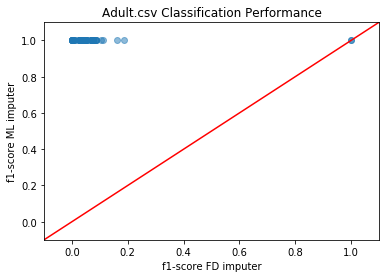

In [36]:
f1_fd = [y['f1'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'f1' in y.keys()]
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_fd, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score FD imputer',
      ylabel = 'f1-score ML imputer',
      xlim = [-0.1, 1.1],
      ylim  = [-0.1, 1.1])
fig.savefig('ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

## Plot MSE

In [16]:
mse_fd = [y['mse'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'mse' in y.keys()]
mse_ml = [y['mse'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'mse' in y.keys()]

In [17]:
rel_mse = []
for i, x in enumerate(mse_fd):
    if x != '':
        rel_mse.append(mse_fd[i]/mse_ml[i])
    else:
        rel_mse.append(np.nan)

Falls mse_fd / mse_ml > 1 ist, ist mse_ml kleiner als mse_fd um den Faktor, den man auf der y-Achse ablesen kann.
Generell ist diese Darstellung dubios, ich sollte die MSE lieber in einer Tabelle auffuehren.

[Text(0, 0.5, 'mse_fd / mse_ml'),
 (-0.1, 11),
 Text(0.5, 0, 'FD LHS combination'),
 Text(0.5, 1.0, 'Adult.csv Mean Squared Error of two imputers')]

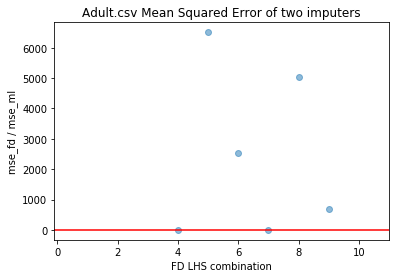

In [37]:
fig, ax = plt.subplots()
sc = plt.scatter(list(range(0, len(rel_mse))), 
                 rel_mse,
                 alpha=0.5)
plt.plot(np.linspace(-2, len(rel_mse)), [1]*50, c='red')
ax.set(title='Adult.csv Mean Squared Error of two imputers',
      xlabel = 'FD LHS combination',
      ylabel = 'mse_fd / mse_ml',
      xlim = [-0.1, 11])
#fig.savefig('ml-fd-regression.png', transparent=False,
           #dpi=320, bbox_inches='tight')

## Overfitting the ML imputer

continue here

In [19]:
overfitted_ml_imputer_results = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_validate,
                                                        df_validate,
                                                        fds,
                                                        continuous)

[0] 3


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:10:42,517 [INFO]  
========== start: fit model
2019-06-21 07:10:42,521 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:10:43,813 [INFO]  Epoch[0] Batch [0-814]	Speed: 10206.49 samples/sec	cross-entropy=0.036387	3-accuracy=0.000000
2019-06-21 07:10:45,003 [INFO]  Epoch[0] Train-cross-entropy=0.024446
2019-06-21 07:10:45,009 [INFO]  Epoch[0] Train-3-accuracy=0.000000
2019-06-21 07:10:45,013 [INFO]  Epoch[0] Time cost=2.485
2019-06-21 07:10:45,019 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:10:45,202 [INFO]  Epoch[0] Validation-cross-entropy=0.000198
2019-06

[0] 11


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:11:09,915 [INFO]  
========== start: fit model
2019-06-21 07:11:09,920 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:11:11,081 [INFO]  Epoch[0] Batch [0-814]	Speed: 11397.13 samples/sec	cross-entropy=0.558056	11-accuracy=0.000000
2019-06-21 07:11:12,108 [INFO]  Epoch[0] Train-cross-entropy=0.322450
2019-06-21 07:11:12,452 [INFO]  Epoch[0] Train-11-accuracy=0.000000
2019-06-21 07:11:12,462 [INFO]  Epoch[0] Time cost=2.529
2019-06-21 07:11:12,483 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:11:12,754 [INFO]  Epoch[0] Validation-cross-entropy=0.187201
2019-

[0] 13


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:11:25,010 [INFO]  
========== start: fit model
2019-06-21 07:11:25,015 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:11:26,081 [INFO]  Epoch[0] Batch [0-814]	Speed: 12373.54 samples/sec	cross-entropy=0.396541	13-accuracy=0.000000
2019-06-21 07:11:27,872 [INFO]  Epoch[0] Train-cross-entropy=0.198616
2019-06-21 07:11:27,876 [INFO]  Epoch[0] Train-13-accuracy=0.000000
2019-06-21 07:11:27,879 [INFO]  Epoch[0] Time cost=2.855
2019-06-21 07:11:27,886 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:11:28,002 [INFO]  Epoch[0] Validation-cross-entropy=0.000185
2019-

[0] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:11:35,912 [INFO]  
========== start: fit model
2019-06-21 07:11:35,916 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:11:36,999 [INFO]  Epoch[0] Batch [0-814]	Speed: 12169.64 samples/sec	cross-entropy=0.077257	12-accuracy=0.000000
2019-06-21 07:11:38,672 [INFO]  Epoch[0] Train-cross-entropy=0.046792
2019-06-21 07:11:38,676 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:11:38,680 [INFO]  Epoch[0] Time cost=2.755
2019-06-21 07:11:38,688 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:11:38,815 [INFO]  Epoch[0] Validation-cross-entropy=0.014683
2019-

[13, 1, 2, 3, 4, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:11:53,859 [INFO]  
========== start: fit model
2019-06-21 07:11:53,863 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:12:02,808 [INFO]  Epoch[0] Batch [0-814]	Speed: 1460.91 samples/sec	cross-entropy=0.163257	12-accuracy=0.000000
2019-06-21 07:12:11,436 [INFO]  Epoch[0] Train-cross-entropy=0.097625
2019-06-21 07:12:11,441 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:12:11,444 [INFO]  Epoch[0] Time cost=17.573
2019-06-21 07:12:11,455 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:12:13,276 [INFO]  Epoch[0] Validation-cross-entropy=0.001889
2019-

[13, 1, 3, 4, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:15:10,570 [INFO]  
========== start: fit model
2019-06-21 07:15:10,574 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:15:19,505 [INFO]  Epoch[0] Batch [0-814]	Speed: 1462.58 samples/sec	cross-entropy=0.140687	12-accuracy=0.000000
2019-06-21 07:15:28,744 [INFO]  Epoch[0] Train-cross-entropy=0.082142
2019-06-21 07:15:28,749 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:15:28,755 [INFO]  Epoch[0] Time cost=18.173
2019-06-21 07:15:28,764 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:15:30,747 [INFO]  Epoch[0] Validation-cross-entropy=0.002262
2019-

[13, 1, 3, 4, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:18:43,305 [INFO]  
========== start: fit model
2019-06-21 07:18:43,569 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:18:52,443 [INFO]  Epoch[0] Batch [0-814]	Speed: 1476.26 samples/sec	cross-entropy=0.140253	12-accuracy=0.000000
2019-06-21 07:19:01,574 [INFO]  Epoch[0] Train-cross-entropy=0.090088
2019-06-21 07:19:01,577 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:19:01,581 [INFO]  Epoch[0] Time cost=17.999
2019-06-21 07:19:01,594 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:19:03,445 [INFO]  Epoch[0] Validation-cross-entropy=0.004283
2019-

[13, 1, 2, 3, 5, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:20:51,601 [INFO]  
========== start: fit model
2019-06-21 07:20:51,604 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:21:01,535 [INFO]  Epoch[0] Batch [0-814]	Speed: 1316.64 samples/sec	cross-entropy=0.160675	12-accuracy=0.000000
2019-06-21 07:21:11,862 [INFO]  Epoch[0] Train-cross-entropy=0.101770
2019-06-21 07:21:11,865 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:21:11,869 [INFO]  Epoch[0] Time cost=20.251
2019-06-21 07:21:11,876 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:21:13,723 [INFO]  Epoch[0] Validation-cross-entropy=0.003167
2019-

[13, 1, 3, 5, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:23:13,279 [INFO]  
========== start: fit model
2019-06-21 07:23:13,284 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:23:23,298 [INFO]  Epoch[0] Batch [0-814]	Speed: 1304.52 samples/sec	cross-entropy=0.171395	12-accuracy=0.000000
2019-06-21 07:23:32,698 [INFO]  Epoch[0] Train-cross-entropy=0.097917
2019-06-21 07:23:32,702 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:23:32,708 [INFO]  Epoch[0] Time cost=19.417
2019-06-21 07:23:32,718 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:23:34,652 [INFO]  Epoch[0] Validation-cross-entropy=0.006461
2019-

[13, 1, 3, 5, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:26:12,783 [INFO]  
========== start: fit model
2019-06-21 07:26:12,787 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:26:22,720 [INFO]  Epoch[0] Batch [0-814]	Speed: 1316.78 samples/sec	cross-entropy=0.157430	12-accuracy=0.000000
2019-06-21 07:26:33,051 [INFO]  Epoch[0] Train-cross-entropy=0.095332
2019-06-21 07:26:33,055 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-06-21 07:26:33,060 [INFO]  Epoch[0] Time cost=20.258
2019-06-21 07:26:33,070 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:26:35,399 [INFO]  Epoch[0] Validation-cross-entropy=0.003924
2019-

[0] 1


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-21 07:29:58,834 [INFO]  
========== start: fit model
2019-06-21 07:29:58,837 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:30:00,152 [INFO]  Epoch[0] Batch [0-814]	Speed: 10000.17 samples/sec	cross-entropy=0.152476	1-accuracy=0.000000
2019-06-21 07:30:01,421 [INFO]  Epoch[0] Train-cross-entropy=0.076463
2019-06-21 07:30:01,425 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-06-21 07:30:01,430 [INFO]  Epoch[0] Time cost=2.585
2019-06-21 07:30:01,440 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:30:01,595 [INFO]  Epoch[0] Validation-cross-entropy=0.000370
2019-06

2019-06-21 07:30:18,630 [INFO]  CategoricalEncoder for column 14                                found only 15 occurrences of value Cambodia


[0] 14


2019-06-21 07:30:18,635 [INFO]  CategoricalEncoder for column 14                                found only 14 occurrences of value Laos
2019-06-21 07:30:18,639 [INFO]  CategoricalEncoder for column 14                                found only 14 occurrences of value Outlying-US(Guam-USVI-etc)
2019-06-21 07:30:18,648 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Thailand
2019-06-21 07:30:18,652 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Yugoslavia
2019-06-21 07:30:18,657 [INFO]  CategoricalEncoder for column 14                                found only 13 occurrences of value Trinadad&Tobago
2019-06-21 07:30:18,661 [INFO]  CategoricalEncoder for column 14                                found only 12 occurrences of value Hungary
2019-06-21 07:30:18,668 [INFO]  CategoricalEncoder for column 14                                found only 12 occurrences of value Hondura

[0] 4


2019-06-21 07:38:21,342 [INFO]  
========== start: fit model
2019-06-21 07:38:21,345 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:38:35,445 [INFO]  Epoch[0] Batch [0-814]	Speed: 926.07 samples/sec	cross-entropy=0.272886	4-accuracy=0.962347
2019-06-21 07:38:49,749 [INFO]  Epoch[0] Train-cross-entropy=0.143666
2019-06-21 07:38:49,753 [INFO]  Epoch[0] Train-4-accuracy=0.981112
2019-06-21 07:38:49,758 [INFO]  Epoch[0] Time cost=28.408
2019-06-21 07:38:49,778 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:38:51,913 [INFO]  Epoch[0] Validation-cross-entropy=0.007385
2019-06-21 07:38:51,916 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-06-21 07:39:07,163 [INFO]  Epoch[1] Batch [0-814]	Speed: 855.78 samples/sec	cross-entropy=0.004947	4-accuracy=1.000000
2019-06-21 07:39:21,318 [INFO]  Epoch[1] Train-cross-entropy=0.003698
2019-06-21 07:39:21,321 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-06-21 07:39:21,325 [INFO]  Epoch[1] Time cost=29.405
20

[5] 4


2019-06-21 07:43:46,946 [INFO]  
========== start: fit model
2019-06-21 07:43:46,950 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:44:00,944 [INFO]  Epoch[0] Batch [0-814]	Speed: 933.66 samples/sec	cross-entropy=0.183061	4-accuracy=0.977147
2019-06-21 07:44:14,860 [INFO]  Epoch[0] Train-cross-entropy=0.095165
2019-06-21 07:44:14,864 [INFO]  Epoch[0] Train-4-accuracy=0.988560
2019-06-21 07:44:14,868 [INFO]  Epoch[0] Time cost=27.911
2019-06-21 07:44:14,882 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:44:16,932 [INFO]  Epoch[0] Validation-cross-entropy=0.003677
2019-06-21 07:44:16,935 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-06-21 07:44:31,798 [INFO]  Epoch[1] Batch [0-814]	Speed: 878.03 samples/sec	cross-entropy=0.002439	4-accuracy=1.000000
2019-06-21 07:44:46,383 [INFO]  Epoch[1] Train-cross-entropy=0.001814
2019-06-21 07:44:46,388 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-06-21 07:44:46,391 [INFO]  Epoch[1] Time cost=29.453
20

[0] 5


2019-06-21 07:49:10,234 [INFO]  
========== start: fit model
2019-06-21 07:49:10,239 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:49:25,070 [INFO]  Epoch[0] Batch [0-814]	Speed: 881.06 samples/sec	cross-entropy=0.770807	5-accuracy=0.841641
2019-06-21 07:49:39,974 [INFO]  Epoch[0] Train-cross-entropy=0.451293
2019-06-21 07:49:39,980 [INFO]  Epoch[0] Train-5-accuracy=0.917115
2019-06-21 07:49:39,984 [INFO]  Epoch[0] Time cost=29.739
2019-06-21 07:49:40,002 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:49:42,228 [INFO]  Epoch[0] Validation-cross-entropy=0.070231
2019-06-21 07:49:42,233 [INFO]  Epoch[0] Validation-5-accuracy=0.998468
2019-06-21 07:49:56,104 [INFO]  Epoch[1] Batch [0-814]	Speed: 940.93 samples/sec	cross-entropy=0.049030	5-accuracy=0.998390
2019-06-21 07:50:10,071 [INFO]  Epoch[1] Train-cross-entropy=0.036850
2019-06-21 07:50:10,077 [INFO]  Epoch[1] Train-5-accuracy=0.998464
2019-06-21 07:50:10,082 [INFO]  Epoch[1] Time cost=27.846
20

[4] 5


2019-06-21 07:54:49,332 [INFO]  
========== start: fit model
2019-06-21 07:54:49,336 [WARNING]  Already bound, ignoring bind()
2019-06-21 07:55:02,480 [INFO]  Epoch[0] Batch [0-814]	Speed: 993.74 samples/sec	cross-entropy=0.222164	5-accuracy=0.990644
2019-06-21 07:55:16,069 [INFO]  Epoch[0] Train-cross-entropy=0.115334
2019-06-21 07:55:16,073 [INFO]  Epoch[0] Train-5-accuracy=0.995316
2019-06-21 07:55:16,076 [INFO]  Epoch[0] Time cost=26.732
2019-06-21 07:55:16,090 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 07:55:18,236 [INFO]  Epoch[0] Validation-cross-entropy=0.004394
2019-06-21 07:55:18,241 [INFO]  Epoch[0] Validation-5-accuracy=1.000000
2019-06-21 07:55:31,420 [INFO]  Epoch[1] Batch [0-814]	Speed: 990.28 samples/sec	cross-entropy=0.002996	5-accuracy=1.000000
2019-06-21 07:55:44,524 [INFO]  Epoch[1] Train-cross-entropy=0.002241
2019-06-21 07:55:44,527 [INFO]  Epoch[1] Train-5-accuracy=1.000000
2019-06-21 07:55:44,531 [INFO]  Epoch[1] Time cost=26.286
20

[0] 7


2019-06-21 07:59:53,145 [INFO]  
========== start: fit model
2019-06-21 07:59:53,150 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:00:11,966 [INFO]  Epoch[0] Batch [0-814]	Speed: 694.17 samples/sec	cross-entropy=0.217311	7-accuracy=0.981595
2019-06-21 08:00:31,035 [INFO]  Epoch[0] Train-cross-entropy=0.113056
2019-06-21 08:00:31,041 [INFO]  Epoch[0] Train-7-accuracy=0.990633
2019-06-21 08:00:31,045 [INFO]  Epoch[0] Time cost=37.883
2019-06-21 08:00:31,057 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:00:33,732 [INFO]  Epoch[0] Validation-cross-entropy=0.004098
2019-06-21 08:00:33,737 [INFO]  Epoch[0] Validation-7-accuracy=1.000000
2019-06-21 08:00:50,287 [INFO]  Epoch[1] Batch [0-814]	Speed: 788.16 samples/sec	cross-entropy=0.002945	7-accuracy=0.999923
2019-06-21 08:01:12,809 [INFO]  Epoch[1] Train-cross-entropy=0.002196
2019-06-21 08:01:12,816 [INFO]  Epoch[1] Train-7-accuracy=0.999962
2019-06-21 08:01:12,823 [INFO]  Epoch[1] Time cost=39.082
20

[0] 2


2019-06-21 08:06:00,882 [WARNING]  Test set does not contain any ocurrences of values [Without-pay, Never-worked] in column [2], consider using a more representative test set.
2019-06-21 08:06:00,891 [INFO]  
========== start: fit model
2019-06-21 08:06:00,896 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:06:15,017 [INFO]  Epoch[0] Batch [0-814]	Speed: 924.73 samples/sec	cross-entropy=0.130592	2-accuracy=0.976610
2019-06-21 08:06:28,744 [INFO]  Epoch[0] Train-cross-entropy=0.069073
2019-06-21 08:06:28,748 [INFO]  Epoch[0] Train-2-accuracy=0.988061
2019-06-21 08:06:28,752 [INFO]  Epoch[0] Time cost=27.850
2019-06-21 08:06:28,767 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:06:30,970 [INFO]  Epoch[0] Validation-cross-entropy=0.003263
2019-06-21 08:06:30,975 [INFO]  Epoch[0] Validation-2-accuracy=1.000000
2019-06-21 08:06:44,929 [INFO]  Epoch[1] Batch [0-814]	Speed: 934.89 samples/sec	cross-entropy=0.002964	2-accuracy=0.999770
2019-06-21 08:06:58,1

[0] 6


2019-06-21 08:11:09,578 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-21 08:11:09,591 [INFO]  
========== start: fit model
2019-06-21 08:11:09,595 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:11:22,289 [INFO]  Epoch[0] Batch [0-814]	Speed: 1028.10 samples/sec	cross-entropy=0.126133	6-accuracy=0.980828
2019-06-21 08:11:34,771 [INFO]  Epoch[0] Train-cross-entropy=0.066945
2019-06-21 08:11:34,774 [INFO]  Epoch[0] Train-6-accuracy=0.990057
2019-06-21 08:11:34,780 [INFO]  Epoch[0] Time cost=25.178
2019-06-21 08:11:34,789 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:11:37,146 [INFO]  Epoch[0] Validation-cross-entropy=0.003317
2019-06-21 08:11:37,153 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-21 08:11:50,163 [INFO]  Epoch[1] Batch [0-814]	Speed: 1002.81 samples/sec	cross-entropy=0.003110	6-accuracy=0.999540
2019-06-21 08:12:02,740 [IN

[11, 13, 1, 3, 7, 8] 6


2019-06-21 08:15:55,595 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-21 08:15:55,605 [INFO]  
========== start: fit model
2019-06-21 08:15:55,610 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:16:08,687 [INFO]  Epoch[0] Batch [0-814]	Speed: 998.64 samples/sec	cross-entropy=0.154082	6-accuracy=0.972239
2019-06-21 08:16:24,464 [INFO]  Epoch[0] Train-cross-entropy=0.084348
2019-06-21 08:16:24,468 [INFO]  Epoch[0] Train-6-accuracy=0.985757
2019-06-21 08:16:24,472 [INFO]  Epoch[0] Time cost=28.852
2019-06-21 08:16:24,481 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:16:27,186 [INFO]  Epoch[0] Validation-cross-entropy=0.007095
2019-06-21 08:16:27,191 [INFO]  Epoch[0] Validation-6-accuracy=0.999387
2019-06-21 08:16:41,152 [INFO]  Epoch[1] Batch [0-814]	Speed: 934.27 samples/sec	cross-entropy=0.005858	6-accuracy=0.999463
2019-06-21 08:16:56,188 [INFO

[13, 1, 3, 4, 7, 8] 6


2019-06-21 08:21:07,177 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-21 08:21:07,190 [INFO]  
========== start: fit model
2019-06-21 08:21:07,196 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:21:19,834 [INFO]  Epoch[0] Batch [0-814]	Speed: 1033.56 samples/sec	cross-entropy=0.172882	6-accuracy=0.965798
2019-06-21 08:21:33,096 [INFO]  Epoch[0] Train-cross-entropy=0.095264
2019-06-21 08:21:33,101 [INFO]  Epoch[0] Train-6-accuracy=0.982494
2019-06-21 08:21:33,108 [INFO]  Epoch[0] Time cost=25.906
2019-06-21 08:21:33,122 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:21:35,250 [INFO]  Epoch[0] Validation-cross-entropy=0.007425
2019-06-21 08:21:35,257 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-21 08:21:47,491 [INFO]  Epoch[1] Batch [0-814]	Speed: 1067.05 samples/sec	cross-entropy=0.007212	6-accuracy=0.999387
2019-06-21 08:21:59,749 [IN

[13, 1, 3, 5, 7, 8] 6


2019-06-21 08:25:55,896 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-21 08:25:55,908 [INFO]  
========== start: fit model
2019-06-21 08:25:55,912 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:26:08,372 [INFO]  Epoch[0] Batch [0-814]	Speed: 1048.13 samples/sec	cross-entropy=0.153758	6-accuracy=0.970169
2019-06-21 08:26:20,824 [INFO]  Epoch[0] Train-cross-entropy=0.084170
2019-06-21 08:26:20,829 [INFO]  Epoch[0] Train-6-accuracy=0.984721
2019-06-21 08:26:20,833 [INFO]  Epoch[0] Time cost=24.910
2019-06-21 08:26:20,846 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:26:23,034 [INFO]  Epoch[0] Validation-cross-entropy=0.005894
2019-06-21 08:26:23,039 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-21 08:26:35,285 [INFO]  Epoch[1] Batch [0-814]	Speed: 1066.46 samples/sec	cross-entropy=0.005796	6-accuracy=0.999387
2019-06-21 08:26:47,428 [IN

[0] 8


2019-06-21 08:30:33,339 [INFO]  
========== start: fit model
2019-06-21 08:30:33,343 [WARNING]  Already bound, ignoring bind()
2019-06-21 08:30:45,562 [INFO]  Epoch[0] Batch [0-814]	Speed: 1068.76 samples/sec	cross-entropy=0.121750	8-accuracy=0.983896
2019-06-21 08:30:57,769 [INFO]  Epoch[0] Train-cross-entropy=0.063189
2019-06-21 08:30:57,774 [INFO]  Epoch[0] Train-8-accuracy=0.991938
2019-06-21 08:30:57,782 [INFO]  Epoch[0] Time cost=24.430
2019-06-21 08:30:57,792 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 08:31:00,009 [INFO]  Epoch[0] Validation-cross-entropy=0.002497
2019-06-21 08:31:00,013 [INFO]  Epoch[0] Validation-8-accuracy=1.000000
2019-06-21 08:31:12,905 [INFO]  Epoch[1] Batch [0-814]	Speed: 1012.78 samples/sec	cross-entropy=0.001711	8-accuracy=1.000000
2019-06-21 08:31:26,122 [INFO]  Epoch[1] Train-cross-entropy=0.001282
2019-06-21 08:31:26,128 [INFO]  Epoch[1] Train-8-accuracy=1.000000
2019-06-21 08:31:26,136 [INFO]  Epoch[1] Time cost=26.117


[0] 9


2019-06-21 09:56:04,129 [INFO]  
========== start: fit model
2019-06-21 09:56:04,135 [WARNING]  Already bound, ignoring bind()
2019-06-21 09:56:14,725 [INFO]  Epoch[0] Batch [0-814]	Speed: 1232.84 samples/sec	cross-entropy=0.086835	9-accuracy=0.983589
2019-06-21 09:56:26,638 [INFO]  Epoch[0] Train-cross-entropy=0.045522
2019-06-21 09:56:26,643 [INFO]  Epoch[0] Train-9-accuracy=0.991784
2019-06-21 09:56:26,647 [INFO]  Epoch[0] Time cost=22.506
2019-06-21 09:56:26,657 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 09:56:28,613 [INFO]  Epoch[0] Validation-cross-entropy=0.002176
2019-06-21 09:56:28,617 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 09:56:38,951 [INFO]  Epoch[1] Batch [0-814]	Speed: 1263.07 samples/sec	cross-entropy=0.001466	9-accuracy=1.000000
2019-06-21 09:56:49,313 [INFO]  Epoch[1] Train-cross-entropy=0.001108
2019-06-21 09:56:49,319 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 09:56:49,325 [INFO]  Epoch[1] Time cost=20.704


[11, 12, 13, 3, 7, 8] 9


2019-06-21 10:00:29,002 [INFO]  
========== start: fit model
2019-06-21 10:00:29,007 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:00:40,226 [INFO]  Epoch[0] Batch [0-814]	Speed: 1164.77 samples/sec	cross-entropy=0.137310	9-accuracy=0.965031
2019-06-21 10:00:51,002 [INFO]  Epoch[0] Train-cross-entropy=0.075123
2019-06-21 10:00:51,006 [INFO]  Epoch[0] Train-9-accuracy=0.982264
2019-06-21 10:00:51,009 [INFO]  Epoch[0] Time cost=21.994
2019-06-21 10:00:51,016 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:00:52,940 [INFO]  Epoch[0] Validation-cross-entropy=0.006688
2019-06-21 10:00:52,944 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:01:03,413 [INFO]  Epoch[1] Batch [0-814]	Speed: 1247.42 samples/sec	cross-entropy=0.004292	9-accuracy=1.000000
2019-06-21 10:01:14,547 [INFO]  Epoch[1] Train-cross-entropy=0.003228
2019-06-21 10:01:14,553 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:01:14,558 [INFO]  Epoch[1] Time cost=21.611


[12, 13, 15, 3, 4, 6, 8] 9


2019-06-21 10:04:55,884 [INFO]  
========== start: fit model
2019-06-21 10:04:55,889 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:05:07,548 [INFO]  Epoch[0] Batch [0-814]	Speed: 1121.18 samples/sec	cross-entropy=0.153733	9-accuracy=0.958359
2019-06-21 10:05:19,005 [INFO]  Epoch[0] Train-cross-entropy=0.084827
2019-06-21 10:05:19,010 [INFO]  Epoch[0] Train-9-accuracy=0.978770
2019-06-21 10:05:19,014 [INFO]  Epoch[0] Time cost=23.119
2019-06-21 10:05:19,027 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:05:21,191 [INFO]  Epoch[0] Validation-cross-entropy=0.008118
2019-06-21 10:05:21,195 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:05:32,265 [INFO]  Epoch[1] Batch [0-814]	Speed: 1179.26 samples/sec	cross-entropy=0.005382	9-accuracy=1.000000
2019-06-21 10:05:44,742 [INFO]  Epoch[1] Train-cross-entropy=0.004022
2019-06-21 10:05:44,747 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:05:44,750 [INFO]  Epoch[1] Time cost=23.550


[12, 13, 15, 3, 5, 6, 8] 9


2019-06-21 10:09:22,639 [INFO]  
========== start: fit model
2019-06-21 10:09:22,642 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:09:34,833 [INFO]  Epoch[0] Batch [0-814]	Speed: 1072.32 samples/sec	cross-entropy=0.143959	9-accuracy=0.962117
2019-06-21 10:09:46,876 [INFO]  Epoch[0] Train-cross-entropy=0.079065
2019-06-21 10:09:46,880 [INFO]  Epoch[0] Train-9-accuracy=0.980689
2019-06-21 10:09:46,887 [INFO]  Epoch[0] Time cost=24.237
2019-06-21 10:09:46,897 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:09:49,204 [INFO]  Epoch[0] Validation-cross-entropy=0.007105
2019-06-21 10:09:49,211 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:10:00,433 [INFO]  Epoch[1] Batch [0-814]	Speed: 1163.40 samples/sec	cross-entropy=0.004685	9-accuracy=1.000000
2019-06-21 10:10:13,151 [INFO]  Epoch[1] Train-cross-entropy=0.003528
2019-06-21 10:10:13,154 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:10:13,158 [INFO]  Epoch[1] Time cost=23.941


[13, 1, 3, 4] 9


2019-06-21 10:13:43,852 [INFO]  
========== start: fit model
2019-06-21 10:13:43,856 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:13:55,321 [INFO]  Epoch[0] Batch [0-814]	Speed: 1138.93 samples/sec	cross-entropy=0.099517	9-accuracy=0.977607
2019-06-21 10:14:07,511 [INFO]  Epoch[0] Train-cross-entropy=0.052763
2019-06-21 10:14:07,522 [INFO]  Epoch[0] Train-9-accuracy=0.988713
2019-06-21 10:14:07,526 [INFO]  Epoch[0] Time cost=23.663
2019-06-21 10:14:07,535 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:14:10,798 [INFO]  Epoch[0] Validation-cross-entropy=0.003140
2019-06-21 10:14:10,803 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:14:24,707 [INFO]  Epoch[1] Batch [0-814]	Speed: 939.82 samples/sec	cross-entropy=0.002117	9-accuracy=1.000000
2019-06-21 10:14:38,162 [INFO]  Epoch[1] Train-cross-entropy=0.001587
2019-06-21 10:14:38,174 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:14:38,187 [INFO]  Epoch[1] Time cost=27.381
2

[13, 1, 3, 5] 9


2019-06-21 10:18:26,474 [INFO]  
========== start: fit model
2019-06-21 10:18:26,479 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:18:38,296 [INFO]  Epoch[0] Batch [0-814]	Speed: 1104.89 samples/sec	cross-entropy=0.085765	9-accuracy=0.982209
2019-06-21 10:18:48,772 [INFO]  Epoch[0] Train-cross-entropy=0.045036
2019-06-21 10:18:48,776 [INFO]  Epoch[0] Train-9-accuracy=0.991055
2019-06-21 10:18:48,780 [INFO]  Epoch[0] Time cost=22.294
2019-06-21 10:18:48,788 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:18:51,048 [INFO]  Epoch[0] Validation-cross-entropy=0.002125
2019-06-21 10:18:51,053 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:19:03,303 [INFO]  Epoch[1] Batch [0-814]	Speed: 1065.68 samples/sec	cross-entropy=0.001430	9-accuracy=1.000000
2019-06-21 10:19:15,024 [INFO]  Epoch[1] Train-cross-entropy=0.001086
2019-06-21 10:19:15,028 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:19:15,034 [INFO]  Epoch[1] Time cost=23.975


[13, 1, 2, 3, 7] 9


2019-06-21 10:22:39,689 [INFO]  
========== start: fit model
2019-06-21 10:22:39,693 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:22:51,343 [INFO]  Epoch[0] Batch [0-814]	Speed: 1121.00 samples/sec	cross-entropy=0.139049	9-accuracy=0.964034
2019-06-21 10:23:03,172 [INFO]  Epoch[0] Train-cross-entropy=0.076802
2019-06-21 10:23:03,179 [INFO]  Epoch[0] Train-9-accuracy=0.981572
2019-06-21 10:23:03,199 [INFO]  Epoch[0] Time cost=23.499
2019-06-21 10:23:03,223 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:23:05,286 [INFO]  Epoch[0] Validation-cross-entropy=0.007238
2019-06-21 10:23:05,292 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:23:17,385 [INFO]  Epoch[1] Batch [0-814]	Speed: 1079.16 samples/sec	cross-entropy=0.005371	9-accuracy=0.999923
2019-06-21 10:23:29,599 [INFO]  Epoch[1] Train-cross-entropy=0.004079
2019-06-21 10:23:29,603 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-21 10:23:29,610 [INFO]  Epoch[1] Time cost=24.313


[13, 14, 3, 4, 7] 9


2019-06-21 10:26:56,958 [INFO]  
========== start: fit model
2019-06-21 10:26:56,962 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:27:10,478 [INFO]  Epoch[0] Batch [0-814]	Speed: 965.89 samples/sec	cross-entropy=0.150078	9-accuracy=0.959509
2019-06-21 10:27:21,423 [INFO]  Epoch[0] Train-cross-entropy=0.083131
2019-06-21 10:27:21,429 [INFO]  Epoch[0] Train-9-accuracy=0.979154
2019-06-21 10:27:21,433 [INFO]  Epoch[0] Time cost=24.465
2019-06-21 10:27:21,443 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:27:23,596 [INFO]  Epoch[0] Validation-cross-entropy=0.008523
2019-06-21 10:27:23,707 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:27:35,872 [INFO]  Epoch[1] Batch [0-814]	Speed: 1074.02 samples/sec	cross-entropy=0.005542	9-accuracy=1.000000
2019-06-21 10:27:46,599 [INFO]  Epoch[1] Train-cross-entropy=0.004144
2019-06-21 10:27:46,603 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:27:46,607 [INFO]  Epoch[1] Time cost=22.895
2

[13, 14, 3, 4, 6, 8] 9


2019-06-21 10:31:17,169 [INFO]  
========== start: fit model
2019-06-21 10:31:17,174 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:31:27,557 [INFO]  Epoch[0] Batch [0-814]	Speed: 1259.74 samples/sec	cross-entropy=0.163198	9-accuracy=0.954908
2019-06-21 10:31:37,921 [INFO]  Epoch[0] Train-cross-entropy=0.091403
2019-06-21 10:31:37,927 [INFO]  Epoch[0] Train-9-accuracy=0.976620
2019-06-21 10:31:37,933 [INFO]  Epoch[0] Time cost=20.752
2019-06-21 10:31:37,942 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:31:39,954 [INFO]  Epoch[0] Validation-cross-entropy=0.010082
2019-06-21 10:31:39,958 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:31:50,289 [INFO]  Epoch[1] Batch [0-814]	Speed: 1263.26 samples/sec	cross-entropy=0.006694	9-accuracy=1.000000
2019-06-21 10:32:00,617 [INFO]  Epoch[1] Train-cross-entropy=0.005014
2019-06-21 10:32:00,624 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:32:00,629 [INFO]  Epoch[1] Time cost=20.667


[13, 14, 3, 5, 7] 9


2019-06-21 10:35:20,659 [INFO]  
========== start: fit model
2019-06-21 10:35:20,663 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:35:30,902 [INFO]  Epoch[0] Batch [0-814]	Speed: 1275.18 samples/sec	cross-entropy=0.131617	9-accuracy=0.967178
2019-06-21 10:35:41,263 [INFO]  Epoch[0] Train-cross-entropy=0.072020
2019-06-21 10:35:41,634 [INFO]  Epoch[0] Train-9-accuracy=0.983185
2019-06-21 10:35:41,646 [INFO]  Epoch[0] Time cost=20.977
2019-06-21 10:35:41,670 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:35:43,847 [INFO]  Epoch[0] Validation-cross-entropy=0.006395
2019-06-21 10:35:43,853 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:35:54,245 [INFO]  Epoch[1] Batch [0-814]	Speed: 1256.54 samples/sec	cross-entropy=0.004195	9-accuracy=1.000000
2019-06-21 10:36:05,378 [INFO]  Epoch[1] Train-cross-entropy=0.003154
2019-06-21 10:36:05,381 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:36:05,386 [INFO]  Epoch[1] Time cost=21.526


[13, 14, 3, 5, 6, 8] 9


2019-06-21 10:39:41,473 [INFO]  
========== start: fit model
2019-06-21 10:39:41,477 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:39:53,829 [INFO]  Epoch[0] Batch [0-814]	Speed: 1057.12 samples/sec	cross-entropy=0.144886	9-accuracy=0.962500
2019-06-21 10:40:06,644 [INFO]  Epoch[0] Train-cross-entropy=0.080144
2019-06-21 10:40:06,650 [INFO]  Epoch[0] Train-9-accuracy=0.980613
2019-06-21 10:40:06,658 [INFO]  Epoch[0] Time cost=25.174
2019-06-21 10:40:06,674 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:40:09,150 [INFO]  Epoch[0] Validation-cross-entropy=0.007800
2019-06-21 10:40:09,155 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:40:22,021 [INFO]  Epoch[1] Batch [0-814]	Speed: 1014.22 samples/sec	cross-entropy=0.005159	9-accuracy=1.000000
2019-06-21 10:40:32,419 [INFO]  Epoch[1] Train-cross-entropy=0.003888
2019-06-21 10:40:32,423 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:40:32,428 [INFO]  Epoch[1] Time cost=23.269


[13, 14, 2, 3, 7] 9


2019-06-21 10:44:07,650 [INFO]  
========== start: fit model
2019-06-21 10:44:07,654 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:44:18,419 [INFO]  Epoch[0] Batch [0-814]	Speed: 1214.43 samples/sec	cross-entropy=0.152923	9-accuracy=0.956979
2019-06-21 10:44:29,411 [INFO]  Epoch[0] Train-cross-entropy=0.085258
2019-06-21 10:44:29,418 [INFO]  Epoch[0] Train-9-accuracy=0.977657
2019-06-21 10:44:29,426 [INFO]  Epoch[0] Time cost=21.763
2019-06-21 10:44:29,441 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:44:32,288 [INFO]  Epoch[0] Validation-cross-entropy=0.009180
2019-06-21 10:44:32,297 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 10:44:43,739 [INFO]  Epoch[1] Batch [0-814]	Speed: 1142.10 samples/sec	cross-entropy=0.006355	9-accuracy=1.000000
2019-06-21 10:44:54,490 [INFO]  Epoch[1] Train-cross-entropy=0.004773
2019-06-21 10:44:54,497 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:44:54,503 [INFO]  Epoch[1] Time cost=22.196


[13, 14, 3, 6, 7] 9


2019-06-21 10:48:38,525 [INFO]  
========== start: fit model
2019-06-21 10:48:38,530 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:48:48,991 [INFO]  Epoch[0] Batch [0-814]	Speed: 1248.90 samples/sec	cross-entropy=0.154726	9-accuracy=0.958052
2019-06-21 10:49:00,188 [INFO]  Epoch[0] Train-cross-entropy=0.086231
2019-06-21 10:49:00,198 [INFO]  Epoch[0] Train-9-accuracy=0.978194
2019-06-21 10:49:00,204 [INFO]  Epoch[0] Time cost=21.667
2019-06-21 10:49:00,215 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:49:02,528 [INFO]  Epoch[0] Validation-cross-entropy=0.009238
2019-06-21 10:49:02,804 [INFO]  Epoch[0] Validation-9-accuracy=0.999694
2019-06-21 10:49:16,723 [INFO]  Epoch[1] Batch [0-814]	Speed: 940.44 samples/sec	cross-entropy=0.006071	9-accuracy=1.000000
2019-06-21 10:49:30,687 [INFO]  Epoch[1] Train-cross-entropy=0.004537
2019-06-21 10:49:30,691 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 10:49:30,695 [INFO]  Epoch[1] Time cost=27.870
2

[13, 14, 3, 7, 8] 9


2019-06-21 10:52:52,534 [INFO]  
========== start: fit model
2019-06-21 10:52:52,667 [WARNING]  Already bound, ignoring bind()
2019-06-21 10:53:03,669 [INFO]  Epoch[0] Batch [0-814]	Speed: 1189.82 samples/sec	cross-entropy=0.149424	9-accuracy=0.960353
2019-06-21 10:53:14,623 [INFO]  Epoch[0] Train-cross-entropy=0.082908
2019-06-21 10:53:14,627 [INFO]  Epoch[0] Train-9-accuracy=0.979538
2019-06-21 10:53:14,631 [INFO]  Epoch[0] Time cost=21.948
2019-06-21 10:53:14,638 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 10:53:17,507 [INFO]  Epoch[0] Validation-cross-entropy=0.008695
2019-06-21 10:53:17,513 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:05:56,557 [INFO]  Epoch[1] Batch [0-814]	Speed: 0.58 samples/sec	cross-entropy=0.005602	9-accuracy=1.000000
2019-06-21 17:06:06,224 [INFO]  Epoch[1] Train-cross-entropy=0.004191
2019-06-21 17:06:06,228 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:06:06,231 [INFO]  Epoch[1] Time cost=22368.713


[10, 13, 14, 15, 3, 7] 9


2019-06-21 17:09:03,968 [INFO]  
========== start: fit model
2019-06-21 17:09:03,974 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:09:13,984 [INFO]  Epoch[0] Batch [0-814]	Speed: 1306.73 samples/sec	cross-entropy=0.173853	9-accuracy=0.951687
2019-06-21 17:09:23,071 [INFO]  Epoch[0] Train-cross-entropy=0.098848
2019-06-21 17:09:23,075 [INFO]  Epoch[0] Train-9-accuracy=0.974470
2019-06-21 17:09:23,079 [INFO]  Epoch[0] Time cost=19.097
2019-06-21 17:09:23,084 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:09:24,694 [INFO]  Epoch[0] Validation-cross-entropy=0.012636
2019-06-21 17:09:24,697 [INFO]  Epoch[0] Validation-9-accuracy=0.999694
2019-06-21 17:09:33,285 [INFO]  Epoch[1] Batch [0-814]	Speed: 1519.00 samples/sec	cross-entropy=0.008308	9-accuracy=0.999847
2019-06-21 17:09:41,834 [INFO]  Epoch[1] Train-cross-entropy=0.006189
2019-06-21 17:09:41,838 [INFO]  Epoch[1] Train-9-accuracy=0.999923
2019-06-21 17:09:41,842 [INFO]  Epoch[1] Time cost=17.142


[13, 15, 2, 3, 4, 6, 8] 9


2019-06-21 17:12:40,302 [INFO]  
========== start: fit model
2019-06-21 17:12:40,305 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:12:49,478 [INFO]  Epoch[0] Batch [0-814]	Speed: 1422.37 samples/sec	cross-entropy=0.171685	9-accuracy=0.950997
2019-06-21 17:12:59,425 [INFO]  Epoch[0] Train-cross-entropy=0.096221
2019-06-21 17:12:59,430 [INFO]  Epoch[0] Train-9-accuracy=0.974701
2019-06-21 17:12:59,435 [INFO]  Epoch[0] Time cost=19.125
2019-06-21 17:12:59,446 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:13:01,597 [INFO]  Epoch[0] Validation-cross-entropy=0.010382
2019-06-21 17:13:01,600 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:13:11,365 [INFO]  Epoch[1] Batch [0-814]	Speed: 1335.61 samples/sec	cross-entropy=0.007035	9-accuracy=1.000000
2019-06-21 17:13:22,144 [INFO]  Epoch[1] Train-cross-entropy=0.005253
2019-06-21 17:13:22,148 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:13:22,151 [INFO]  Epoch[1] Time cost=20.549


[13, 15, 2, 3, 5, 6, 8] 9


2019-06-21 17:16:51,649 [INFO]  
========== start: fit model
2019-06-21 17:16:51,754 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:17:00,910 [INFO]  Epoch[0] Batch [0-814]	Speed: 1429.03 samples/sec	cross-entropy=0.154455	9-accuracy=0.957975
2019-06-21 17:17:10,683 [INFO]  Epoch[0] Train-cross-entropy=0.085607
2019-06-21 17:17:10,687 [INFO]  Epoch[0] Train-9-accuracy=0.978424
2019-06-21 17:17:10,690 [INFO]  Epoch[0] Time cost=18.924
2019-06-21 17:17:10,787 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:17:12,519 [INFO]  Epoch[0] Validation-cross-entropy=0.008206
2019-06-21 17:17:12,523 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:17:21,580 [INFO]  Epoch[1] Batch [0-814]	Speed: 1442.12 samples/sec	cross-entropy=0.005564	9-accuracy=1.000000
2019-06-21 17:17:30,706 [INFO]  Epoch[1] Train-cross-entropy=0.004184
2019-06-21 17:17:30,710 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:17:30,714 [INFO]  Epoch[1] Time cost=18.182


[12, 14, 2, 3, 4, 6, 8] 9


2019-06-21 17:20:29,377 [INFO]  
========== start: fit model
2019-06-21 17:20:29,381 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:20:38,903 [INFO]  Epoch[0] Batch [0-814]	Speed: 1370.70 samples/sec	cross-entropy=0.177159	9-accuracy=0.947853
2019-06-21 17:20:48,155 [INFO]  Epoch[0] Train-cross-entropy=0.100741
2019-06-21 17:20:48,167 [INFO]  Epoch[0] Train-9-accuracy=0.972858
2019-06-21 17:20:48,170 [INFO]  Epoch[0] Time cost=18.784
2019-06-21 17:20:48,177 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:20:50,030 [INFO]  Epoch[0] Validation-cross-entropy=0.012691
2019-06-21 17:20:50,035 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:20:59,302 [INFO]  Epoch[1] Batch [0-814]	Speed: 1408.39 samples/sec	cross-entropy=0.008492	9-accuracy=0.999923
2019-06-21 17:21:08,886 [INFO]  Epoch[1] Train-cross-entropy=0.006346
2019-06-21 17:21:08,891 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-21 17:21:08,895 [INFO]  Epoch[1] Time cost=18.856


[12, 14, 2, 3, 5, 6, 8] 9


2019-06-21 17:24:08,829 [INFO]  
========== start: fit model
2019-06-21 17:24:08,832 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:24:18,037 [INFO]  Epoch[0] Batch [0-814]	Speed: 1418.11 samples/sec	cross-entropy=0.161134	9-accuracy=0.954908
2019-06-21 17:24:27,317 [INFO]  Epoch[0] Train-cross-entropy=0.090553
2019-06-21 17:24:27,643 [INFO]  Epoch[0] Train-9-accuracy=0.976543
2019-06-21 17:24:27,653 [INFO]  Epoch[0] Time cost=18.816
2019-06-21 17:24:27,670 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:24:29,473 [INFO]  Epoch[0] Validation-cross-entropy=0.010282
2019-06-21 17:24:29,476 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:24:39,164 [INFO]  Epoch[1] Batch [0-814]	Speed: 1347.06 samples/sec	cross-entropy=0.006863	9-accuracy=1.000000
2019-06-21 17:24:48,526 [INFO]  Epoch[1] Train-cross-entropy=0.005141
2019-06-21 17:24:48,530 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:24:48,535 [INFO]  Epoch[1] Time cost=19.055


[12, 15, 2, 3, 4, 6, 8] 9


2019-06-21 17:27:51,023 [INFO]  
========== start: fit model
2019-06-21 17:27:51,027 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:28:00,315 [INFO]  Epoch[0] Batch [0-814]	Speed: 1405.77 samples/sec	cross-entropy=0.169607	9-accuracy=0.951610
2019-06-21 17:28:10,020 [INFO]  Epoch[0] Train-cross-entropy=0.095052
2019-06-21 17:28:10,024 [INFO]  Epoch[0] Train-9-accuracy=0.975046
2019-06-21 17:28:10,030 [INFO]  Epoch[0] Time cost=18.997
2019-06-21 17:28:10,040 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:28:11,800 [INFO]  Epoch[0] Validation-cross-entropy=0.010405
2019-06-21 17:28:11,805 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:28:21,234 [INFO]  Epoch[1] Batch [0-814]	Speed: 1383.82 samples/sec	cross-entropy=0.006989	9-accuracy=1.000000
2019-06-21 17:28:30,927 [INFO]  Epoch[1] Train-cross-entropy=0.005213
2019-06-21 17:28:30,930 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:28:30,934 [INFO]  Epoch[1] Time cost=19.126


[12, 15, 2, 3, 5, 6, 8] 9


2019-06-21 17:31:33,713 [INFO]  
========== start: fit model
2019-06-21 17:31:33,717 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:31:43,145 [INFO]  Epoch[0] Batch [0-814]	Speed: 1385.61 samples/sec	cross-entropy=0.154878	9-accuracy=0.957899
2019-06-21 17:31:52,571 [INFO]  Epoch[0] Train-cross-entropy=0.085798
2019-06-21 17:31:52,575 [INFO]  Epoch[0] Train-9-accuracy=0.978501
2019-06-21 17:31:52,578 [INFO]  Epoch[0] Time cost=18.851
2019-06-21 17:31:52,584 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:31:54,427 [INFO]  Epoch[0] Validation-cross-entropy=0.008282
2019-06-21 17:31:54,430 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:32:04,438 [INFO]  Epoch[1] Batch [0-814]	Speed: 1304.67 samples/sec	cross-entropy=0.005604	9-accuracy=1.000000
2019-06-21 17:32:13,883 [INFO]  Epoch[1] Train-cross-entropy=0.004203
2019-06-21 17:32:13,887 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:32:13,892 [INFO]  Epoch[1] Time cost=19.458


[14, 1, 3, 4] 9


2019-06-21 17:35:15,394 [INFO]  
========== start: fit model
2019-06-21 17:35:15,397 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:35:24,918 [INFO]  Epoch[0] Batch [0-814]	Speed: 1371.33 samples/sec	cross-entropy=0.120932	9-accuracy=0.969939
2019-06-21 17:35:34,761 [INFO]  Epoch[0] Train-cross-entropy=0.065497
2019-06-21 17:35:34,765 [INFO]  Epoch[0] Train-9-accuracy=0.984836
2019-06-21 17:35:34,769 [INFO]  Epoch[0] Time cost=19.361
2019-06-21 17:35:34,777 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:35:36,617 [INFO]  Epoch[0] Validation-cross-entropy=0.005184
2019-06-21 17:35:36,621 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:35:46,196 [INFO]  Epoch[1] Batch [0-814]	Speed: 1362.86 samples/sec	cross-entropy=0.003458	9-accuracy=1.000000
2019-06-21 17:35:55,785 [INFO]  Epoch[1] Train-cross-entropy=0.002601
2019-06-21 17:35:55,788 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:35:55,792 [INFO]  Epoch[1] Time cost=19.167


[14, 1, 3, 5] 9


2019-06-21 17:38:58,381 [INFO]  
========== start: fit model
2019-06-21 17:38:58,385 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:39:08,597 [INFO]  Epoch[0] Batch [0-814]	Speed: 1278.61 samples/sec	cross-entropy=0.111365	9-accuracy=0.973006
2019-06-21 17:39:18,047 [INFO]  Epoch[0] Train-cross-entropy=0.060057
2019-06-21 17:39:18,052 [INFO]  Epoch[0] Train-9-accuracy=0.986295
2019-06-21 17:39:18,055 [INFO]  Epoch[0] Time cost=19.664
2019-06-21 17:39:18,063 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:39:19,913 [INFO]  Epoch[0] Validation-cross-entropy=0.004417
2019-06-21 17:39:19,918 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:39:29,525 [INFO]  Epoch[1] Batch [0-814]	Speed: 1358.69 samples/sec	cross-entropy=0.002993	9-accuracy=0.999923
2019-06-21 17:39:39,059 [INFO]  Epoch[1] Train-cross-entropy=0.002250
2019-06-21 17:39:39,062 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-21 17:39:39,066 [INFO]  Epoch[1] Time cost=19.143


[14, 1, 2, 3, 7] 9


2019-06-21 17:42:44,470 [INFO]  
========== start: fit model
2019-06-21 17:42:44,630 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:42:54,186 [INFO]  Epoch[0] Batch [0-814]	Speed: 1369.54 samples/sec	cross-entropy=0.149591	9-accuracy=0.958972
2019-06-21 17:43:04,060 [INFO]  Epoch[0] Train-cross-entropy=0.083589
2019-06-21 17:43:04,066 [INFO]  Epoch[0] Train-9-accuracy=0.978693
2019-06-21 17:43:04,071 [INFO]  Epoch[0] Time cost=19.427
2019-06-21 17:43:04,078 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:43:06,270 [INFO]  Epoch[0] Validation-cross-entropy=0.009105
2019-06-21 17:43:06,274 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:43:15,855 [INFO]  Epoch[1] Batch [0-814]	Speed: 1362.25 samples/sec	cross-entropy=0.006312	9-accuracy=0.999923
2019-06-21 17:43:25,457 [INFO]  Epoch[1] Train-cross-entropy=0.004752
2019-06-21 17:43:25,460 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-21 17:43:25,463 [INFO]  Epoch[1] Time cost=19.185


[14, 1, 2, 3, 6] 9


2019-06-21 17:46:30,673 [INFO]  
========== start: fit model
2019-06-21 17:46:30,776 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:46:40,565 [INFO]  Epoch[0] Batch [0-814]	Speed: 1337.35 samples/sec	cross-entropy=0.144161	9-accuracy=0.960660
2019-06-21 17:46:50,164 [INFO]  Epoch[0] Train-cross-entropy=0.079842
2019-06-21 17:46:50,168 [INFO]  Epoch[0] Train-9-accuracy=0.979768
2019-06-21 17:46:50,171 [INFO]  Epoch[0] Time cost=19.383
2019-06-21 17:46:50,181 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:46:52,342 [INFO]  Epoch[0] Validation-cross-entropy=0.007826
2019-06-21 17:46:52,346 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:47:02,105 [INFO]  Epoch[1] Batch [0-814]	Speed: 1337.34 samples/sec	cross-entropy=0.005309	9-accuracy=1.000000
2019-06-21 17:47:11,970 [INFO]  Epoch[1] Train-cross-entropy=0.003998
2019-06-21 17:47:11,976 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:47:11,981 [INFO]  Epoch[1] Time cost=19.631


[1, 3, 4, 6] 9


2019-06-21 17:50:16,913 [INFO]  
========== start: fit model
2019-06-21 17:50:17,214 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:50:26,779 [INFO]  Epoch[0] Batch [0-814]	Speed: 1365.95 samples/sec	cross-entropy=0.129578	9-accuracy=0.966871
2019-06-21 17:50:36,554 [INFO]  Epoch[0] Train-cross-entropy=0.070298
2019-06-21 17:50:36,558 [INFO]  Epoch[0] Train-9-accuracy=0.983338
2019-06-21 17:50:36,562 [INFO]  Epoch[0] Time cost=19.342
2019-06-21 17:50:36,571 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:50:38,410 [INFO]  Epoch[0] Validation-cross-entropy=0.005608
2019-06-21 17:50:38,416 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:50:48,094 [INFO]  Epoch[1] Batch [0-814]	Speed: 1348.29 samples/sec	cross-entropy=0.003812	9-accuracy=1.000000
2019-06-21 17:50:57,792 [INFO]  Epoch[1] Train-cross-entropy=0.002850
2019-06-21 17:50:57,796 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:50:57,802 [INFO]  Epoch[1] Time cost=19.383


[1, 3, 4, 8] 9


2019-06-21 17:54:02,356 [INFO]  
========== start: fit model
2019-06-21 17:54:02,360 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:54:12,354 [INFO]  Epoch[0] Batch [0-814]	Speed: 1307.47 samples/sec	cross-entropy=0.124510	9-accuracy=0.968712
2019-06-21 17:54:22,071 [INFO]  Epoch[0] Train-cross-entropy=0.067317
2019-06-21 17:54:22,075 [INFO]  Epoch[0] Train-9-accuracy=0.984260
2019-06-21 17:54:22,079 [INFO]  Epoch[0] Time cost=19.713
2019-06-21 17:54:22,086 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:54:23,955 [INFO]  Epoch[0] Validation-cross-entropy=0.005275
2019-06-21 17:54:23,958 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:54:33,795 [INFO]  Epoch[1] Batch [0-814]	Speed: 1326.63 samples/sec	cross-entropy=0.003465	9-accuracy=1.000000
2019-06-21 17:54:43,599 [INFO]  Epoch[1] Train-cross-entropy=0.002600
2019-06-21 17:54:43,603 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:54:43,607 [INFO]  Epoch[1] Time cost=19.645


[15, 1, 3, 4] 9


2019-06-21 17:57:48,351 [INFO]  
========== start: fit model
2019-06-21 17:57:48,355 [WARNING]  Already bound, ignoring bind()
2019-06-21 17:57:58,101 [INFO]  Epoch[0] Batch [0-814]	Speed: 1339.98 samples/sec	cross-entropy=0.114753	9-accuracy=0.972623
2019-06-21 17:58:08,221 [INFO]  Epoch[0] Train-cross-entropy=0.061520
2019-06-21 17:58:08,225 [INFO]  Epoch[0] Train-9-accuracy=0.986218
2019-06-21 17:58:08,230 [INFO]  Epoch[0] Time cost=19.869
2019-06-21 17:58:08,239 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 17:58:10,079 [INFO]  Epoch[0] Validation-cross-entropy=0.004244
2019-06-21 17:58:10,083 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 17:58:19,787 [INFO]  Epoch[1] Batch [0-814]	Speed: 1345.39 samples/sec	cross-entropy=0.002857	9-accuracy=1.000000
2019-06-21 17:58:29,809 [INFO]  Epoch[1] Train-cross-entropy=0.002142
2019-06-21 17:58:29,814 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 17:58:29,818 [INFO]  Epoch[1] Time cost=19.730


[1, 3, 5, 6] 9


2019-06-21 18:01:35,427 [INFO]  
========== start: fit model
2019-06-21 18:01:35,432 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:01:45,180 [INFO]  Epoch[0] Batch [0-814]	Speed: 1339.42 samples/sec	cross-entropy=0.106748	9-accuracy=0.974080
2019-06-21 18:01:54,967 [INFO]  Epoch[0] Train-cross-entropy=0.056996
2019-06-21 18:01:54,973 [INFO]  Epoch[0] Train-9-accuracy=0.986986
2019-06-21 18:01:54,978 [INFO]  Epoch[0] Time cost=19.540
2019-06-21 18:01:54,987 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:01:57,213 [INFO]  Epoch[0] Validation-cross-entropy=0.003645
2019-06-21 18:01:57,218 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:02:07,394 [INFO]  Epoch[1] Batch [0-814]	Speed: 1282.20 samples/sec	cross-entropy=0.002501	9-accuracy=1.000000
2019-06-21 18:02:17,179 [INFO]  Epoch[1] Train-cross-entropy=0.001884
2019-06-21 18:02:17,183 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:02:17,188 [INFO]  Epoch[1] Time cost=19.966


[1, 3, 5, 8] 9


2019-06-21 18:05:23,707 [INFO]  
========== start: fit model
2019-06-21 18:05:23,710 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:05:33,403 [INFO]  Epoch[0] Batch [0-814]	Speed: 1346.96 samples/sec	cross-entropy=0.099741	9-accuracy=0.977531
2019-06-21 18:05:43,165 [INFO]  Epoch[0] Train-cross-entropy=0.053049
2019-06-21 18:05:43,169 [INFO]  Epoch[0] Train-9-accuracy=0.988752
2019-06-21 18:05:43,172 [INFO]  Epoch[0] Time cost=19.457
2019-06-21 18:05:43,182 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:05:45,046 [INFO]  Epoch[0] Validation-cross-entropy=0.003308
2019-06-21 18:05:45,050 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:05:54,848 [INFO]  Epoch[1] Batch [0-814]	Speed: 1331.84 samples/sec	cross-entropy=0.002159	9-accuracy=1.000000
2019-06-21 18:06:04,909 [INFO]  Epoch[1] Train-cross-entropy=0.001642
2019-06-21 18:06:04,913 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:06:04,920 [INFO]  Epoch[1] Time cost=19.866


[15, 1, 3, 5] 9


2019-06-21 18:09:12,615 [INFO]  
========== start: fit model
2019-06-21 18:09:12,618 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:09:22,426 [INFO]  Epoch[0] Batch [0-814]	Speed: 1331.79 samples/sec	cross-entropy=0.087352	9-accuracy=0.981595
2019-06-21 18:09:32,263 [INFO]  Epoch[0] Train-cross-entropy=0.046010
2019-06-21 18:09:32,268 [INFO]  Epoch[0] Train-9-accuracy=0.990786
2019-06-21 18:09:32,272 [INFO]  Epoch[0] Time cost=19.642
2019-06-21 18:09:32,282 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:09:34,170 [INFO]  Epoch[0] Validation-cross-entropy=0.002366
2019-06-21 18:09:34,177 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:09:43,997 [INFO]  Epoch[1] Batch [0-814]	Speed: 1329.10 samples/sec	cross-entropy=0.001595	9-accuracy=1.000000
2019-06-21 18:09:53,891 [INFO]  Epoch[1] Train-cross-entropy=0.001208
2019-06-21 18:09:53,898 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:09:53,905 [INFO]  Epoch[1] Time cost=19.723


[1, 3, 6, 7] 9


2019-06-21 18:13:03,948 [INFO]  
========== start: fit model
2019-06-21 18:13:03,952 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:13:13,791 [INFO]  Epoch[0] Batch [0-814]	Speed: 1327.45 samples/sec	cross-entropy=0.140554	9-accuracy=0.963497
2019-06-21 18:13:23,652 [INFO]  Epoch[0] Train-cross-entropy=0.077369
2019-06-21 18:13:23,658 [INFO]  Epoch[0] Train-9-accuracy=0.981342
2019-06-21 18:13:23,664 [INFO]  Epoch[0] Time cost=19.705
2019-06-21 18:13:23,671 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:13:25,550 [INFO]  Epoch[0] Validation-cross-entropy=0.007134
2019-06-21 18:13:25,553 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:13:35,753 [INFO]  Epoch[1] Batch [0-814]	Speed: 1279.46 samples/sec	cross-entropy=0.004718	9-accuracy=1.000000
2019-06-21 18:13:46,114 [INFO]  Epoch[1] Train-cross-entropy=0.003531
2019-06-21 18:13:46,118 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:13:46,122 [INFO]  Epoch[1] Time cost=20.564


[1, 3, 7, 8] 9


2019-06-21 18:17:02,110 [INFO]  
========== start: fit model
2019-06-21 18:17:02,116 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:17:16,420 [INFO]  Epoch[0] Batch [0-814]	Speed: 913.62 samples/sec	cross-entropy=0.134404	9-accuracy=0.965107
2019-06-21 18:17:26,378 [INFO]  Epoch[0] Train-cross-entropy=0.073601
2019-06-21 18:17:26,381 [INFO]  Epoch[0] Train-9-accuracy=0.982340
2019-06-21 18:17:26,387 [INFO]  Epoch[0] Time cost=24.258
2019-06-21 18:17:26,397 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:17:28,341 [INFO]  Epoch[0] Validation-cross-entropy=0.006512
2019-06-21 18:17:28,345 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:17:38,684 [INFO]  Epoch[1] Batch [0-814]	Speed: 1262.40 samples/sec	cross-entropy=0.004231	9-accuracy=1.000000
2019-06-21 18:17:48,680 [INFO]  Epoch[1] Train-cross-entropy=0.003186
2019-06-21 18:17:48,686 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:17:48,691 [INFO]  Epoch[1] Time cost=20.340
2

[15, 1, 3, 7] 9


2019-06-21 18:21:00,965 [INFO]  
========== start: fit model
2019-06-21 18:21:00,970 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:21:11,226 [INFO]  Epoch[0] Batch [0-814]	Speed: 1273.00 samples/sec	cross-entropy=0.125278	9-accuracy=0.968788
2019-06-21 18:21:21,241 [INFO]  Epoch[0] Train-cross-entropy=0.067973
2019-06-21 18:21:21,244 [INFO]  Epoch[0] Train-9-accuracy=0.984221
2019-06-21 18:21:21,251 [INFO]  Epoch[0] Time cost=20.275
2019-06-21 18:21:21,259 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:21:23,177 [INFO]  Epoch[0] Validation-cross-entropy=0.005323
2019-06-21 18:21:23,181 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:21:33,244 [INFO]  Epoch[1] Batch [0-814]	Speed: 1296.83 samples/sec	cross-entropy=0.003559	9-accuracy=1.000000
2019-06-21 18:21:43,710 [INFO]  Epoch[1] Train-cross-entropy=0.002674
2019-06-21 18:21:43,715 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:21:43,719 [INFO]  Epoch[1] Time cost=20.533


[10, 14, 3, 4, 7] 9


2019-06-21 18:24:58,976 [INFO]  
========== start: fit model
2019-06-21 18:24:58,980 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:25:09,377 [INFO]  Epoch[0] Batch [0-814]	Speed: 1255.76 samples/sec	cross-entropy=0.179977	9-accuracy=0.948390
2019-06-21 18:25:19,453 [INFO]  Epoch[0] Train-cross-entropy=0.102983
2019-06-21 18:25:19,457 [INFO]  Epoch[0] Train-9-accuracy=0.972589
2019-06-21 18:25:19,463 [INFO]  Epoch[0] Time cost=20.478
2019-06-21 18:25:19,471 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:25:21,396 [INFO]  Epoch[0] Validation-cross-entropy=0.014198
2019-06-21 18:25:21,401 [INFO]  Epoch[0] Validation-9-accuracy=0.999387
2019-06-21 18:25:31,579 [INFO]  Epoch[1] Batch [0-814]	Speed: 1282.19 samples/sec	cross-entropy=0.009169	9-accuracy=0.999847
2019-06-21 18:25:42,128 [INFO]  Epoch[1] Train-cross-entropy=0.006840
2019-06-21 18:25:42,132 [INFO]  Epoch[1] Train-9-accuracy=0.999923
2019-06-21 18:25:42,138 [INFO]  Epoch[1] Time cost=20.732


[14, 15, 2, 3, 4, 6, 8] 9


2019-06-21 18:29:01,233 [INFO]  
========== start: fit model
2019-06-21 18:29:01,237 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:29:11,753 [INFO]  Epoch[0] Batch [0-814]	Speed: 1241.34 samples/sec	cross-entropy=0.185035	9-accuracy=0.945399
2019-06-21 18:29:21,977 [INFO]  Epoch[0] Train-cross-entropy=0.105975
2019-06-21 18:29:21,983 [INFO]  Epoch[0] Train-9-accuracy=0.971245
2019-06-21 18:29:21,988 [INFO]  Epoch[0] Time cost=20.745
2019-06-21 18:29:21,996 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:29:24,040 [INFO]  Epoch[0] Validation-cross-entropy=0.014062
2019-06-21 18:29:24,046 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:29:34,292 [INFO]  Epoch[1] Batch [0-814]	Speed: 1274.17 samples/sec	cross-entropy=0.009453	9-accuracy=0.999847
2019-06-21 18:29:44,810 [INFO]  Epoch[1] Train-cross-entropy=0.007070
2019-06-21 18:29:44,815 [INFO]  Epoch[1] Train-9-accuracy=0.999923
2019-06-21 18:29:44,819 [INFO]  Epoch[1] Time cost=20.768


[10, 14, 3, 5, 7] 9


2019-06-21 18:33:04,214 [INFO]  
========== start: fit model
2019-06-21 18:33:04,220 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:33:14,392 [INFO]  Epoch[0] Batch [0-814]	Speed: 1283.33 samples/sec	cross-entropy=0.142839	9-accuracy=0.963190
2019-06-21 18:33:24,557 [INFO]  Epoch[0] Train-cross-entropy=0.078938
2019-06-21 18:33:24,561 [INFO]  Epoch[0] Train-9-accuracy=0.980920
2019-06-21 18:33:24,565 [INFO]  Epoch[0] Time cost=20.339
2019-06-21 18:33:24,575 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:33:26,605 [INFO]  Epoch[0] Validation-cross-entropy=0.007791
2019-06-21 18:33:26,612 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:33:36,773 [INFO]  Epoch[1] Batch [0-814]	Speed: 1284.77 samples/sec	cross-entropy=0.005070	9-accuracy=1.000000
2019-06-21 18:33:47,354 [INFO]  Epoch[1] Train-cross-entropy=0.003809
2019-06-21 18:33:47,359 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:33:47,363 [INFO]  Epoch[1] Time cost=20.744


[14, 15, 2, 3, 5, 6, 8] 9


2019-06-21 18:37:08,801 [INFO]  
========== start: fit model
2019-06-21 18:37:08,806 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:37:18,958 [INFO]  Epoch[0] Batch [0-814]	Speed: 1286.37 samples/sec	cross-entropy=0.170283	9-accuracy=0.951610
2019-06-21 18:37:29,396 [INFO]  Epoch[0] Train-cross-entropy=0.096488
2019-06-21 18:37:29,400 [INFO]  Epoch[0] Train-9-accuracy=0.974739
2019-06-21 18:37:29,404 [INFO]  Epoch[0] Time cost=20.591
2019-06-21 18:37:29,414 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:37:31,405 [INFO]  Epoch[0] Validation-cross-entropy=0.011508
2019-06-21 18:37:31,409 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:37:41,748 [INFO]  Epoch[1] Batch [0-814]	Speed: 1262.25 samples/sec	cross-entropy=0.007777	9-accuracy=0.999923
2019-06-21 18:37:52,379 [INFO]  Epoch[1] Train-cross-entropy=0.005835
2019-06-21 18:37:52,384 [INFO]  Epoch[1] Train-9-accuracy=0.999962
2019-06-21 18:37:52,388 [INFO]  Epoch[1] Time cost=20.976


[3, 4, 7, 8] 9


2019-06-21 18:41:12,941 [INFO]  
========== start: fit model
2019-06-21 18:41:12,944 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:41:23,204 [INFO]  Epoch[0] Batch [0-814]	Speed: 1272.99 samples/sec	cross-entropy=0.156450	9-accuracy=0.957515
2019-06-21 18:41:33,417 [INFO]  Epoch[0] Train-cross-entropy=0.086891
2019-06-21 18:41:33,421 [INFO]  Epoch[0] Train-9-accuracy=0.977925
2019-06-21 18:41:33,427 [INFO]  Epoch[0] Time cost=20.472
2019-06-21 18:41:33,438 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:41:35,470 [INFO]  Epoch[0] Validation-cross-entropy=0.009030
2019-06-21 18:41:35,475 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:41:46,086 [INFO]  Epoch[1] Batch [0-814]	Speed: 1230.50 samples/sec	cross-entropy=0.005835	9-accuracy=1.000000
2019-06-21 18:41:56,459 [INFO]  Epoch[1] Train-cross-entropy=0.004354
2019-06-21 18:41:56,463 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:41:56,467 [INFO]  Epoch[1] Time cost=20.989


[3, 5, 7, 8] 9


2019-06-21 18:45:14,929 [INFO]  
========== start: fit model
2019-06-21 18:45:14,933 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:45:25,214 [INFO]  Epoch[0] Batch [0-814]	Speed: 1270.24 samples/sec	cross-entropy=0.136655	9-accuracy=0.965261
2019-06-21 18:45:35,561 [INFO]  Epoch[0] Train-cross-entropy=0.074790
2019-06-21 18:45:35,566 [INFO]  Epoch[0] Train-9-accuracy=0.982264
2019-06-21 18:45:35,570 [INFO]  Epoch[0] Time cost=20.629
2019-06-21 18:45:35,579 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:45:37,588 [INFO]  Epoch[0] Validation-cross-entropy=0.006461
2019-06-21 18:45:37,592 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-21 18:45:48,230 [INFO]  Epoch[1] Batch [0-814]	Speed: 1226.68 samples/sec	cross-entropy=0.004269	9-accuracy=1.000000
2019-06-21 18:45:58,570 [INFO]  Epoch[1] Train-cross-entropy=0.003221
2019-06-21 18:45:58,574 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-21 18:45:58,578 [INFO]  Epoch[1] Time cost=20.982


[0] 10


2019-06-21 18:49:13,817 [INFO]  
========== start: fit model
2019-06-21 18:49:14,081 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:49:23,604 [INFO]  Epoch[0] Batch [0-814]	Speed: 1372.78 samples/sec	cross-entropy=0.139062	10-accuracy=0.976150
2019-06-21 18:49:33,145 [INFO]  Epoch[0] Train-cross-entropy=0.077123
2019-06-21 18:49:33,149 [INFO]  Epoch[0] Train-10-accuracy=0.988061
2019-06-21 18:49:33,155 [INFO]  Epoch[0] Time cost=19.061
2019-06-21 18:49:33,164 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:49:35,096 [INFO]  Epoch[0] Validation-cross-entropy=0.008363
2019-06-21 18:49:35,099 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 18:49:44,600 [INFO]  Epoch[1] Batch [0-814]	Speed: 1373.47 samples/sec	cross-entropy=0.005786	10-accuracy=1.000000
2019-06-21 18:49:54,739 [INFO]  Epoch[1] Train-cross-entropy=0.004358
2019-06-21 18:49:54,744 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 18:49:54,748 [INFO]  Epoch[1] Time cost=19

[11, 12, 13, 2, 3, 4, 8] 10


2019-06-21 18:52:58,342 [INFO]  
========== start: fit model
2019-06-21 18:52:58,347 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:53:08,058 [INFO]  Epoch[0] Batch [0-814]	Speed: 1344.37 samples/sec	cross-entropy=0.144362	10-accuracy=0.973543
2019-06-21 18:53:17,507 [INFO]  Epoch[0] Train-cross-entropy=0.083840
2019-06-21 18:53:17,511 [INFO]  Epoch[0] Train-10-accuracy=0.986755
2019-06-21 18:53:17,515 [INFO]  Epoch[0] Time cost=19.163
2019-06-21 18:53:17,523 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:53:19,409 [INFO]  Epoch[0] Validation-cross-entropy=0.013827
2019-06-21 18:53:19,414 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 18:53:28,845 [INFO]  Epoch[1] Batch [0-814]	Speed: 1383.81 samples/sec	cross-entropy=0.009275	10-accuracy=1.000000
2019-06-21 18:53:38,275 [INFO]  Epoch[1] Train-cross-entropy=0.007058
2019-06-21 18:53:38,281 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 18:53:38,286 [INFO]  Epoch[1] Time cost=18

[11, 12, 13, 2, 3, 5, 8] 10


2019-06-21 18:56:41,389 [INFO]  
========== start: fit model
2019-06-21 18:56:41,393 [WARNING]  Already bound, ignoring bind()
2019-06-21 18:56:50,930 [INFO]  Epoch[0] Batch [0-814]	Speed: 1368.81 samples/sec	cross-entropy=0.124845	10-accuracy=0.977914
2019-06-21 18:57:00,341 [INFO]  Epoch[0] Train-cross-entropy=0.071175
2019-06-21 18:57:00,345 [INFO]  Epoch[0] Train-10-accuracy=0.988943
2019-06-21 18:57:00,348 [INFO]  Epoch[0] Time cost=18.949
2019-06-21 18:57:00,355 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 18:57:02,425 [INFO]  Epoch[0] Validation-cross-entropy=0.010289
2019-06-21 18:57:02,435 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 18:57:12,066 [INFO]  Epoch[1] Batch [0-814]	Speed: 1355.69 samples/sec	cross-entropy=0.006854	10-accuracy=1.000000
2019-06-21 18:57:21,503 [INFO]  Epoch[1] Train-cross-entropy=0.005215
2019-06-21 18:57:21,507 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 18:57:21,511 [INFO]  Epoch[1] Time cost=19

[9, 11, 13, 2, 3, 4, 8] 10


2019-06-21 19:00:25,955 [INFO]  
========== start: fit model
2019-06-21 19:00:25,960 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:00:35,537 [INFO]  Epoch[0] Batch [0-814]	Speed: 1362.78 samples/sec	cross-entropy=0.160950	10-accuracy=0.970475
2019-06-21 19:00:44,894 [INFO]  Epoch[0] Train-cross-entropy=0.094676
2019-06-21 19:00:44,902 [INFO]  Epoch[0] Train-10-accuracy=0.985220
2019-06-21 19:00:44,908 [INFO]  Epoch[0] Time cost=18.942
2019-06-21 19:00:44,915 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:00:46,818 [INFO]  Epoch[0] Validation-cross-entropy=0.017061
2019-06-21 19:00:46,823 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:00:56,566 [INFO]  Epoch[1] Batch [0-814]	Speed: 1339.39 samples/sec	cross-entropy=0.011493	10-accuracy=1.000000
2019-06-21 19:01:06,315 [INFO]  Epoch[1] Train-cross-entropy=0.008753
2019-06-21 19:01:06,704 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:01:06,718 [INFO]  Epoch[1] Time cost=19

[11, 13, 15, 2, 3, 4, 8] 10


2019-06-21 19:04:10,468 [INFO]  
========== start: fit model
2019-06-21 19:04:10,473 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:04:19,826 [INFO]  Epoch[0] Batch [0-814]	Speed: 1396.08 samples/sec	cross-entropy=0.157667	10-accuracy=0.973006
2019-06-21 19:04:29,643 [INFO]  Epoch[0] Train-cross-entropy=0.092576
2019-06-21 19:04:29,648 [INFO]  Epoch[0] Train-10-accuracy=0.986486
2019-06-21 19:04:29,652 [INFO]  Epoch[0] Time cost=19.172
2019-06-21 19:04:29,660 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:04:31,543 [INFO]  Epoch[0] Validation-cross-entropy=0.016423
2019-06-21 19:04:31,547 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:04:41,195 [INFO]  Epoch[1] Batch [0-814]	Speed: 1353.20 samples/sec	cross-entropy=0.011047	10-accuracy=1.000000
2019-06-21 19:04:50,624 [INFO]  Epoch[1] Train-cross-entropy=0.008415
2019-06-21 19:04:50,628 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:04:50,631 [INFO]  Epoch[1] Time cost=19

[9, 11, 13, 2, 3, 5, 8] 10


2019-06-21 19:07:53,985 [INFO]  
========== start: fit model
2019-06-21 19:07:53,991 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:08:03,702 [INFO]  Epoch[0] Batch [0-814]	Speed: 1344.42 samples/sec	cross-entropy=0.140585	10-accuracy=0.975537
2019-06-21 19:08:13,009 [INFO]  Epoch[0] Train-cross-entropy=0.081376
2019-06-21 19:08:13,014 [INFO]  Epoch[0] Train-10-accuracy=0.987753
2019-06-21 19:08:13,020 [INFO]  Epoch[0] Time cost=19.022
2019-06-21 19:08:13,034 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:08:15,023 [INFO]  Epoch[0] Validation-cross-entropy=0.013177
2019-06-21 19:08:15,028 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:08:24,462 [INFO]  Epoch[1] Batch [0-814]	Speed: 1383.17 samples/sec	cross-entropy=0.008802	10-accuracy=1.000000
2019-06-21 19:08:33,933 [INFO]  Epoch[1] Train-cross-entropy=0.006692
2019-06-21 19:08:33,938 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:08:33,943 [INFO]  Epoch[1] Time cost=18

[11, 13, 15, 2, 3, 5, 8] 10


2019-06-21 19:11:39,317 [INFO]  
========== start: fit model
2019-06-21 19:11:39,322 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:11:48,784 [INFO]  Epoch[0] Batch [0-814]	Speed: 1379.42 samples/sec	cross-entropy=0.138421	10-accuracy=0.976074
2019-06-21 19:11:58,639 [INFO]  Epoch[0] Train-cross-entropy=0.079938
2019-06-21 19:11:58,644 [INFO]  Epoch[0] Train-10-accuracy=0.988022
2019-06-21 19:11:58,648 [INFO]  Epoch[0] Time cost=19.321
2019-06-21 19:11:58,658 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:12:00,579 [INFO]  Epoch[0] Validation-cross-entropy=0.012716
2019-06-21 19:12:00,584 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:12:10,349 [INFO]  Epoch[1] Batch [0-814]	Speed: 1336.91 samples/sec	cross-entropy=0.008469	10-accuracy=1.000000
2019-06-21 19:12:19,704 [INFO]  Epoch[1] Train-cross-entropy=0.006441
2019-06-21 19:12:19,707 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:12:19,711 [INFO]  Epoch[1] Time cost=19

[13, 1, 3, 8] 10


2019-06-21 19:15:21,750 [INFO]  
========== start: fit model
2019-06-21 19:15:21,755 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:15:31,077 [INFO]  Epoch[0] Batch [0-814]	Speed: 1400.56 samples/sec	cross-entropy=0.099795	10-accuracy=0.984509
2019-06-21 19:15:40,483 [INFO]  Epoch[0] Train-cross-entropy=0.055475
2019-06-21 19:15:40,488 [INFO]  Epoch[0] Train-10-accuracy=0.992245
2019-06-21 19:15:40,493 [INFO]  Epoch[0] Time cost=18.731
2019-06-21 19:15:40,501 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:15:42,399 [INFO]  Epoch[0] Validation-cross-entropy=0.006491
2019-06-21 19:15:42,403 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:15:51,846 [INFO]  Epoch[1] Batch [0-814]	Speed: 1381.98 samples/sec	cross-entropy=0.004327	10-accuracy=1.000000
2019-06-21 19:16:01,286 [INFO]  Epoch[1] Train-cross-entropy=0.003265
2019-06-21 19:16:01,291 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:16:01,295 [INFO]  Epoch[1] Time cost=18

[13, 3, 7, 8] 10


2019-06-21 19:19:03,094 [INFO]  
========== start: fit model
2019-06-21 19:19:03,099 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:19:12,578 [INFO]  Epoch[0] Batch [0-814]	Speed: 1377.68 samples/sec	cross-entropy=0.127166	10-accuracy=0.975537
2019-06-21 19:19:22,120 [INFO]  Epoch[0] Train-cross-entropy=0.073007
2019-06-21 19:19:22,127 [INFO]  Epoch[0] Train-10-accuracy=0.987753
2019-06-21 19:19:22,138 [INFO]  Epoch[0] Time cost=19.031
2019-06-21 19:19:22,150 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:19:24,182 [INFO]  Epoch[0] Validation-cross-entropy=0.010931
2019-06-21 19:19:24,187 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:19:33,521 [INFO]  Epoch[1] Batch [0-814]	Speed: 1398.58 samples/sec	cross-entropy=0.007557	10-accuracy=1.000000
2019-06-21 19:19:42,934 [INFO]  Epoch[1] Train-cross-entropy=0.005701
2019-06-21 19:19:42,937 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:19:42,941 [INFO]  Epoch[1] Time cost=18

[13, 2, 3, 6, 8] 10


2019-06-21 19:22:45,374 [INFO]  
========== start: fit model
2019-06-21 19:22:45,543 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:22:54,788 [INFO]  Epoch[0] Batch [0-814]	Speed: 1415.88 samples/sec	cross-entropy=0.151274	10-accuracy=0.970245
2019-06-21 19:23:04,673 [INFO]  Epoch[0] Train-cross-entropy=0.088292
2019-06-21 19:23:04,677 [INFO]  Epoch[0] Train-10-accuracy=0.985104
2019-06-21 19:23:04,680 [INFO]  Epoch[0] Time cost=19.119
2019-06-21 19:23:04,687 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:23:06,558 [INFO]  Epoch[0] Validation-cross-entropy=0.014962
2019-06-21 19:23:06,563 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:23:15,918 [INFO]  Epoch[1] Batch [0-814]	Speed: 1395.82 samples/sec	cross-entropy=0.010142	10-accuracy=1.000000
2019-06-21 19:23:25,317 [INFO]  Epoch[1] Train-cross-entropy=0.007710
2019-06-21 19:23:25,324 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:23:25,330 [INFO]  Epoch[1] Time cost=18

[14, 1, 3, 8] 10


2019-06-21 19:26:27,851 [INFO]  
========== start: fit model
2019-06-21 19:26:27,856 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:26:37,434 [INFO]  Epoch[0] Batch [0-814]	Speed: 1363.65 samples/sec	cross-entropy=0.136099	10-accuracy=0.979601
2019-06-21 19:26:46,768 [INFO]  Epoch[0] Train-cross-entropy=0.078080
2019-06-21 19:26:46,773 [INFO]  Epoch[0] Train-10-accuracy=0.989788
2019-06-21 19:26:46,777 [INFO]  Epoch[0] Time cost=18.910
2019-06-21 19:26:46,785 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:26:48,674 [INFO]  Epoch[0] Validation-cross-entropy=0.011794
2019-06-21 19:26:48,680 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:26:58,056 [INFO]  Epoch[1] Batch [0-814]	Speed: 1391.78 samples/sec	cross-entropy=0.007939	10-accuracy=1.000000
2019-06-21 19:27:08,027 [INFO]  Epoch[1] Train-cross-entropy=0.006004
2019-06-21 19:27:08,032 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:27:08,037 [INFO]  Epoch[1] Time cost=19

[1, 3, 4, 6] 10


2019-06-21 19:30:08,661 [INFO]  
========== start: fit model
2019-06-21 19:30:08,666 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:30:17,884 [INFO]  Epoch[0] Batch [0-814]	Speed: 1416.53 samples/sec	cross-entropy=0.159550	10-accuracy=0.963344
2019-06-21 19:30:27,583 [INFO]  Epoch[0] Train-cross-entropy=0.091094
2019-06-21 19:30:27,590 [INFO]  Epoch[0] Train-10-accuracy=0.981649
2019-06-21 19:30:27,596 [INFO]  Epoch[0] Time cost=18.922
2019-06-21 19:30:27,604 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:30:29,515 [INFO]  Epoch[0] Validation-cross-entropy=0.012864
2019-06-21 19:30:29,520 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:30:39,250 [INFO]  Epoch[1] Batch [0-814]	Speed: 1341.04 samples/sec	cross-entropy=0.009036	10-accuracy=1.000000
2019-06-21 19:30:48,475 [INFO]  Epoch[1] Train-cross-entropy=0.006770
2019-06-21 19:30:48,479 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:30:48,485 [INFO]  Epoch[1] Time cost=18

[1, 3, 4, 8] 10


2019-06-21 19:33:47,598 [INFO]  
========== start: fit model
2019-06-21 19:33:47,601 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:33:56,836 [INFO]  Epoch[0] Batch [0-814]	Speed: 1413.52 samples/sec	cross-entropy=0.126990	10-accuracy=0.980368
2019-06-21 19:34:06,575 [INFO]  Epoch[0] Train-cross-entropy=0.072260
2019-06-21 19:34:06,579 [INFO]  Epoch[0] Train-10-accuracy=0.990172
2019-06-21 19:34:06,583 [INFO]  Epoch[0] Time cost=18.976
2019-06-21 19:34:06,592 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:34:08,425 [INFO]  Epoch[0] Validation-cross-entropy=0.010301
2019-06-21 19:34:08,429 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:34:17,563 [INFO]  Epoch[1] Batch [0-814]	Speed: 1429.00 samples/sec	cross-entropy=0.006942	10-accuracy=1.000000
2019-06-21 19:34:26,842 [INFO]  Epoch[1] Train-cross-entropy=0.005244
2019-06-21 19:34:26,849 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:34:26,855 [INFO]  Epoch[1] Time cost=18

[1, 3, 5, 6] 10


2019-06-21 19:37:24,023 [INFO]  
========== start: fit model
2019-06-21 19:37:24,027 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:37:33,218 [INFO]  Epoch[0] Batch [0-814]	Speed: 1420.37 samples/sec	cross-entropy=0.130496	10-accuracy=0.973313
2019-06-21 19:37:42,419 [INFO]  Epoch[0] Train-cross-entropy=0.072903
2019-06-21 19:37:42,423 [INFO]  Epoch[0] Train-10-accuracy=0.986640
2019-06-21 19:37:42,428 [INFO]  Epoch[0] Time cost=18.395
2019-06-21 19:37:42,436 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:37:44,287 [INFO]  Epoch[0] Validation-cross-entropy=0.008635
2019-06-21 19:37:44,293 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:37:53,420 [INFO]  Epoch[1] Batch [0-814]	Speed: 1429.79 samples/sec	cross-entropy=0.006018	10-accuracy=1.000000
2019-06-21 19:38:03,081 [INFO]  Epoch[1] Train-cross-entropy=0.004510
2019-06-21 19:38:03,086 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:38:03,090 [INFO]  Epoch[1] Time cost=18

[1, 3, 5, 8] 10


2019-06-21 19:40:59,361 [INFO]  
========== start: fit model
2019-06-21 19:40:59,366 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:41:09,337 [INFO]  Epoch[0] Batch [0-814]	Speed: 1309.75 samples/sec	cross-entropy=0.102178	10-accuracy=0.986887
2019-06-21 19:41:18,469 [INFO]  Epoch[0] Train-cross-entropy=0.056863
2019-06-21 19:41:18,473 [INFO]  Epoch[0] Train-10-accuracy=0.993435
2019-06-21 19:41:18,478 [INFO]  Epoch[0] Time cost=19.099
2019-06-21 19:41:18,615 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:41:20,511 [INFO]  Epoch[0] Validation-cross-entropy=0.006746
2019-06-21 19:41:20,518 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:41:30,161 [INFO]  Epoch[1] Batch [0-814]	Speed: 1353.60 samples/sec	cross-entropy=0.004483	10-accuracy=1.000000
2019-06-21 19:41:39,340 [INFO]  Epoch[1] Train-cross-entropy=0.003382
2019-06-21 19:41:39,709 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:41:39,725 [INFO]  Epoch[1] Time cost=19

[1, 3, 6, 7] 10


2019-06-21 19:44:37,521 [INFO]  
========== start: fit model
2019-06-21 19:44:37,526 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:44:46,592 [INFO]  Epoch[0] Batch [0-814]	Speed: 1441.00 samples/sec	cross-entropy=0.157935	10-accuracy=0.960813
2019-06-21 19:44:55,783 [INFO]  Epoch[0] Train-cross-entropy=0.091261
2019-06-21 19:44:55,791 [INFO]  Epoch[0] Train-10-accuracy=0.980382
2019-06-21 19:44:55,797 [INFO]  Epoch[0] Time cost=18.261
2019-06-21 19:44:55,804 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:44:57,695 [INFO]  Epoch[0] Validation-cross-entropy=0.013892
2019-06-21 19:44:57,700 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:45:07,387 [INFO]  Epoch[1] Batch [0-814]	Speed: 1347.07 samples/sec	cross-entropy=0.009832	10-accuracy=1.000000
2019-06-21 19:45:16,562 [INFO]  Epoch[1] Train-cross-entropy=0.007381
2019-06-21 19:45:16,881 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:45:16,892 [INFO]  Epoch[1] Time cost=19

[1, 3, 7, 8] 10


2019-06-21 19:48:14,132 [INFO]  
========== start: fit model
2019-06-21 19:48:14,137 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:48:23,188 [INFO]  Epoch[0] Batch [0-814]	Speed: 1442.89 samples/sec	cross-entropy=0.128082	10-accuracy=0.976380
2019-06-21 19:48:32,228 [INFO]  Epoch[0] Train-cross-entropy=0.073643
2019-06-21 19:48:32,233 [INFO]  Epoch[0] Train-10-accuracy=0.988176
2019-06-21 19:48:32,236 [INFO]  Epoch[0] Time cost=18.092
2019-06-21 19:48:32,242 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:48:34,295 [INFO]  Epoch[0] Validation-cross-entropy=0.011259
2019-06-21 19:48:34,300 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:48:43,492 [INFO]  Epoch[1] Batch [0-814]	Speed: 1420.41 samples/sec	cross-entropy=0.007730	10-accuracy=1.000000
2019-06-21 19:48:52,665 [INFO]  Epoch[1] Train-cross-entropy=0.005827
2019-06-21 19:48:52,669 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:48:52,676 [INFO]  Epoch[1] Time cost=18

[9, 1, 3, 8] 10


2019-06-21 19:51:48,452 [INFO]  
========== start: fit model
2019-06-21 19:51:48,638 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:51:58,163 [INFO]  Epoch[0] Batch [0-814]	Speed: 1374.24 samples/sec	cross-entropy=0.122350	10-accuracy=0.980982
2019-06-21 19:52:07,504 [INFO]  Epoch[0] Train-cross-entropy=0.069337
2019-06-21 19:52:07,508 [INFO]  Epoch[0] Train-10-accuracy=0.990479
2019-06-21 19:52:07,515 [INFO]  Epoch[0] Time cost=18.861
2019-06-21 19:52:07,524 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:52:09,382 [INFO]  Epoch[0] Validation-cross-entropy=0.009599
2019-06-21 19:52:09,387 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:52:18,473 [INFO]  Epoch[1] Batch [0-814]	Speed: 1436.22 samples/sec	cross-entropy=0.006403	10-accuracy=1.000000
2019-06-21 19:52:27,533 [INFO]  Epoch[1] Train-cross-entropy=0.004851
2019-06-21 19:52:27,539 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:52:27,543 [INFO]  Epoch[1] Time cost=18

[2, 3, 4, 7, 8] 10


2019-06-21 19:55:26,499 [INFO]  
========== start: fit model
2019-06-21 19:55:26,504 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:55:35,556 [INFO]  Epoch[0] Batch [0-814]	Speed: 1443.01 samples/sec	cross-entropy=0.166558	10-accuracy=0.965184
2019-06-21 19:55:44,511 [INFO]  Epoch[0] Train-cross-entropy=0.099619
2019-06-21 19:55:44,517 [INFO]  Epoch[0] Train-10-accuracy=0.982571
2019-06-21 19:55:44,523 [INFO]  Epoch[0] Time cost=18.012
2019-06-21 19:55:44,530 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:55:46,355 [INFO]  Epoch[0] Validation-cross-entropy=0.019897
2019-06-21 19:55:46,359 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 19:55:55,524 [INFO]  Epoch[1] Batch [0-814]	Speed: 1423.95 samples/sec	cross-entropy=0.013819	10-accuracy=1.000000
2019-06-21 19:56:05,206 [INFO]  Epoch[1] Train-cross-entropy=0.010521
2019-06-21 19:56:05,211 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:56:05,217 [INFO]  Epoch[1] Time cost=18

[3, 4, 6, 7, 8] 10


2019-06-21 19:59:03,477 [INFO]  
========== start: fit model
2019-06-21 19:59:03,481 [WARNING]  Already bound, ignoring bind()
2019-06-21 19:59:12,501 [INFO]  Epoch[0] Batch [0-814]	Speed: 1448.01 samples/sec	cross-entropy=0.167351	10-accuracy=0.961120
2019-06-21 19:59:21,588 [INFO]  Epoch[0] Train-cross-entropy=0.100131
2019-06-21 19:59:21,596 [INFO]  Epoch[0] Train-10-accuracy=0.980498
2019-06-21 19:59:21,601 [INFO]  Epoch[0] Time cost=18.111
2019-06-21 19:59:21,608 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 19:59:23,799 [INFO]  Epoch[0] Validation-cross-entropy=0.019801
2019-06-21 19:59:23,806 [INFO]  Epoch[0] Validation-10-accuracy=0.999694
2019-06-21 19:59:32,861 [INFO]  Epoch[1] Batch [0-814]	Speed: 1441.66 samples/sec	cross-entropy=0.013851	10-accuracy=1.000000
2019-06-21 19:59:41,790 [INFO]  Epoch[1] Train-cross-entropy=0.010466
2019-06-21 19:59:41,795 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 19:59:41,802 [INFO]  Epoch[1] Time cost=17

[15, 3, 4, 7, 8] 10


2019-06-21 20:02:50,369 [INFO]  
========== start: fit model
2019-06-21 20:02:50,666 [WARNING]  Already bound, ignoring bind()
2019-06-21 20:02:59,656 [INFO]  Epoch[0] Batch [0-814]	Speed: 1455.16 samples/sec	cross-entropy=0.158504	10-accuracy=0.968405
2019-06-21 20:03:09,003 [INFO]  Epoch[0] Train-cross-entropy=0.093779
2019-06-21 20:03:09,008 [INFO]  Epoch[0] Train-10-accuracy=0.984183
2019-06-21 20:03:09,013 [INFO]  Epoch[0] Time cost=18.333
2019-06-21 20:03:09,021 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 20:03:10,843 [INFO]  Epoch[0] Validation-cross-entropy=0.017315
2019-06-21 20:03:10,848 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 20:03:19,897 [INFO]  Epoch[1] Batch [0-814]	Speed: 1442.24 samples/sec	cross-entropy=0.012021	10-accuracy=1.000000
2019-06-21 20:03:28,952 [INFO]  Epoch[1] Train-cross-entropy=0.009085
2019-06-21 20:03:28,956 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 20:03:28,960 [INFO]  Epoch[1] Time cost=18

[2, 3, 5, 7, 8] 10


2019-06-21 20:06:25,013 [INFO]  
========== start: fit model
2019-06-21 20:06:25,397 [WARNING]  Already bound, ignoring bind()
2019-06-21 20:06:34,526 [INFO]  Epoch[0] Batch [0-814]	Speed: 1433.29 samples/sec	cross-entropy=0.147746	10-accuracy=0.968942
2019-06-21 20:06:43,569 [INFO]  Epoch[0] Train-cross-entropy=0.087088
2019-06-21 20:06:43,577 [INFO]  Epoch[0] Train-10-accuracy=0.984452
2019-06-21 20:06:43,583 [INFO]  Epoch[0] Time cost=18.170
2019-06-21 20:06:43,594 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 20:06:45,417 [INFO]  Epoch[0] Validation-cross-entropy=0.016318
2019-06-21 20:06:45,421 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 20:06:54,453 [INFO]  Epoch[1] Batch [0-814]	Speed: 1444.80 samples/sec	cross-entropy=0.011044	10-accuracy=1.000000
2019-06-21 20:07:03,848 [INFO]  Epoch[1] Train-cross-entropy=0.008415
2019-06-21 20:07:03,853 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 20:07:03,861 [INFO]  Epoch[1] Time cost=18

[3, 5, 6, 7, 8] 10


2019-06-21 20:10:00,146 [INFO]  
========== start: fit model
2019-06-21 20:10:00,513 [WARNING]  Already bound, ignoring bind()
2019-06-21 20:10:10,363 [INFO]  Epoch[0] Batch [0-814]	Speed: 1325.42 samples/sec	cross-entropy=0.151289	10-accuracy=0.964724
2019-06-21 20:10:19,312 [INFO]  Epoch[0] Train-cross-entropy=0.089073
2019-06-21 20:10:19,317 [INFO]  Epoch[0] Train-10-accuracy=0.982302
2019-06-21 20:10:19,323 [INFO]  Epoch[0] Time cost=18.802
2019-06-21 20:10:19,330 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 20:10:21,197 [INFO]  Epoch[0] Validation-cross-entropy=0.016134
2019-06-21 20:10:21,203 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 20:10:30,231 [INFO]  Epoch[1] Batch [0-814]	Speed: 1446.27 samples/sec	cross-entropy=0.011088	10-accuracy=1.000000
2019-06-21 20:10:39,435 [INFO]  Epoch[1] Train-cross-entropy=0.008363
2019-06-21 20:10:39,439 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 20:10:39,445 [INFO]  Epoch[1] Time cost=18

[15, 3, 5, 7, 8] 10


2019-06-21 20:13:35,541 [INFO]  
========== start: fit model
2019-06-21 20:13:35,616 [WARNING]  Already bound, ignoring bind()
2019-06-21 20:13:44,769 [INFO]  Epoch[0] Batch [0-814]	Speed: 1428.83 samples/sec	cross-entropy=0.139760	10-accuracy=0.971012
2019-06-21 20:13:54,057 [INFO]  Epoch[0] Train-cross-entropy=0.081348
2019-06-21 20:13:54,063 [INFO]  Epoch[0] Train-10-accuracy=0.985488
2019-06-21 20:13:54,069 [INFO]  Epoch[0] Time cost=18.436
2019-06-21 20:13:54,082 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 20:13:55,982 [INFO]  Epoch[0] Validation-cross-entropy=0.013597
2019-06-21 20:13:55,990 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-21 20:14:05,287 [INFO]  Epoch[1] Batch [0-814]	Speed: 1404.22 samples/sec	cross-entropy=0.009287	10-accuracy=1.000000
2019-06-21 20:14:14,259 [INFO]  Epoch[1] Train-cross-entropy=0.007006
2019-06-21 20:14:14,264 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-21 20:14:14,271 [INFO]  Epoch[1] Time cost=18

[0] 15


2019-06-21 20:17:06,292 [INFO]  
========== start: fit model
2019-06-21 20:17:06,297 [WARNING]  Already bound, ignoring bind()
2019-06-21 20:17:15,455 [INFO]  Epoch[0] Batch [0-814]	Speed: 1432.27 samples/sec	cross-entropy=0.094872	15-accuracy=0.981902
2019-06-21 20:17:24,477 [INFO]  Epoch[0] Train-cross-entropy=0.051304
2019-06-21 20:17:24,481 [INFO]  Epoch[0] Train-15-accuracy=0.990940
2019-06-21 20:17:24,486 [INFO]  Epoch[0] Time cost=18.183
2019-06-21 20:17:24,495 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-21 20:17:26,686 [INFO]  Epoch[0] Validation-cross-entropy=0.004257
2019-06-21 20:17:26,694 [INFO]  Epoch[0] Validation-15-accuracy=1.000000
2019-06-21 20:17:35,752 [INFO]  Epoch[1] Batch [0-814]	Speed: 1441.06 samples/sec	cross-entropy=0.002897	15-accuracy=1.000000
2019-06-21 20:17:44,713 [INFO]  Epoch[1] Train-cross-entropy=0.002183
2019-06-21 20:17:44,717 [INFO]  Epoch[1] Train-15-accuracy=1.000000
2019-06-21 20:17:44,722 [INFO]  Epoch[1] Time cost=18

In [45]:
import pickle
# pickle.dump(ml_imputer_results, open( "adult_ml_results.p", "wb"))
overfitted_ml_imputer_results = pickle.load(open("adult_overfitted_ml_results.p", "rb"))

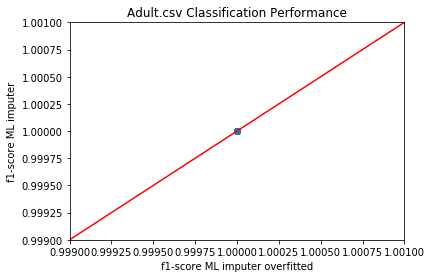

In [51]:
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
f1_overfit = [y['f1'] for x in overfitted_ml_imputer_results for y in overfitted_ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_overfit, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score ML imputer overfitted',
      ylabel = 'f1-score ML imputer',
      xlim = [0.999, 1.001],
      ylim  = [0.999, 1.001])
fig.savefig('ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

## Run ml_imputer on randomly generated dependencies

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [55]:
no_dependencies = 10
random_dependencies = fd_imputer.random_dependency_generator(list(df_test.columns), no_dependencies)

In [56]:
random_dependencies

{2: [[1, 3, 10, 13, 15]],
 6: [[0, 2, 4, 5, 7, 11, 13, 14], [0, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15]],
 1: [[3], [2, 4, 5, 7, 8, 10, 11, 13, 14, 15]],
 4: [[2, 3, 6, 10, 12]],
 5: [[7, 14, 15]],
 10: [[0, 1, 3, 4, 5, 7, 9, 11, 12, 14, 15]],
 7: [[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15]],
 9: [[6]]}

### ML_imputer on random dependencies

In [57]:
ml_imputer_results_random = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_validate,
                                                        df_test,
                                                        random_dependencies,
                                                        continuous)

2019-06-22 16:21:56,904 [INFO]  CategoricalEncoder for column 2                                found only 14 occurrences of value Without-pay
2019-06-22 16:21:56,909 [INFO]  CategoricalEncoder for column 2                                found only 6 occurrences of value Never-worked


[1, 3, 10, 13, 15] 2


2019-06-22 16:21:58,647 [WARNING]  Test set does not contain any ocurrences of values [Without-pay, Never-worked] in column [2], consider using a more representative test set.
2019-06-22 16:21:58,659 [INFO]  
========== start: fit model
2019-06-22 16:21:58,667 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:22:09,355 [INFO]  Epoch[0] Batch [0-814]	Speed: 1223.02 samples/sec	cross-entropy=0.174507	2-accuracy=0.964264
2019-06-22 16:22:20,269 [INFO]  Epoch[0] Train-cross-entropy=0.094062
2019-06-22 16:22:20,274 [INFO]  Epoch[0] Train-2-accuracy=0.981803
2019-06-22 16:22:20,280 [INFO]  Epoch[0] Time cost=21.601
2019-06-22 16:22:20,605 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:22:22,430 [INFO]  Epoch[0] Validation-cross-entropy=0.006393
2019-06-22 16:22:22,437 [INFO]  Epoch[0] Validation-2-accuracy=1.000000
2019-06-22 16:22:32,926 [INFO]  Epoch[1] Batch [0-814]	Speed: 1244.41 samples/sec	cross-entropy=0.005203	2-accuracy=0.999693
2019-06-22 16:22:43

[0, 2, 4, 5, 7, 11, 13, 14] 6


2019-06-22 16:25:49,439 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 16:25:49,452 [INFO]  
========== start: fit model
2019-06-22 16:25:49,456 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:25:59,131 [INFO]  Epoch[0] Batch [0-814]	Speed: 1348.80 samples/sec	cross-entropy=0.278916	6-accuracy=0.942715
2019-06-22 16:26:08,963 [INFO]  Epoch[0] Train-cross-entropy=0.155414
2019-06-22 16:26:08,968 [INFO]  Epoch[0] Train-6-accuracy=0.970823
2019-06-22 16:26:08,972 [INFO]  Epoch[0] Time cost=19.511
2019-06-22 16:26:08,984 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:26:10,638 [INFO]  Epoch[0] Validation-cross-entropy=0.018950
2019-06-22 16:26:10,645 [INFO]  Epoch[0] Validation-6-accuracy=0.997549
2019-06-22 16:26:20,158 [INFO]  Epoch[1] Batch [0-814]	Speed: 1372.04 samples/sec	cross-entropy=0.013213	6-accuracy=0.999156
2019-06-22 16:26:29,697 [IN

[0, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15] 6


2019-06-22 16:29:37,186 [WARNING]  Test set does not contain any ocurrences of values [Married-AF-spouse] in column [6], consider using a more representative test set.
2019-06-22 16:29:37,200 [INFO]  
========== start: fit model
2019-06-22 16:29:37,207 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:29:46,879 [INFO]  Epoch[0] Batch [0-814]	Speed: 1350.36 samples/sec	cross-entropy=0.282822	6-accuracy=0.942638
2019-06-22 16:29:56,623 [INFO]  Epoch[0] Train-cross-entropy=0.160095
2019-06-22 16:29:56,629 [INFO]  Epoch[0] Train-6-accuracy=0.970938
2019-06-22 16:29:56,634 [INFO]  Epoch[0] Time cost=19.419
2019-06-22 16:29:56,643 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:29:58,430 [INFO]  Epoch[0] Validation-cross-entropy=0.018624
2019-06-22 16:29:58,436 [INFO]  Epoch[0] Validation-6-accuracy=1.000000
2019-06-22 16:30:08,683 [INFO]  Epoch[1] Batch [0-814]	Speed: 1273.26 samples/sec	cross-entropy=0.015213	6-accuracy=0.999310
2019-06-22 16:30:18,540 [IN

[3] 1


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 16:33:24,090 [INFO]  
========== start: fit model
2019-06-22 16:33:24,096 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:33:25,006 [INFO]  Epoch[0] Batch [0-814]	Speed: 14433.28 samples/sec	cross-entropy=0.149834	1-accuracy=0.000000
2019-06-22 16:33:25,883 [INFO]  Epoch[0] Train-cross-entropy=0.086123
2019-06-22 16:33:25,889 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-06-22 16:33:25,895 [INFO]  Epoch[0] Time cost=1.793
2019-06-22 16:33:25,903 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:33:25,995 [INFO]  Epoch[0] Validation-cross-entropy=0.000371
2019-06

[2, 4, 5, 7, 8, 10, 11, 13, 14, 15] 1


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-06-22 16:33:50,571 [INFO]  
========== start: fit model
2019-06-22 16:33:50,576 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:33:58,688 [INFO]  Epoch[0] Batch [0-814]	Speed: 1610.08 samples/sec	cross-entropy=0.360272	1-accuracy=0.000000
2019-06-22 16:34:07,632 [INFO]  Epoch[0] Train-cross-entropy=0.181666
2019-06-22 16:34:07,639 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-06-22 16:34:07,645 [INFO]  Epoch[0] Time cost=17.059
2019-06-22 16:34:07,653 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:34:09,390 [INFO]  Epoch[0] Validation-cross-entropy=0.001655
2019-06

[2, 3, 6, 10, 12] 4


2019-06-22 16:35:15,852 [INFO]  
========== start: fit model
2019-06-22 16:35:15,857 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:35:28,720 [INFO]  Epoch[0] Batch [0-814]	Speed: 1015.22 samples/sec	cross-entropy=0.529506	4-accuracy=0.903221
2019-06-22 16:35:41,445 [INFO]  Epoch[0] Train-cross-entropy=0.297395
2019-06-22 16:35:41,451 [INFO]  Epoch[0] Train-4-accuracy=0.950937
2019-06-22 16:35:41,457 [INFO]  Epoch[0] Time cost=25.588
2019-06-22 16:35:41,472 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:35:43,422 [INFO]  Epoch[0] Validation-cross-entropy=0.033461
2019-06-22 16:35:43,429 [INFO]  Epoch[0] Validation-4-accuracy=0.999694
2019-06-22 16:35:56,351 [INFO]  Epoch[1] Batch [0-814]	Speed: 1009.89 samples/sec	cross-entropy=0.022185	4-accuracy=1.000000
2019-06-22 16:36:09,973 [INFO]  Epoch[1] Train-cross-entropy=0.016606
2019-06-22 16:36:09,979 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-06-22 16:36:09,987 [INFO]  Epoch[1] Time cost=26.552


[7, 14, 15] 5


2019-06-22 16:40:10,756 [INFO]  
========== start: fit model
2019-06-22 16:40:10,764 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:40:22,641 [INFO]  Epoch[0] Batch [0-814]	Speed: 1100.12 samples/sec	cross-entropy=0.857536	5-accuracy=0.815721
2019-06-22 16:40:34,406 [INFO]  Epoch[0] Train-cross-entropy=0.529667
2019-06-22 16:40:34,413 [INFO]  Epoch[0] Train-5-accuracy=0.902680
2019-06-22 16:40:34,418 [INFO]  Epoch[0] Time cost=23.644
2019-06-22 16:40:34,431 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:40:36,445 [INFO]  Epoch[0] Validation-cross-entropy=0.114428
2019-06-22 16:40:36,451 [INFO]  Epoch[0] Validation-5-accuracy=0.995098
2019-06-22 16:40:48,383 [INFO]  Epoch[1] Batch [0-814]	Speed: 1094.01 samples/sec	cross-entropy=0.079405	5-accuracy=0.997009
2019-06-22 16:41:00,251 [INFO]  Epoch[1] Train-cross-entropy=0.059487
2019-06-22 16:41:00,258 [INFO]  Epoch[1] Train-5-accuracy=0.997889
2019-06-22 16:41:00,265 [INFO]  Epoch[1] Time cost=23.807


[0, 1, 3, 4, 5, 7, 9, 11, 12, 14, 15] 10


2019-06-22 16:44:48,215 [INFO]  
========== start: fit model
2019-06-22 16:44:48,220 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:44:57,348 [INFO]  Epoch[0] Batch [0-814]	Speed: 1431.14 samples/sec	cross-entropy=0.218114	10-accuracy=0.942638
2019-06-22 16:45:06,872 [INFO]  Epoch[0] Train-cross-entropy=0.131681
2019-06-22 16:45:06,878 [INFO]  Epoch[0] Train-10-accuracy=0.971207
2019-06-22 16:45:06,884 [INFO]  Epoch[0] Time cost=18.656
2019-06-22 16:45:06,892 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:45:08,739 [INFO]  Epoch[0] Validation-cross-entropy=0.025871
2019-06-22 16:45:08,751 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-22 16:45:17,924 [INFO]  Epoch[1] Batch [0-814]	Speed: 1422.87 samples/sec	cross-entropy=0.018292	10-accuracy=1.000000
2019-06-22 16:45:27,575 [INFO]  Epoch[1] Train-cross-entropy=0.013837
2019-06-22 16:45:27,581 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-06-22 16:45:27,587 [INFO]  Epoch[1] Time cost=18

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15] 7


2019-06-22 16:48:31,819 [INFO]  
========== start: fit model
2019-06-22 16:48:31,825 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:48:44,350 [INFO]  Epoch[0] Batch [0-814]	Speed: 1042.19 samples/sec	cross-entropy=0.580171	7-accuracy=0.908512
2019-06-22 16:48:56,950 [INFO]  Epoch[0] Train-cross-entropy=0.320048
2019-06-22 16:48:56,956 [INFO]  Epoch[0] Train-7-accuracy=0.953662
2019-06-22 16:48:56,963 [INFO]  Epoch[0] Time cost=25.131
2019-06-22 16:48:56,976 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:48:58,923 [INFO]  Epoch[0] Validation-cross-entropy=0.031956
2019-06-22 16:48:58,929 [INFO]  Epoch[0] Validation-7-accuracy=0.999694
2019-06-22 16:49:12,264 [INFO]  Epoch[1] Batch [0-814]	Speed: 978.45 samples/sec	cross-entropy=0.020683	7-accuracy=0.999693
2019-06-22 16:49:24,945 [INFO]  Epoch[1] Train-cross-entropy=0.015677
2019-06-22 16:49:24,952 [INFO]  Epoch[1] Train-7-accuracy=0.999731
2019-06-22 16:49:24,957 [INFO]  Epoch[1] Time cost=26.021
2

[6] 9


2019-06-22 16:53:23,357 [INFO]  
========== start: fit model
2019-06-22 16:53:23,365 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:53:32,163 [INFO]  Epoch[0] Batch [0-814]	Speed: 1484.76 samples/sec	cross-entropy=0.120424	9-accuracy=0.974080
2019-06-22 16:53:40,726 [INFO]  Epoch[0] Train-cross-entropy=0.064286
2019-06-22 16:53:40,734 [INFO]  Epoch[0] Train-9-accuracy=0.987024
2019-06-22 16:53:40,741 [INFO]  Epoch[0] Time cost=17.367
2019-06-22 16:53:40,749 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:53:42,494 [INFO]  Epoch[0] Validation-cross-entropy=0.004154
2019-06-22 16:53:42,500 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-06-22 16:53:51,043 [INFO]  Epoch[1] Batch [0-814]	Speed: 1527.80 samples/sec	cross-entropy=0.002872	9-accuracy=1.000000
2019-06-22 16:53:59,646 [INFO]  Epoch[1] Train-cross-entropy=0.002160
2019-06-22 16:53:59,652 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-06-22 16:53:59,661 [INFO]  Epoch[1] Time cost=17.155


In [ ]:
overfitted_ml_imputer_results_random = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_train,
                                                        df_validate,
                                                        random_dependencies,
                                                        continuous)

2019-06-22 16:56:43,951 [INFO]  CategoricalEncoder for column 2                                found only 14 occurrences of value Without-pay
2019-06-22 16:56:43,960 [INFO]  CategoricalEncoder for column 2                                found only 6 occurrences of value Never-worked


[1, 3, 10, 13, 15] 2


2019-06-22 16:56:47,324 [INFO]  
========== start: fit model
2019-06-22 16:56:47,332 [WARNING]  Already bound, ignoring bind()
2019-06-22 16:56:57,774 [INFO]  Epoch[0] Batch [0-814]	Speed: 1251.31 samples/sec	cross-entropy=0.174196	2-accuracy=0.964724
2019-06-22 16:57:08,799 [INFO]  Epoch[0] Train-cross-entropy=0.093958
2019-06-22 16:57:08,807 [INFO]  Epoch[0] Train-2-accuracy=0.982033
2019-06-22 16:57:08,814 [INFO]  Epoch[0] Time cost=21.471
2019-06-22 16:57:08,833 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 16:57:23,358 [INFO]  Epoch[0] Validation-cross-entropy=0.007003
2019-06-22 16:57:23,364 [INFO]  Epoch[0] Validation-2-accuracy=0.999654
2019-06-22 16:57:34,015 [INFO]  Epoch[1] Batch [0-814]	Speed: 1225.48 samples/sec	cross-entropy=0.005201	2-accuracy=0.999693
2019-06-22 16:57:44,629 [INFO]  Epoch[1] Train-cross-entropy=0.003781
2019-06-22 16:57:44,639 [INFO]  Epoch[1] Train-2-accuracy=0.999846
2019-06-22 16:57:44,652 [INFO]  Epoch[1] Time cost=21.283


[0, 2, 4, 5, 7, 11, 13, 14] 6


2019-06-22 17:03:51,101 [INFO]  
========== start: fit model
2019-06-22 17:03:51,107 [WARNING]  Already bound, ignoring bind()
2019-06-22 17:04:00,929 [INFO]  Epoch[0] Batch [0-814]	Speed: 1329.79 samples/sec	cross-entropy=0.279234	6-accuracy=0.942331
2019-06-22 17:04:11,602 [INFO]  Epoch[0] Train-cross-entropy=0.155744
2019-06-22 17:04:11,607 [INFO]  Epoch[0] Train-6-accuracy=0.970631
2019-06-22 17:04:11,612 [INFO]  Epoch[0] Time cost=20.496
2019-06-22 17:04:11,766 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-22 17:04:25,884 [INFO]  Epoch[0] Validation-cross-entropy=0.020868
2019-06-22 17:04:25,890 [INFO]  Epoch[0] Validation-6-accuracy=0.998234
2019-06-22 17:04:35,863 [INFO]  Epoch[1] Batch [0-814]	Speed: 1309.10 samples/sec	cross-entropy=0.013215	6-accuracy=0.999156
2019-06-22 17:04:45,753 [INFO]  Epoch[1] Train-cross-entropy=0.010345
2019-06-22 17:04:45,761 [INFO]  Epoch[1] Train-6-accuracy=0.999194
2019-06-22 17:04:45,769 [INFO]  Epoch[1] Time cost=19.872


In [ ]:
f1_ml = [y['f1'] for x in ml_imputer_results_random for y in ml_imputer_results_random[x] if 'f1' in y.keys()]
f1_overfit = [y['f1'] for x in overfitted_ml_imputer_results_random for y in overfitted_ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_overfit, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score ML imputer overfitted',
      ylabel = 'f1-score ML imputer',
      xlim = [0.999, 1.001],
      ylim  = [0.999, 1.001])
fig.savefig('ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')